In [1]:
# !pip install -U transformers

In [2]:
import torch
import numpy as np
import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import warnings
import csv
import os
warnings.filterwarnings("ignore")

# 设备配置（自动适配GPU/CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 模型路径（保持你原来的不变）
model_path = "/kaggle/input/llama3-8b-instruct/transformers/default/1/Meta-Llama-3-8B-Instruct"

# ===================== 只加载一次Tokenizer和Model（核心修改：删除重复加载）=====================
# 加载Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
# 设置pad_token和padding_side（Llama 3默认没有pad_token，用eos_token替代）
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16, 
    device_map="auto", 
    low_cpu_mem_usage=True,  
    trust_remote_code=True 
)

# 模型设置为评估模式
model.eval()

print("✅ Model and Tokenizer loaded successfully!")
print(f"📊 配置：float16精度 + 自动设备分配 + hidden_states启用")

2025-11-11 15:36:48.243942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762875408.476078      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762875408.543514      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Model and Tokenizer loaded successfully!
📊 配置：float16精度 + 自动设备分配 + hidden_states启用


In [4]:
import os

# 检查文件是否存在
csv_path = "/kaggle/input/testset/testset.csv"
if not os.path.exists(csv_path):
    print(f"文件不存在！请检查路径：{csv_path}")
    print("当前目录下的文件列表：", os.listdir("/kaggle/input/testset"))  # 打印文件夹内的文件
else:
    print("文件存在，可以正常加载")

文件存在，可以正常加载


In [5]:
torch.cuda.empty_cache()

### new version

In [6]:
# 全局变量保存实验一数据
experiment1_data = {}

def save_experiment1_data(detailed_result):
    """保存实验一的hidden states数据"""
    test_id = detailed_result['test_id']
    
    # 构建保存的数据结构
    saved_data = {
        'test_id': test_id,
        'problem': detailed_result.get('problem', ''),
        'step_by_step_response': detailed_result['step_by_step_response'],
        'step_data': [],
        'skipping_info': detailed_result['skipping_info'],
        'all_skip_results': detailed_result['all_skip_results'],
        'hidden_states_info': {
            'total_steps': len(detailed_result.get('step_data', [])),
            'has_skipped_steps': len(detailed_result['skipping_info']['skipped_steps']) > 0,
            'saved_timestamp': str(np.datetime64('now')),
            'target_layer': -1
        }
    }
    
    # 保存步骤数据（包括hidden states和layer_idx）
    for step in detailed_result.get('step_data', []):
        step_data_copy = step.copy()
        if 'hidden_state' in step_data_copy:
            step_data_copy['hidden_state'] = step_data_copy['hidden_state']
        step_data_copy['layer_idx'] = step.get('layer_idx', -1)
        saved_data['step_data'].append(step_data_copy)
    
    # 保存到全局变量
    experiment1_data[test_id] = saved_data
    
    # 保存到文件
    filename = f"experiment1_hidden_states_{test_id}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(saved_data, f)
    
    print(f"✓ 已保存 {test_id} 的hidden states数据到 {filename}")
    print(f"  - 步骤数量: {len(saved_data['step_data'])}")
    print(f"  - 跳步数量: {len(saved_data['skipping_info']['skipped_steps'])}")
    if saved_data['step_data']:
        print(f"  - hidden state形状: {saved_data['step_data'][0]['hidden_state'].shape}")
        print(f"  - 提取层索引: {saved_data['step_data'][0]['layer_idx']}")

def save_complete_experiment1_data():
    """保存完整的实验一数据集"""
    if experiment1_data:
        with open("experiment1_complete_data.pkl", 'wb') as f:
            pickle.dump(experiment1_data, f)
        print(f"\n🎉 已保存完整的实验一数据，共 {len(experiment1_data)} 个测试案例")
        return True
    else:
        print("❌ 没有实验数据可保存")
        return False

def summarize_experiment1_data():
    """汇总实验一数据"""
    print("\n" + "="*60)
    print("实验一数据汇总")
    print("="*60)
    
    if not experiment1_data:
        print("暂无实验数据")
        return
    
    for test_id, data in experiment1_data.items():
        print(f"\n{test_id}:")
        print(f"  问题: {data['problem'][:100]}...")
        print(f"  推理步骤: {len(data['step_data'])}")
        print(f"  跳步: {len(data['skipping_info']['skipped_steps'])}")
        print(f"  跳步详情: {data['skipping_info']['skipped_steps']}")
        if data['step_data']:
            print(f"  提取层索引: {data['step_data'][0]['layer_idx']}")

def calculate_similarity_between_paths(actual_skip_hidden, generated_paths_hidden_states):
    """
    计算实际跳步hidden states与生成路径hidden states的相似度
    """
    similarities = []
    actual_vector = actual_skip_hidden.reshape(1, -1)
    
    for path_hidden in generated_paths_hidden_states:
        if path_hidden is not None:
            path_vector = path_hidden.reshape(1, -1)
            sim = cosine_similarity(actual_vector, path_vector)[0][0]
            similarities.append(float(sim))
        else:
            similarities.append(0.0)
    
    return similarities

def get_actual_skip_hidden_state(skip_step_key, step_data, skipping_info, outputs, prompt_length):
    """
    获取实际跳步步骤的hidden state
    """
    # 方法1: 尝试从step_data中直接找到跳步步骤
    for step in step_data:
        if step['step_number'] == skip_step_key:
            return step['hidden_state'], step.get('layer_idx', -1)
    
    # 方法2: 如果找不到，根据跳步位置推断
    if step_data:
        return step_data[-1]['hidden_state'], step_data[-1].get('layer_idx', -1)
    
    # 方法3: 返回整个推理的最后一个hidden state
    generated_ids = outputs.sequences[0, prompt_length:]
    layer_idx = -1
    if len(generated_ids) > 0:
        actual_hidden_idx = prompt_length + len(generated_ids) - 1
        if actual_hidden_idx < len(outputs.hidden_states[layer_idx]):
            hidden_state = outputs.hidden_states[layer_idx][actual_hidden_idx][0, -1, :].cpu().numpy()
            return hidden_state, layer_idx
    
    return None, -1

def build_llama3_prompt(system_msg, user_msg):
    """构建符合Llama 3格式的prompt"""
    return f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system_msg}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n{user_msg}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

# =====================================================
# 读取CSV测试集函数
# =====================================================
def load_testset(csv_path="/kaggle/input/testset/testset.csv"):
    """读取CSV格式的测试集"""
    testset = []
    with open(csv_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            expected_steps = row['expected_complete_reasoning'].split('||')
            testset.append({
                'id': row['id'],
                'problem': row['problem'],
                'expected_complete_reasoning': expected_steps
            })
    print(f"✓ 成功加载 {len(testset)} 个测试问题")
    return testset

# =====================================================
# 步骤级hidden states提取（修正版）
# =====================================================
def extract_step_level_hidden_states(outputs, prompt_length, generated_text):
    steps = parse_step_structure(generated_text)
    step_data = []
    generated_ids = outputs.sequences[0, prompt_length:]
    full_generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    total_hidden_length = len(generated_ids)

    layer_idx = -1
    
    current_position = 0
    for step_num, step_text in steps.items():
        step_text_clean = step_text.strip()
        step_start = full_generated_text.find(step_text_clean, current_position)
        
        if step_start == -1:
            full_text_clean = " ".join(full_generated_text.split())
            step_text_clean_no_space = " ".join(step_text_clean.split())
            step_start = full_text_clean.find(step_text_clean_no_space, current_position)
            if step_start == -1:
                continue
        
        step_tokens = tokenizer.encode(step_text_clean, add_special_tokens=False)
        step_token_length = len(step_tokens)
        if step_token_length == 0:
            continue
        
        text_before_step = full_generated_text[:step_start]
        tokens_before_step = tokenizer.encode(text_before_step, add_special_tokens=False)
        step_start_token_idx = len(tokens_before_step)
        step_end_token_idx = step_start_token_idx + step_token_length - 1
        
        if step_end_token_idx < step_start_token_idx:
            current_position = step_start + len(step_text_clean)
            continue
        
        if step_end_token_idx >= total_hidden_length:
            step_end_token_idx = total_hidden_length - 1
        
        actual_hidden_idx = prompt_length + step_end_token_idx
        if actual_hidden_idx >= len(outputs.hidden_states[-1]):
            actual_hidden_idx = len(outputs.hidden_states[-1]) - 1
        step_hidden = outputs.hidden_states[-1][actual_hidden_idx][0, -1, :].cpu().numpy()
        
        step_data.append({
            'step_number': step_num,
            'step_text': step_text,
            'hidden_state': step_hidden,
            'layer_idx': layer_idx, 
            'token_start': step_start_token_idx,
            'token_end': step_end_token_idx,
            'token_length': step_token_length,
            'text_position': step_start
        })
        
        current_position = step_start + len(step_text_clean)
    
    if not step_data and len(generated_ids) > 0:
        actual_hidden_idx = prompt_length + len(generated_ids) - 1
        if actual_hidden_idx >= len(outputs.hidden_states[-1]):
            actual_hidden_idx = len(outputs.hidden_states[-1]) - 1
        last_hidden = outputs.hidden_states[-1][actual_hidden_idx][0, -1, :].cpu().numpy()
        step_data.append({
            'step_number': 'step_1',
            'step_text': generated_text,
            'hidden_state': last_hidden,
            'layer_idx': layer_idx, 
            'token_start': 0,
            'token_end': len(generated_ids) - 1,
            'token_length': len(generated_ids),
            'text_position': 0
        })
    
    return step_data

def parse_step_structure(text):
    steps = {}
    step_patterns = [
        r'(Step\s*\d+\s*:)(.*?)(?=Step\s*\d+\s*:|Final Answer:|$)',
        r'(\d+\.\s*)(.*?)(?=\d+\.\s*|Final Answer:|$)',
        r'(\d+\)\s*)(.*?)(?=\d+\)\s*|Final Answer:|$)',
        r'(Final Answer:\s*)(.*?)(?=$)'
    ]
    
    all_matches = []
    for pattern in step_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE | re.DOTALL)
        for match in matches:
            header, content = match[0], match[1]
            start_pos = text.find(header)
            if start_pos != -1:
                all_matches.append((start_pos, header.strip(), content.strip()))
    
    all_matches.sort(key=lambda x: x[0])
    
    for i, (pos, header, content) in enumerate(all_matches):
        if not content:
            continue
        if "final" in header.lower() or "answer" in header.lower():
            step_key = "final"
        else:
            step_key = f"step_{i+1}"
        step_text = f"{header} {content}".strip()
        steps[step_key] = step_text
    
    if len(steps) <= 1:
        steps = heuristic_step_splitting(text)
    
    return steps

def heuristic_step_splitting(text):
    steps = {}
    lines = text.split('\n')
    step_count = 1
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if (re.match(r'^\d+\.', line) or 
            re.match(r'^Step\s*\d+', line, re.I) or
            re.match(r'^\d+\)', line) or
            len(line) > 20 and any(keyword in line.lower() for keyword in ['first', 'then', 'next', 'after', 'finally'])):
            if 'final' not in line.lower() and 'answer' not in line.lower():
                steps[f'step_{step_count}'] = line
                step_count += 1
            else:
                steps['final'] = line
    
    if len(steps) <= 1:
        sentences = re.split(r'[.!?]+', text)
        for sentence in sentences:
            sentence = sentence.strip()
            if len(sentence) > 15 and not sentence.startswith(('So', 'Therefore', 'Thus')):
                if step_count <= 4:
                    steps[f'step_{step_count}'] = sentence
                    step_count += 1
    
    return steps

# =====================================================
# 跳步识别函数（优化逻辑自洽性）
# =====================================================
def identify_skipped_steps(step_by_step_response, problem, expected_complete_reasoning):
    judge_prompt = build_llama3_prompt(
        "You are a strict but reasonable reasoning analyzer. Focus on comparing actual reasoning with expected core logic step by step. Missing any expected core logic = skipped step. Wording differences are acceptable if core logic is fully included.",
        f"""Problem: {problem}

Expected Complete Reasoning (EACH STEP'S CORE LOGIC IS MANDATORY):
{chr(10).join([f"Expected Step {i+1}: {step.strip()}" for i, step in enumerate(expected_complete_reasoning)])}

Actual Reasoning:
{step_by_step_response}

Strict Rules:
1. First, count how many complete reasoning steps the actual response has (excluding final answer).
2. For each expected step (1,2,...n), check if its core logic is present in ANY of the actual steps.
3. If an expected step's core logic is not found in any actual step → mark as skipped.
4. If the actual response has steps but misses expected core logic → list the skipped expected step numbers.
5. If the actual response has NO reasoning steps (only final answer) → mark all expected steps as skipped.
6. For incomplete problems (actual reasoning asks for more info), mark SKIPPED_STEPS as "incomplete_problem".
7. Do NOT mark a step as skipped if its core logic is included in another actual step.

Must output in this EXACT format (no extra words):
SKIPPED_STEPS: [step numbers separated by commas / "incomplete_problem" / "none" only if 100% complete]
SKIPPED_CONTENT: [missing core logic (list expected steps' core content) / "incomplete_problem" / "none"]
SKIPPING_LOCATION: [between step X and step Y / "start" (if first step skipped) / "end" / "incomplete_problem" / "none"]"""
    )
    
    inputs = tokenizer(judge_prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=200,
            num_return_sequences=1,
            do_sample=False,
            return_dict_in_generate=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    judge_response = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    judge_analysis = judge_response.split("assistant")[-1].strip() if "assistant" in judge_response else judge_response
    skipping_info = parse_skipping_analysis(judge_analysis)
    return skipping_info, judge_analysis

def parse_skipping_analysis(analysis_text):
    skipping_info = {
        'skipped_steps': [],
        'skipped_content': '',
        'skipping_location': '',
        'from_step': None,
        'to_step': None
    }
    
    steps_match = re.search(r'SKIPPED_STEPS:\s*([^\n]+)', analysis_text)
    if steps_match:
        steps_str = steps_match.group(1).strip()
        if steps_str != "none" and steps_str != "incomplete_problem":
            step_numbers = re.findall(r'\d+', steps_str)
            skipping_info['skipped_steps'] = [f"step_{num}" for num in step_numbers]
    
    content_match = re.search(r'SKIPPED_CONTENT:\s*([^\n]+)', analysis_text)
    if content_match:
        skipping_info['skipped_content'] = content_match.group(1).strip()
    
    location_match = re.search(r'SKIPPING_LOCATION:\s*([^\n]+)', analysis_text)
    if location_match:
        location_str = location_match.group(1).strip()
        skipping_info['skipping_location'] = location_str
        step_matches = re.findall(r'step\s*(\d+)', location_str.lower())
        if len(step_matches) >= 2:
            skipping_info['from_step'] = f"step_{step_matches[0]}"
            skipping_info['to_step'] = f"step_{step_matches[1]}"
    
    return skipping_info

# =====================================================
# 重构的路径生成函数（优化格式约束+无效内容过滤）
# =====================================================
def generate_explicit_reference_paths(skipping_info, step_data, problem, tokenizer, model, outputs, prompt_length):
    """
    按照方法一要求：构建显式参考路径
    关键优化：强制输出格式、过滤无效内容、确保上下文一致
    """
    # 获取当前跳步信息
    skipped_step_key = skipping_info['skipped_steps'][0] if skipping_info['skipped_steps'] else None
    if not skipped_step_key or not skipped_step_key.startswith('step_'):
        return {
            "status": "error", 
            "error": "无有效跳步步骤",
            "similarities": {},
            "paths": {}
        }
    
    skipped_num = int(skipped_step_key.split('_')[1])
    
    # 获取实际跳步的hidden state
    actual_skip_hidden, _ = get_actual_skip_hidden_state(
        skipped_step_key, step_data, skipping_info, outputs, prompt_length
    )
    
    if actual_skip_hidden is None:
        return {
            "status": "error", 
            "error": "无法获取实际跳步的hidden state",
            "similarities": {},
            "paths": {}
        }
    
    # 构建完整的推理历史（前置条件Xp）
    # 收集跳步之前的所有步骤
    previous_steps = []
    for step in step_data:
        step_num = int(step['step_number'].split('_')[1]) if step['step_number'].startswith('step_') else 0
        if step_num < skipped_num:
            previous_steps.append(step['step_text'].strip())
    
    # 构建完整的前置条件Xp（确保上下文明确）
    if previous_steps:
        Xp = f"Problem: {problem}\n\nPrevious reasoning steps (already completed):\n" + "\n".join([f"{step}" for step in previous_steps])
    else:
        Xp = f"Problem: {problem}\n\nNo previous reasoning steps yet. You need to generate the first reasoning step."
    
    # 获取缺失的核心内容（确保引导精准）
    skipped_content = skipping_info['skipped_content'] if skipping_info['skipped_content'] != 'none' else "complete reasoning for this step"
    
    # 构建不同的引导式提示词Q'（强制格式+内容约束）
    guided_prompts = {
        "path_detailed_calculations": f"""{Xp}

Now you must generate Step {skipped_num} (the missing step).
Missing core content to include: {skipped_content}

REQUIREMENTS (MUST FOLLOW EXACTLY):
1. ONLY output Step {skipped_num} content. NO greetings, explanations, or extra text.
2. Format: "Step {skipped_num}: [detailed reasoning with calculations/intermediate steps]"
3. Must be relevant to the problem. NEVER say "missing context" or "can't help".
4. Keep it concise (1-3 sentences), focus on explicit calculations/quantitative reasoning.

Example Output (correct format):
Step {skipped_num}: Calculate the distance by speed × time (5km/h × 2h = 10km). Then confirm it matches the required route length.
""",
        
        "path_logical_deduction": f"""{Xp}

Now you must generate Step {skipped_num} (the missing step).
Missing core content to include: {skipped_content}

REQUIREMENTS (MUST FOLLOW EXACTLY):
1. ONLY output Step {skipped_num} content. NO extra explanations or greetings.
2. Format: "Step {skipped_num}: [logical deduction with if-then reasoning]"
3. Must connect to the problem/previous steps. NEVER mention missing context.
4. Focus on logical connections (e.g., cause-effect, necessary conditions), 1-3 sentences.

Example Output (correct format):
Step {skipped_num}: Since the building's east side is the entry point, and the question asks for other directions, we can eliminate east and focus on north/south/west.
""",
        
        "path_conceptual_analysis": f"""{Xp}

Now you must generate Step {skipped_num} (the missing step).
Missing core content to include: {skipped_content}

REQUIREMENTS (MUST FOLLOW EXACTLY):
1. ONLY output Step {skipped_num} content. NO extra text or greetings.
2. Format: "Step {skipped_num}: [conceptual analysis with underlying principles]"
3. Must relate to the problem's core concepts. NEVER say "incomplete context".
4. Concise (1-3 sentences), explain the principle guiding this reasoning step.

Example Output (correct format):
Step {skipped_num}: This step relies on the principle of direction elimination—removing known directions (east) leaves the remaining possible directions to analyze.
"""
    }
    
    results = {
        "status": "ok", 
        "actual_skip_hidden_shape": actual_skip_hidden.shape,
        "similarities": {}, 
        "paths": {},
        "generated_hidden_states": {},
        "variance_analysis": {}
    }
    
    # 为每条路径生成3个样本（N-best generations）
    for path_name, guided_prompt in guided_prompts.items():
        individual_sims = []
        valid_path_texts = []
        valid_generated_hiddens = []
        
        for sample_num in range(3):  # 3次采样，保证稳定性
            full_prompt = build_llama3_prompt(
                "You are a precise reasoning assistant. Generate only the required step following the exact format and requirements. Do NOT add any extra content.",
                guided_prompt
            )
            
            inputs = tokenizer(full_prompt, return_tensors="pt", truncation=True, max_length=2048).to(model.device)
            with torch.no_grad():
                path_outputs = model.generate(
                    **inputs,
                    max_new_tokens=100,  # 限制长度，避免冗余
                    do_sample=True,
                    temperature=0.6,  # 平衡随机性和一致性
                    top_p=0.9,  # 提升生成质量
                    output_hidden_states=True,
                    return_dict_in_generate=True,
                    pad_token_id=tokenizer.eos_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
            
            # 解码并过滤无效内容
            generated_ids = path_outputs.sequences[0, len(inputs.input_ids[0]):]
            raw_text = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
            
            # 严格过滤：只保留符合格式的Step N内容
            filtered_text = ""
            if f"Step {skipped_num}:" in raw_text:
                # 提取Step N开头的内容，直到换行或结束
                step_start = raw_text.find(f"Step {skipped_num}:")
                step_end = raw_text.find("\n", step_start) if "\n" in raw_text[step_start:] else len(raw_text)
                filtered_text = raw_text[step_start:step_end].strip()
                # 移除可能的多余标记（如模型添加的序号）
                filtered_text = re.sub(r'^Step\s*\d+:\s*', f'Step {skipped_num}: ', filtered_text)
            
            # 仅保留有效文本（非空且符合格式）
            if filtered_text and filtered_text.startswith(f"Step {skipped_num}:"):
                valid_path_texts.append(filtered_text)
                
                # 提取该样本的hidden state（取生成序列的最后一个token的隐藏状态）
                if hasattr(path_outputs, 'hidden_states') and path_outputs.hidden_states:
                    # 修正：LLaMA3的hidden_states结构是 tuple(生成步骤) → tuple(模型层) → tensor
                    # 1. 取最后一步生成的隐藏状态（tuple(模型层)）
                    last_step_hiddens = path_outputs.hidden_states[-1]  # tuple: (layer_0, layer_1, ..., layer_n)
                    # 2. 取最后一层的隐藏状态（tensor: (batch, seq_len, hidden_size)）
                    if isinstance(last_step_hiddens, tuple) and len(last_step_hiddens) > 0:
                        last_layer_hiddens = last_step_hiddens[-1]  # 最后一层的tensor
                        # 3. 验证tensor形状，取最后一个token的隐藏状态
                        if last_layer_hiddens.ndim == 3 and last_layer_hiddens.shape[1] > 0:
                            path_hidden = last_layer_hiddens[0, -1, :].cpu().numpy()  # (hidden_size,)
                            valid_generated_hiddens.append(path_hidden)
            else:
                print(f"⚠️  路径 {path_name} 样本 {sample_num+1} 生成无效内容，已过滤：{raw_text[:50]}...")
        
        # 处理无有效样本的情况
        if not valid_generated_hiddens:
            results["similarities"][path_name] = {
                "individual": [0.0, 0.0, 0.0],
                "mean": 0.0,
                "std": 0.0,
                "variance": 0.0
            }
            results["paths"][path_name] = ["无有效生成内容"]
            results["generated_hidden_states"][path_name] = [None, None, None]
            continue
        
        # 计算相似度（实际跳步 vs 有效生成路径）
        sims = calculate_similarity_between_paths(actual_skip_hidden, valid_generated_hiddens)
        # 补充空值以保证3个样本的结构一致性
        while len(sims) < 3:
            sims.append(0.0)
        
        # 计算统计信息
        mean_sim = float(np.mean(sims[:3]))  # 取前3个（最多3个）
        std_sim = float(np.std(sims[:3]))
        var_sim = float(np.var(sims[:3]))
        
        results["similarities"][path_name] = {
            "individual": sims[:3],  # 确保长度为3
            "mean": mean_sim,
            "std": std_sim,
            "variance": var_sim
        }
        results["paths"][path_name] = valid_path_texts + ["无有效生成内容"] * (3 - len(valid_path_texts))  # 补全3个
        results["generated_hidden_states"][path_name] = valid_generated_hiddens + [None] * (3 - len(valid_generated_hiddens))  # 补全3个
    
    # 计算跨路径的方差分析（所有路径的平均相似度的方差）
    all_path_means = []
    for path_name in guided_prompts.keys():
        path_mean = results["similarities"][path_name]["mean"]
        all_path_means.append(path_mean)
    
    cross_path_variance = float(np.var(all_path_means)) if len(all_path_means) > 1 else 0.0
    results["variance_analysis"]["cross_path_variance"] = cross_path_variance
    results["variance_analysis"]["path_means"] = all_path_means
    results["variance_analysis"]["path_names"] = list(guided_prompts.keys())
    
    return results

def print_detailed_similarity_analysis(skip_step, similarity_results, paths):
    """
    打印详细的相似度分析，包括每次相似度和方差分析
    """
    print(f"\n🔍 【跳步 {skip_step} 详细相似度分析】")
    print("-" * 60)
    
    # 打印各路径相似度
    for path_name, sim_data in similarity_results.items():
        individual_sims = sim_data["individual"]
        mean_sim = sim_data["mean"]
        variance = sim_data["variance"]
        
        print(f"\n📊 {path_name.replace('_', ' ').title()}:")
        print(f"   单次相似度: {[f'{sim:.4f}' for sim in individual_sims]}")
        print(f"   平均相似度: {mean_sim:.4f}")
        print(f"   样本内方差: {variance:.6f}")
        
        # 显示对应的路径文本（只显示有效内容）
        path_texts = paths[path_name]
        for i, text in enumerate(path_texts):
            if text != "无有效生成内容":
                print(f"   样本{i+1}: {text}")
            else:
                print(f"   样本{i+1}: {text}")
    
    # 跨路径方差分析
    cross_variance = similarity_results.get("variance_analysis", {}).get("cross_path_variance", 0.0)
    path_means = similarity_results.get("variance_analysis", {}).get("path_means", [])
    path_names = similarity_results.get("variance_analysis", {}).get("path_names", [])
    
    print(f"\n🎯 跨路径方差分析:")
    print(f"   各路径平均相似度: {dict(zip(path_names, [f'{m:.4f}' for m in path_means]))}")
    print(f"   跨路径方差: {cross_variance:.6f}")
    
    # 方差解读（结合实际场景优化）
    if cross_variance < 0.005:
        print("   📝 解读: 极低方差 - 跳步状态与所有路径相似度接近，可能是推理空间狭窄或跳步状态信息泛化")
    elif 0.005 <= cross_variance < 0.02:
        print("   📝 解读: 低方差 - 跳步状态对多条路径有弱偏好，无明显倾向性")
    elif 0.02 <= cross_variance < 0.05:
        print("   📝 解读: 中等方差 - 跳步状态对某条路径有明显偏好，支持潜在推理路径假设")
    else:
        print("   📝 解读: 高方差 - 跳步状态与特定路径高度吻合，强烈支持潜在推理路径假设")

In [7]:
# =====================================================
# 单个问题实验流程
# =====================================================
def main_experiment_with_save(test_sample):
    """按照方法一要求修改的实验流程"""
    test_id = test_sample['id']
    problem = test_sample['problem']
    expected_steps = test_sample['expected_complete_reasoning']
    
    # 生成分步推理（关键：在generate中设置output_hidden_states=True）
    step_by_step_prompt = build_llama3_prompt(
        "You solve reasoning problems in a FIXED FORMAT. Follow EXACTLY: 1. Start with 'Step 1: ...' 2. Each step has only core logic 3. End with 'Final Answer: ...' 4. No extra greetings/explanations 5. Do NOT ask for more information (try your best if problem is simple)",
        f"Problem: {problem}\n\nSolve step by step in the FIXED FORMAT (only core logic, no extra words):"
    )
    inputs = tokenizer(step_by_step_prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(model.device)
    with torch.no_grad():
        # 关键修正：在generate中设置output_hidden_states=True
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            num_return_sequences=1,
            do_sample=True,
            output_hidden_states=True,  # 正确的位置
            return_dict_in_generate=True,
            pad_token_id=tokenizer.eos_token_id
        )
    full_response = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    step_by_step_response = full_response.split("assistant")[-1].strip() if "assistant" in full_response else full_response
    
    # 提取步骤级hidden states
    prompt_length = inputs.input_ids.shape[1]
    step_data = extract_step_level_hidden_states(outputs, prompt_length, step_by_step_response)
    
    # 识别跳步位置
    skipping_info, judge_analysis = identify_skipped_steps(step_by_step_response, problem, expected_steps)
    
    # 为每个跳步生成显式参考路径并计算相似度
    all_skip_results = []
    if skipping_info['skipped_steps']:
        for skip_step in skipping_info['skipped_steps']:
            # 关键修改：直接传递完整的skipping_info，不再构建single_skip_info
            comparison_results = generate_explicit_reference_paths(
                skipping_info,  # 直接传递完整的跳步信息
                step_data, 
                problem,
                tokenizer, 
                model,
                outputs,
                prompt_length
            )
            all_skip_results.append({
                'skip_step': skip_step,
                'similarity_results': comparison_results.get('similarities', {}),
                'variance_analysis': comparison_results.get('variance_analysis', {}),
                'paths': comparison_results.get('paths', {}),
                'actual_hidden_shape': comparison_results.get('actual_skip_hidden_shape', 'unknown'),
                'status': comparison_results.get('status', 'unknown')
            })
    
    # 构建完整结果
    result = {
        'test_id': test_id,
        'problem': problem,
        'step_by_step_response': step_by_step_response,
        'judge_analysis': judge_analysis,
        'skipping_info': skipping_info,
        'all_skip_results': all_skip_results,
        'step_data': step_data,
        'prompt_length': prompt_length
    }
    
    # 保存数据
    save_experiment1_data(result)
    
    return result

# =====================================================
# 修正的详细相似度分析函数
# =====================================================
def print_detailed_similarity_analysis(skip_step, skip_result):
    """
    修正版：打印详细的相似度分析，包括每次相似度和方差分析
    关键修复：正确获取跨路径方差数据
    """
    similarity_results = skip_result.get('similarity_results', {})
    paths = skip_result.get('paths', {})
    variance_analysis = skip_result.get('variance_analysis', {})
    
    print(f"\n🔍 【跳步 {skip_step} 详细相似度分析】")
    print("-" * 60)
    
    # 打印各路径相似度
    for path_name, sim_data in similarity_results.items():
        individual_sims = sim_data["individual"]
        mean_sim = sim_data["mean"]
        variance = sim_data["variance"]
        
        print(f"\n📊 {path_name.replace('_', ' ').title()}:")
        print(f"   单次相似度: {[f'{sim:.4f}' for sim in individual_sims]}")
        print(f"   平均相似度: {mean_sim:.4f}")
        print(f"   样本内方差: {variance:.6f}")
        
        # 显示对应的路径文本（只显示有效内容）
        path_texts = paths.get(path_name, [])
        for i, text in enumerate(path_texts):
            if text != "无有效生成内容":
                print(f"   样本{i+1}: {text}")
            else:
                print(f"   样本{i+1}: {text}")
    
    # 跨路径方差分析 - 关键修复：直接从variance_analysis获取
    cross_variance = variance_analysis.get("cross_path_variance", 0.0)
    path_means = variance_analysis.get("path_means", [])
    path_names = variance_analysis.get("path_names", [])
    
    print(f"\n🎯 跨路径方差分析:")
    path_mean_dict = dict(zip(path_names, [f'{m:.4f}' for m in path_means]))
    print(f"   各路径平均相似度: {path_mean_dict}")
    print(f"   跨路径方差: {cross_variance:.6f}")
    
    # 方差解读（结合实际场景优化）
    if cross_variance < 0.005:
        print("   📝 解读: 极低方差 - 跳步状态与所有路径相似度接近，可能是推理空间狭窄或跳步状态信息泛化")
    elif 0.005 <= cross_variance < 0.02:
        print("   📝 解读: 低方差 - 跳步状态对多条路径有弱偏好，无明显倾向性")
    elif 0.02 <= cross_variance < 0.05:
        print("   📝 解读: 中等方差 - 跳步状态对某条路径有明显偏好，支持潜在推理路径假设")
    else:
        print("   📝 解读: 高方差 - 跳步状态与特定路径高度吻合，强烈支持潜在推理路径假设")

# =====================================================
# 批量运行测试集（更新显示逻辑）
# =====================================================
def run_experiment1_with_save():
    """运行实验一并保存所有数据"""
    testset = load_testset("/kaggle/input/testset/testset.csv")
    
    print("=" * 70)
    print(f"实验一：基于隐藏状态相似性的路径匹配分析 - 共 {len(testset)} 个问题")
    print("=" * 70)
    
    # 路径描述映射
    path_descriptions = {
        "path_detailed_calculations": "详细计算路径",
        "path_logical_deduction": "逻辑推理路径", 
        "path_conceptual_analysis": "概念分析路径"
    }
    
    all_results = []
    for i, test_sample in enumerate(testset):
        print(f"\n处理进度: {i+1}/{len(testset)}")
        result = main_experiment_with_save(test_sample)
        all_results.append(result)
        
        test_id = result['test_id']
        skipping_info = result['skipping_info']
        all_skip_results = result['all_skip_results']
        step_by_step_response = result['step_by_step_response']
        judge_analysis = result['judge_analysis']
        
        print(f"\n【{test_id} 验证结果】")
        print(f"模型推理过程：\n{step_by_step_response[:300]}...")
        print(f"\nLLM跳步分析：\n{judge_analysis}")
        
        # 输出所有跳步的详细相似度分析
        if all_skip_results:
            for skip_result in all_skip_results:
                skip_step = skip_result['skip_step']
                similarities = skip_result['similarity_results']
                
                # 关键修复：传递完整的skip_result而不是分开的参数
                print_detailed_similarity_analysis(skip_step, skip_result)
                
                # 找出最佳匹配路径
                if similarities:
                    best_path = max(similarities.items(), key=lambda x: x[1]['mean'])[0]
                    best_similarity = similarities[best_path]['mean']
                    best_path_desc = path_descriptions.get(best_path, best_path)
                    print(f"\n🎯 {test_id} {skip_step} 最佳匹配: {best_path_desc} (相似度: {best_similarity:.4f})")
        else:
            print(f"\n{test_id}: 无跳步（根据Judge分析）")
    
    # 汇总数据
    summarize_experiment1_data()
    
    # 保存完整数据集
    if save_complete_experiment1_data():
        print(f"\n📊 实验一数据统计:")
        print(f"  总测试案例: {len(experiment1_data)}")
        total_steps = sum(len(data['step_data']) for data in experiment1_data.values())
        total_skips = sum(len(data['skipping_info']['skipped_steps']) for data in experiment1_data.values())
        print(f"  总推理步骤: {total_steps}")
        print(f"  总跳步数量: {total_skips}")
        
        # 添加相似度统计
        valid_comparisons = 0
        total_similarity = 0.0
        variance_data = []
        
        for test_id, data in experiment1_data.items():
            if data.get('all_skip_results'):
                for skip_result in data['all_skip_results']:
                    similarities = skip_result.get('similarity_results', {})
                    variance_analysis = skip_result.get('variance_analysis', {})
                    
                    # 收集跨路径方差数据
                    cross_variance = variance_analysis.get("cross_path_variance", 0.0)
                    variance_data.append(cross_variance)
                    
                    for path_data in similarities.values():
                        if path_data['mean'] > 0:
                            valid_comparisons += 1
                            total_similarity += path_data['mean']
        
        if valid_comparisons > 0:
            avg_similarity = total_similarity / valid_comparisons
            print(f"  有效对比次数: {valid_comparisons}")
            print(f"  平均相似度: {avg_similarity:.4f}")
        
        if variance_data:
            avg_variance = np.mean(variance_data)
            print(f"  平均跨路径方差: {avg_variance:.6f}")
            print(f"  方差数据范围: [{min(variance_data):.6f}, {max(variance_data):.6f}]")
    
    print(f"\n🎉 实验一完成！所有数据已保存")
    return all_results

# =====================================================
# 执行实验一
# =====================================================
if __name__ == "__main__":
    # 运行实验一并保存数据
    experiment1_results = run_experiment1_with_save()
    
    # 显示保存的文件
    print("\n📁 保存的文件列表:")
    for file in os.listdir('.'):
        if file.startswith('experiment1_') and file.endswith('.pkl'):
            file_size = os.path.getsize(file) / 1024
            print(f"  {file} ({file_size:.1f} KB)")

✓ 成功加载 8 个测试问题
实验一：基于隐藏状态相似性的路径匹配分析 - 共 8 个问题

处理进度: 1/8


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test1 的hidden states数据到 experiment1_hidden_states_Test1.pkl
  - 步骤数量: 5
  - 跳步数量: 1
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test1 验证结果】
模型推理过程：
Step 1: You are facing the north side of the building.

Step 2: From the north side, you can move either west or south.

Step 3: If you move west, you will be on the west side of the building.

Step 4: If you move south, you will be on the south side of the building.

Final Answer: The options are w...

LLM跳步分析：
SKIPPED_STEPS: 1
SKIPPED_CONTENT: walking west
SKIPPING_LOCATION: start

🔍 【跳步 step_1 详细相似度分析】
------------------------------------------------------------

📊 Path Detailed Calculations:
   单次相似度: ['0.7767', '0.8674', '0.8166']
   平均相似度: 0.8202
   样本内方差: 0.001377
   样本1: Step 1: You walk west from the east side, which means you are moving in the opposite direction.
   样本2: Step 1: You enter the building from the east side, so you need to move in the opposite direction to reach the options. Therefore, you must walk west.
   样本3

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test2 的hidden states数据到 experiment1_hidden_states_Test2.pkl
  - 步骤数量: 4
  - 跳步数量: 0
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test2 验证结果】
模型推理过程：
Step 1: The statement "All bachelors have never married" defines the condition for being a bachelor.

Step 2: The statement "John is a man who has never been married" describes John's marital status.

Step 3: Since John has never been married, he meets the condition for being a bachelor.

Final Answ...

LLM跳步分析：
SKIPPED_STEPS: none
SKIPPED_CONTENT: none
SKIPPING_LOCATION: none

Test2: 无跳步（根据Judge分析）

处理进度: 3/8


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test3 的hidden states数据到 experiment1_hidden_states_Test3.pkl
  - 步骤数量: 5
  - 跳步数量: 3
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test3 验证结果】
模型推理过程：
Step 1: x² - 4x + 7 = (x - 1)² + 6

Step 2: (x - 1)² is always non-negative (or zero)

Step 3: 6 is a positive constant

Step 4: The sum of a non-negative number and a positive number is always positive

Final Answer: x² - 4x + 7 is positive for all values of x...

LLM跳步分析：
SKIPPED_STEPS: 2, 3, 4
SKIPPED_CONTENT: Step 2: Rewrite x² – 4x as (x² – 4x + 4) – 4 (add and subtract (4/2)² = 4 to complete the square), Step 3: Simplify the expression: (x – 2)² – 4 + 7 = (x – 2)² + 3, Step 4: Analyze the squared term: (x – 2)² ≥ 0 for all real x (square of any real number is non-negative)
SKIPPING_LOCATION: none

🔍 【跳步 step_2 详细相似度分析】
------------------------------------------------------------

📊 Path Detailed Calculations:
   单次相似度: ['0.6414', '0.6414', '0.6414']
   平均相似度: 0.6414
   样本内方差: 0.000000
   样本1: Step 2: Rewrite x² – 4x as (x² – 4x 

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test4 的hidden states数据到 experiment1_hidden_states_Test4.pkl
  - 步骤数量: 9
  - 跳步数量: 5
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test4 验证结果】
模型推理过程：
Step 1: Consider the first few triangular numbers: 1, 3, 6, 10, 15,...

Step 2: Observe that each triangular number is the sum of consecutive integers, starting from 1: 1 = 1, 3 = 1 + 2, 6 = 1 + 2 + 3, 10 = 1 + 2 + 3 + 4,...

Step 3: Notice that the sum of the first k integers is equal to k(k+1)/2: ...

LLM跳步分析：
SKIPPED_STEPS: 2, 3, 5, 6, 7
SKIPPED_CONTENT: Expected Step 2: Write the sum in reverse, Expected Step 3: Add the two equations, Expected Step 5: Recall the identity that sum of first n cubes = (sum of first n integers)², Expected Step 6: Substitute sum of first n integers = Tₙ = n(n+1)/2
SKIPPING_LOCATION: between step 1 and step 4

🔍 【跳步 step_2 详细相似度分析】
------------------------------------------------------------

📊 Path Detailed Calculations:
   单次相似度: ['0.1730', '0.0461', '0.0804']
   平均相似度: 0.0998
   样本内方差: 0.002873
   样本

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test5 的hidden states数据到 experiment1_hidden_states_Test5.pkl
  - 步骤数量: 7
  - 跳步数量: 0
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test5 验证结果】
模型推理过程：
Step 1: Let x be the amount Jane won in the lottery.

Step 2: x - 1.50 = remaining amount after first day.

Step 3: remaining amount - 3 = remaining amount after second day.

Step 4: remaining amount - 4.50 = remaining amount after third day.

Step 5: remaining amount = 0, so x - 1.50 - 3 - 4.50 = 0...

LLM跳步分析：
SKIPPED_STEPS: none
SKIPPED_CONTENT: none
SKIPPING_LOCATION: none

Test5: 无跳步（根据Judge分析）

处理进度: 6/8


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test6 的hidden states数据到 experiment1_hidden_states_Test6.pkl
  - 步骤数量: 3
  - 跳步数量: 1
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test6 验证结果】
模型推理过程：
Step 1: Identify the state corresponding to the capital Montgomery.

Step 2: The capital Montgomery corresponds to the state Alabama.

Final Answer: Alabama....

LLM跳步分析：
SKIPPED_STEPS: 1
SKIPPED_CONTENT: "Identify the state corresponding to the capital Montgomery."
SKIPPING_LOCATION: start

🔍 【跳步 step_1 详细相似度分析】
------------------------------------------------------------

📊 Path Detailed Calculations:
   单次相似度: ['0.7863', '0.6505', '0.7863']
   平均相似度: 0.7410
   样本内方差: 0.004099
   样本1: Step 1: Identify the state corresponding to the capital Montgomery, which is Alabama.
   样本2: Step 1: Identify the state corresponding to the capital Montgomery.
   样本3: Step 1: Identify the state corresponding to the capital Montgomery, which is Alabama.

📊 Path Logical Deduction:
   单次相似度: ['0.8796', '0.8882', '0.8786']
   平均相似度: 0.8821
   样本内方差: 0.0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test7 的hidden states数据到 experiment1_hidden_states_Test7.pkl
  - 步骤数量: 9
  - 跳步数量: 1
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test7 验证结果】
模型推理过程：
Step 1: Observe that 33ⁿ - 16ⁿ - 28ⁿ + 11ⁿ = (33ⁿ - 11ⁿ) - (16ⁿ - 11ⁿ) - 28ⁿ.

Step 2: Note that 33ⁿ - 11ⁿ = (33 - 11)(11ⁿ) = 22(11ⁿ).

Step 3: Note that 16ⁿ - 11ⁿ = (16 - 11)(11ⁿ) = 5(11ⁿ).

Step 4: Combine Step 1, Step 2, and Step 3: 33ⁿ - 16ⁿ - 28ⁿ + 11ⁿ = 22(11ⁿ) - 5(11ⁿ) - 28ⁿ.

Step 5: Simplif...

LLM跳步分析：
SKIPPED_STEPS: 1
SKIPPED_CONTENT: Expected Step 1: Factor 85 into prime factors: 85 = 5 × 17
SKIPPING_LOCATION: start

🔍 【跳步 step_1 详细相似度分析】
------------------------------------------------------------

📊 Path Detailed Calculations:
   单次相似度: ['0.7578', '0.8138', '0.8138']
   平均相似度: 0.7951
   样本内方差: 0.000698
   样本1: Step 1: 85 = 5 × 17
   样本2: Step 1: Factor 85 into prime factors: 85 = 5 × 17
   样本3: Step 1: Factor 85 into prime factors: 85 = 5 × 17

📊 Path Logical Deduction:
   单次相似度: ['0.8647', '0.9097', '0.8799']
   平均相似度: 

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ 已保存 Test8 的hidden states数据到 experiment1_hidden_states_Test8.pkl
  - 步骤数量: 6
  - 跳步数量: 1
  - hidden state形状: (4096,)
  - 提取层索引: -1

【Test8 验证结果】
模型推理过程：
Step 1: I am driving a vehicle.

Step 2: The vehicle has wheels.

Step 3: The wheels are round.

Step 4: The round wheels rotate.

Step 5: The rotation of the wheels makes the vehicle move.

Final Answer: The vehicle is moving....

LLM跳步分析：
SKIPPED_STEPS: 1
SKIPPED_CONTENT: hit on the brakes
SKIPPING_LOCATION: start

🔍 【跳步 step_1 详细相似度分析】
------------------------------------------------------------

📊 Path Detailed Calculations:
   单次相似度: ['0.7619', '0.7643', '0.8350']
   平均相似度: 0.7871
   样本内方差: 0.001150
   样本1: Step 1: I am pressing the accelerator to gain speed, which allows the vehicle to start moving.
   样本2: Step 1: I am pressing the accelerator pedal, which increases the vehicle's speed, causing it to start moving.
   样本3: Step 1: I am pressing the accelerator pedal, which increases the vehicle's speed, and I intend to hit the b

### 方法二

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🎯 开始方法二：基于概念激活概率的中间步骤验证（完整实现版）
📝 分析所有测试案例 → 提取概念 → 双路径激活计算 → 面积差分析 → 双曲线可视化
📁 加载实验一数据: experiment1_complete_data.pkl
📊 开始分析所有 8 个测试案例...

分析测试案例 1/8: Test1

🎯 分析跳步: step_1

🔍 分析跳步步骤: step_1
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 1: You walk west from the east side, which means you are moving in the oppo...
路径文本 2: Step 1: You enter the building from the east side, so you need to move in the op...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'west, east, opposite'
解析出的概念: ['west', 'east', 'opposite']

📊 分析概念: 'west'
验证问题: What direction is west?
概念token: [11285]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 21


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.001447]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 29
概念激活概率范围: [0.000008, 0.001321]
曲线面积差: 0.00154042 (完整路径面积: 0.00318596, 跳步路径面积: 0.00164554)
归一化面积差: 0.00004668

⚖️  概念 'west' 分析结论:
   - 归一化面积差: 0.000047
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


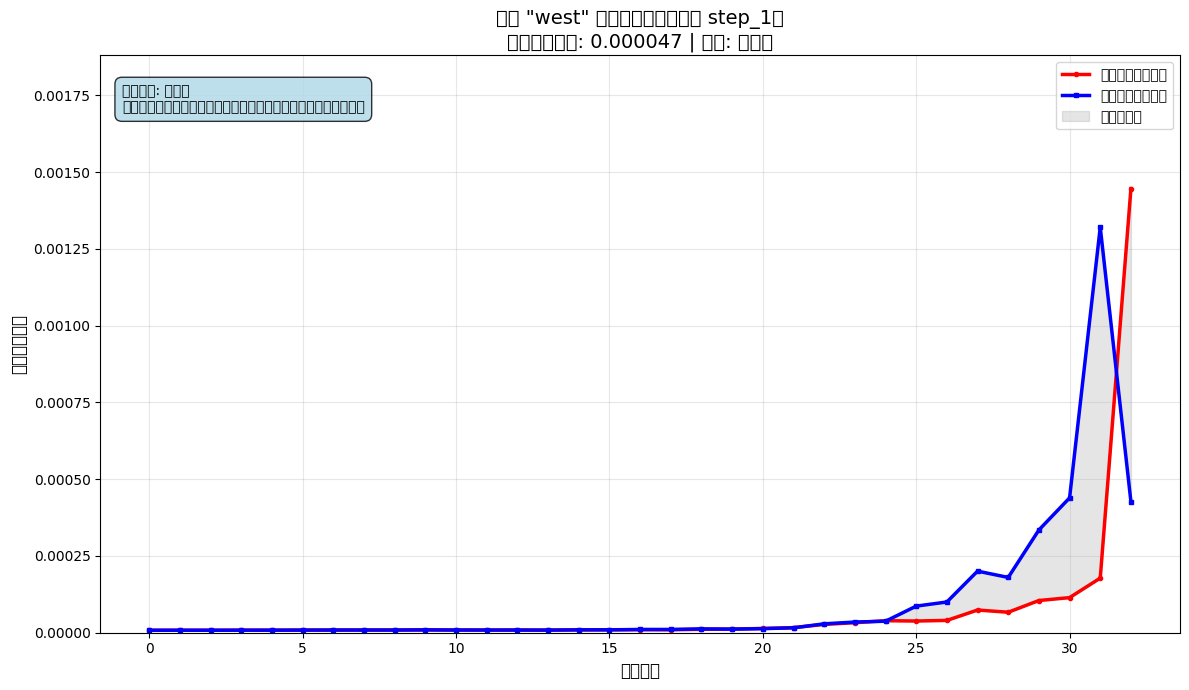

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_1_west.png

📊 分析概念: 'east'
验证问题: What direction is east?
概念token: [61601]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.013306]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000008, 0.006172]
曲线面积差: 0.00307569 (完整路径面积: 0.00430956, 跳步路径面积: 0.00738525)
归一化面积差: 0.00009320

⚖️  概念 'east' 分析结论:
   - 归一化面积差: 0.000093
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


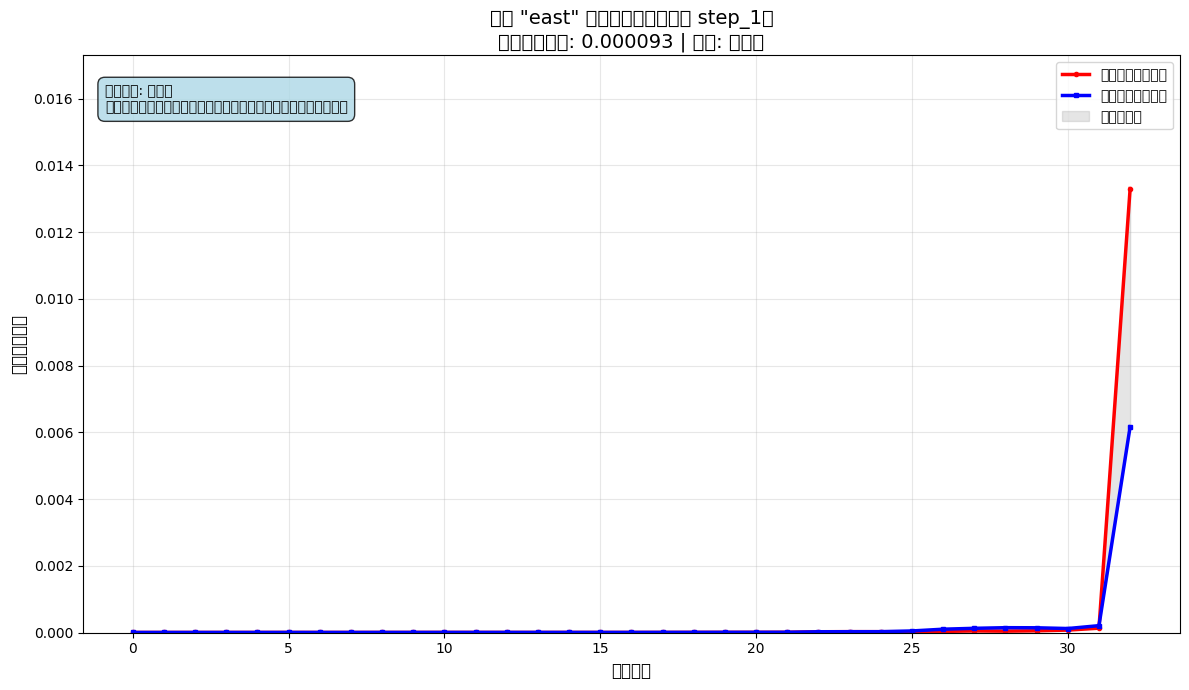

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_1_east.png

📊 分析概念: 'opposite'
验证问题: What is opposite?
概念token: [454, 13921]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 6


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 7
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000002 (完整路径面积: 0.00000003, 跳步路径面积: 0.00000001)
归一化面积差: 0.00000000

⚖️  概念 'opposite' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


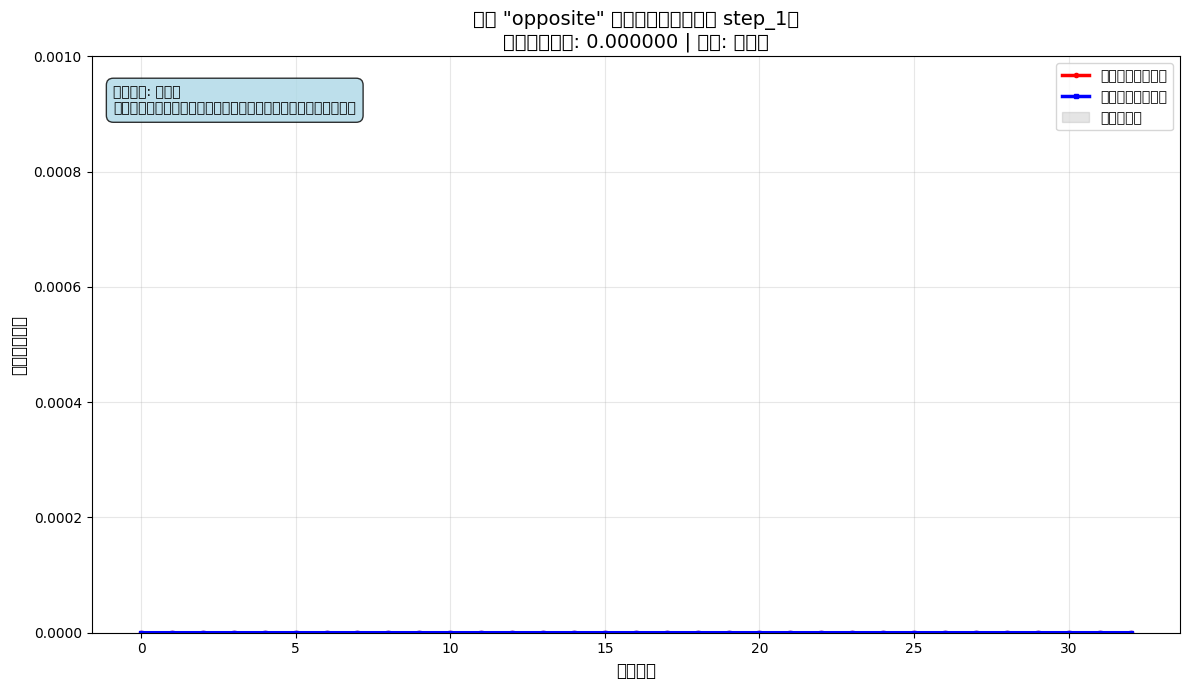

📊 双曲线对比图已保存: activation_dual_step_1_opposite.png
✅ step_1 分析完成（含基准对比+面积差分析）
✅ 测试案例 Test1 分析完成 (1/8)

分析测试案例 2/8: Test2
⚠️  无跳步结果

分析测试案例 2/8: Test3

🎯 分析跳步: step_2

🔍 分析跳步步骤: step_2
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 2: Rewrite x² – 4x as (x² – 4x + 4) – 4, add and subtract (4/2)² = 4 to com...
路径文本 2: Step 2: Rewrite x² – 4x as (x² – 4x + 4) – 4, add and subtract (4/2)² = 4 to com...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'complete the square, square of a fraction, algebraic manipulation'
解析出的概念: ['complete the square', 'square of a fraction', 'algebraic manipulation']

📊 分析概念: 'complete the square'
验证问题: What does complete the square represent?
概念token: [15079, 279, 9518]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 27
概念激活概率范围: [0.000000, 0.000002]
曲线面积差: 0.00000082 (完整路径面积: 0.00000082, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000002

⚖️  概念 'complete the square' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


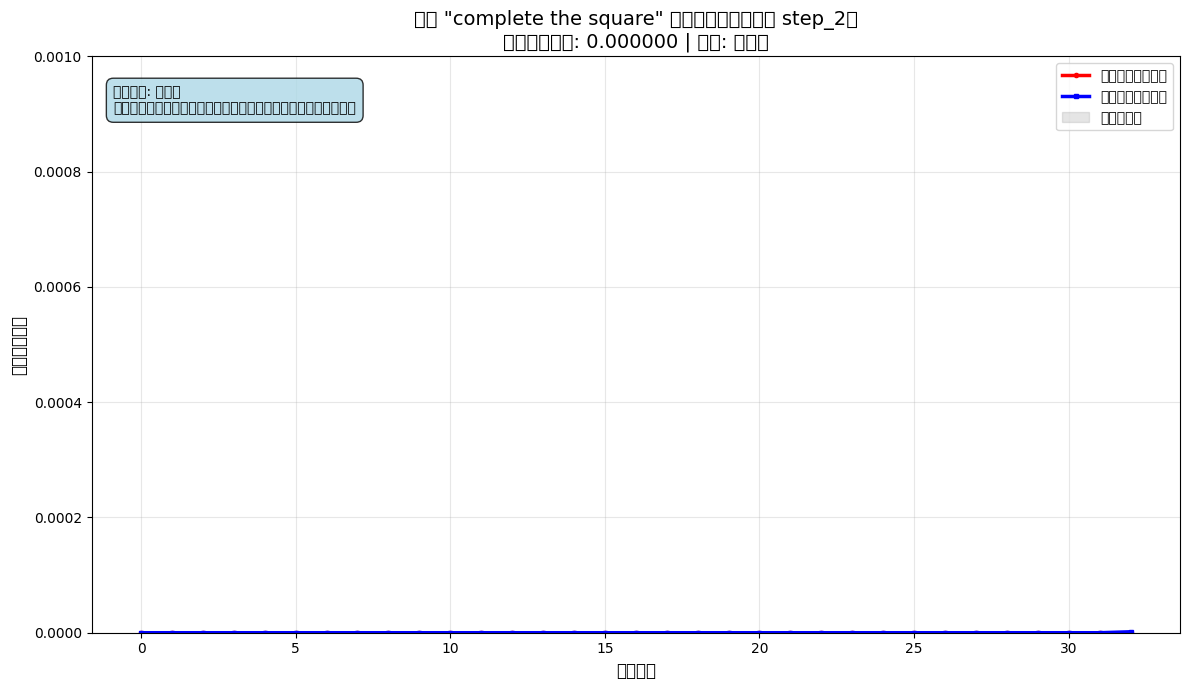

📊 双曲线对比图已保存: activation_dual_step_2_complete_the_square.png

📊 分析概念: 'square of a fraction'
验证问题: What does square of a fraction represent?
概念token: [38576, 315, 264, 19983]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'square of a fraction' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


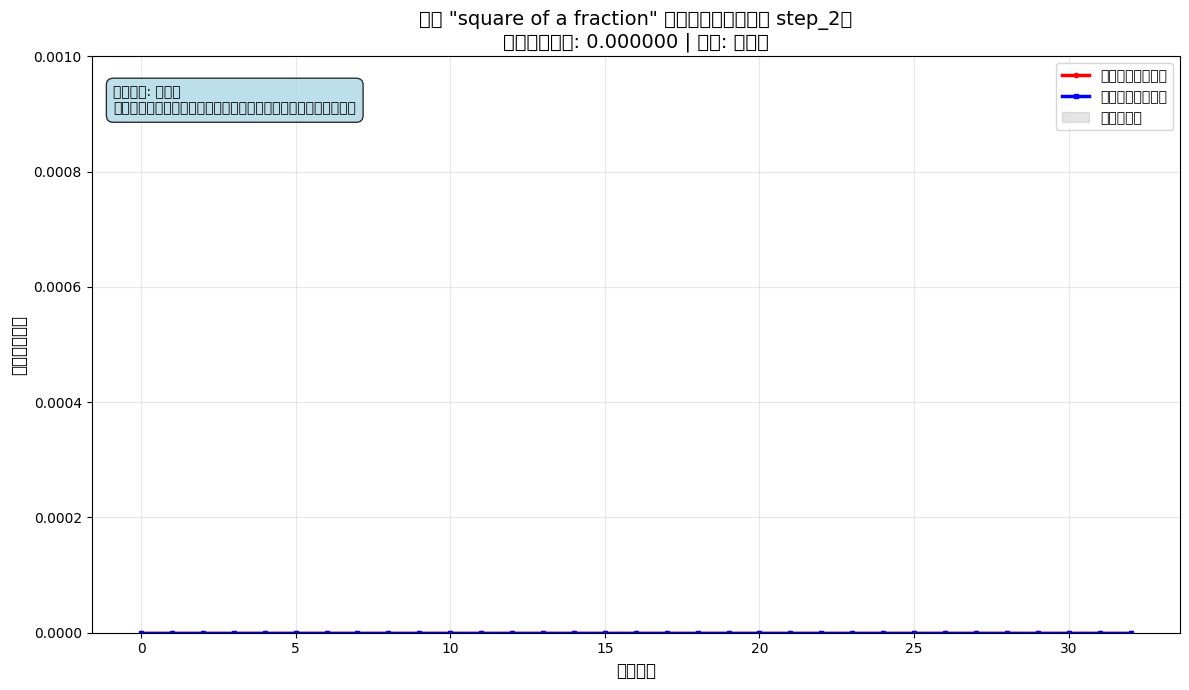

📊 双曲线对比图已保存: activation_dual_step_2_square_of_a_fraction.png

📊 分析概念: 'algebraic manipulation'
验证问题: What is algebraic manipulation?
概念token: [278, 27175, 292, 34786]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'algebraic manipulation' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


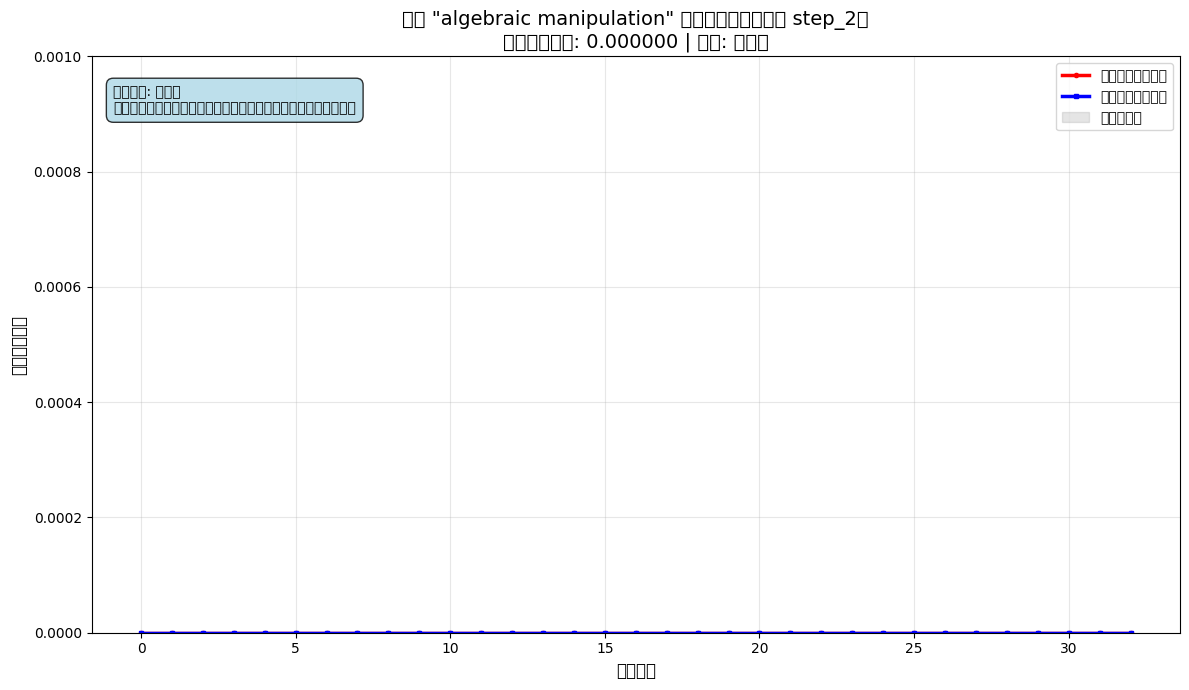

📊 双曲线对比图已保存: activation_dual_step_2_algebraic_manipulati.png
✅ step_2 分析完成（含基准对比+面积差分析）

🎯 分析跳步: step_3

🔍 分析跳步步骤: step_3
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 2: Rewrite x² – 4x as (x² – 4x + 4) – 4, add and subtract (4/2)² = 4 to com...
路径文本 2: Step 2: Rewrite x² – 4x as (x² – 4x + 4) – 4, add and subtract (4/2)² = 4....


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'complete the square, square of a fraction, algebraic manipulation'
解析出的概念: ['complete the square', 'square of a fraction', 'algebraic manipulation']

📊 分析概念: 'complete the square'
验证问题: What does complete the square represent?
概念token: [15079, 279, 9518]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 27
概念激活概率范围: [0.000000, 0.000002]
曲线面积差: 0.00000082 (完整路径面积: 0.00000082, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000002

⚖️  概念 'complete the square' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


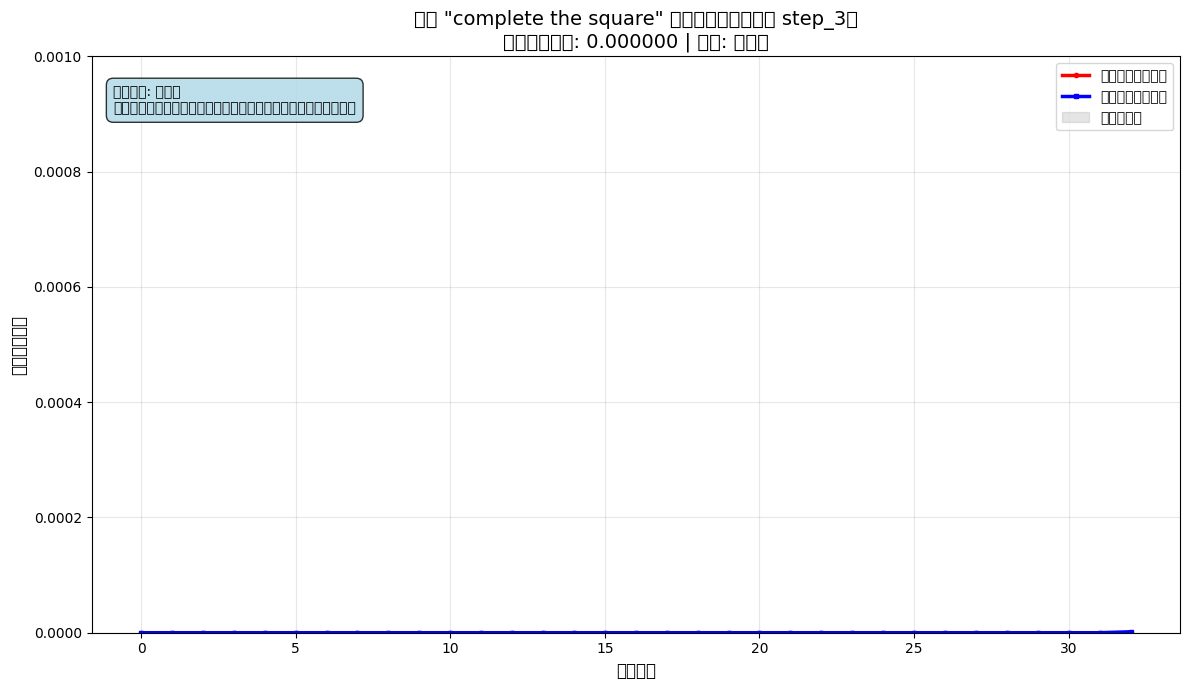

📊 双曲线对比图已保存: activation_dual_step_3_complete_the_square.png

📊 分析概念: 'square of a fraction'
验证问题: What does square of a fraction represent?
概念token: [38576, 315, 264, 19983]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'square of a fraction' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


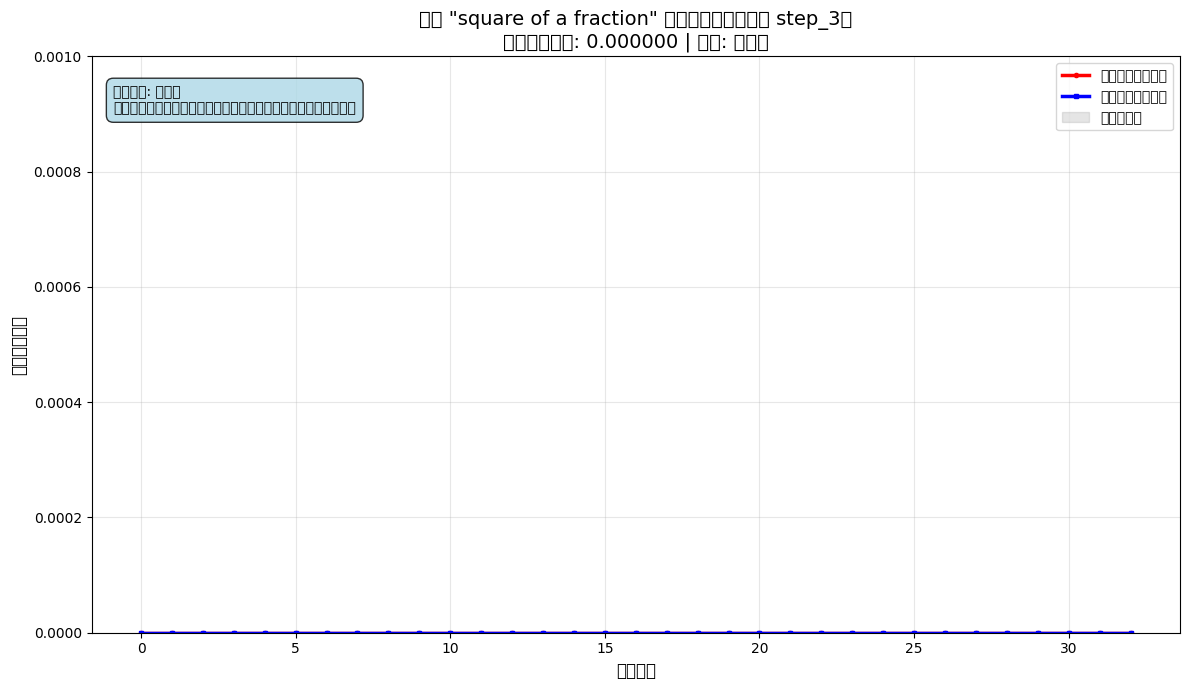

📊 双曲线对比图已保存: activation_dual_step_3_square_of_a_fraction.png

📊 分析概念: 'algebraic manipulation'
验证问题: What is algebraic manipulation?
概念token: [278, 27175, 292, 34786]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'algebraic manipulation' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


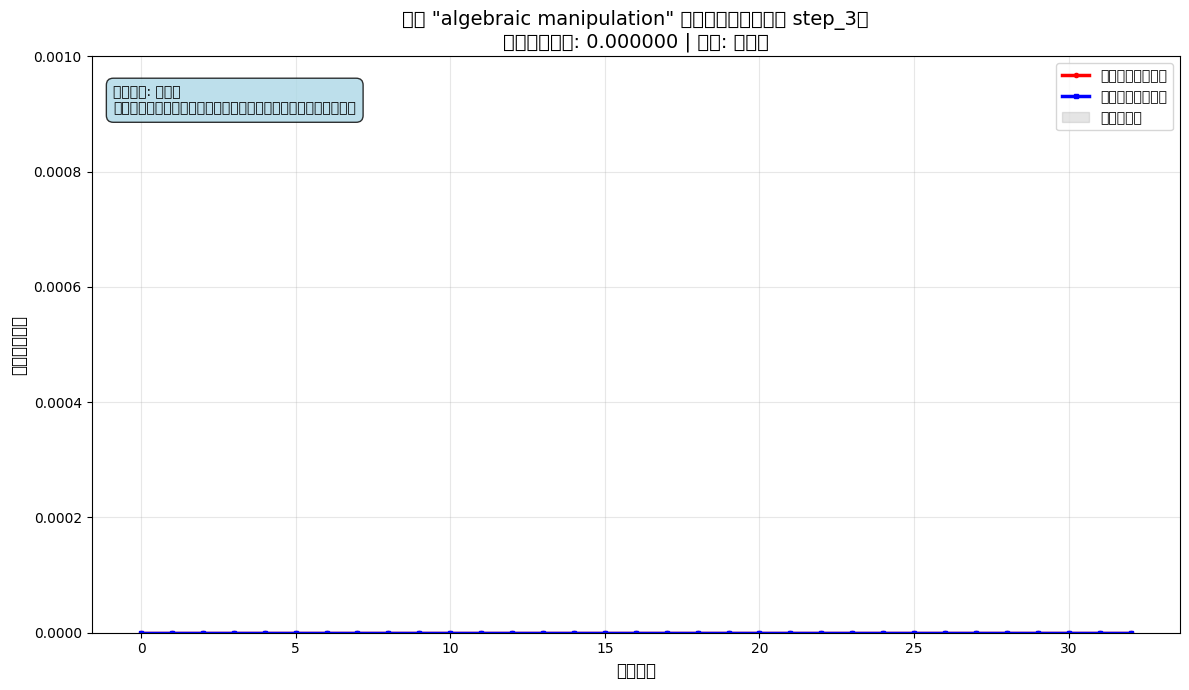

📊 双曲线对比图已保存: activation_dual_step_3_algebraic_manipulati.png
✅ step_3 分析完成（含基准对比+面积差分析）

🎯 分析跳步: step_4

🔍 分析跳步步骤: step_4
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 2: Rewrite x² – 4x as (x² – 4x + 4) – 4, adding and subtracting (4/2)² = 4 ...
路径文本 2: Step 2: Rewrite x² – 4x as (x² – 4x + 4) – 4, add and subtract (4/2)² = 4 to com...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'complete the square, adding and subtracting, square'
解析出的概念: ['complete the square', 'adding and subtracting', 'square']

📊 分析概念: 'complete the square'
验证问题: What does complete the square represent?
概念token: [15079, 279, 9518]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000002]
曲线面积差: 0.00000124 (完整路径面积: 0.00000124, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000004

⚖️  概念 'complete the square' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


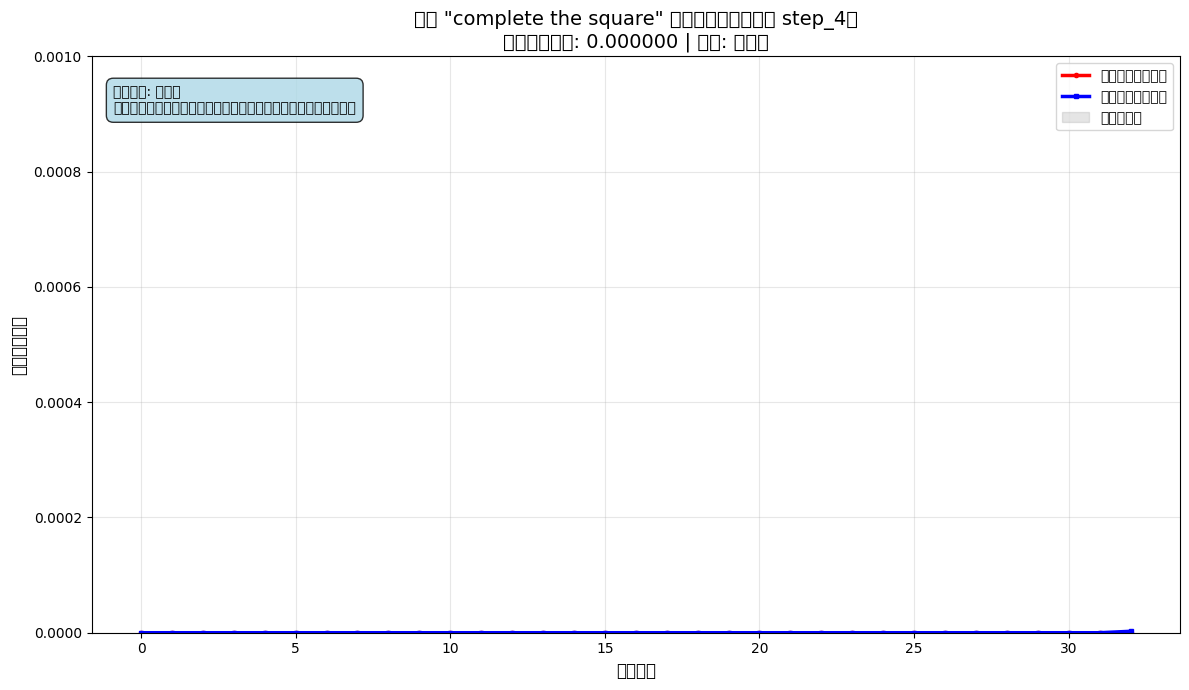

📊 双曲线对比图已保存: activation_dual_step_4_complete_the_square.png

📊 分析概念: 'adding and subtracting'
验证问题: What is adding and subtracting?
概念token: [3071, 323, 33356, 287]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 23
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000014 (完整路径面积: 0.00000014, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'adding and subtracting' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


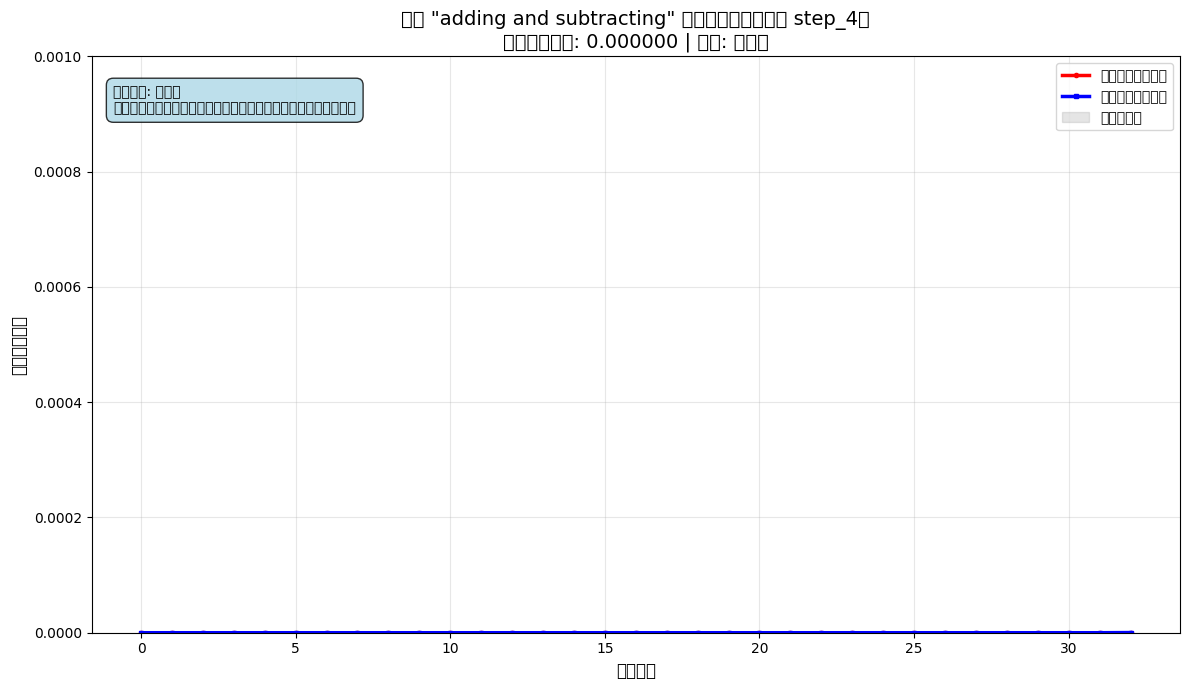

📊 双曲线对比图已保存: activation_dual_step_4_adding_and_subtracti.png

📊 分析概念: 'square'
验证问题: What does square represent?
概念token: [38576]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.000078]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 22
概念激活概率范围: [0.000008, 0.001100]
曲线面积差: 0.00046039 (完整路径面积: 0.00110713, 跳步路径面积: 0.00064674)
归一化面积差: 0.00001395

⚖️  概念 'square' 分析结论:
   - 归一化面积差: 0.000014
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


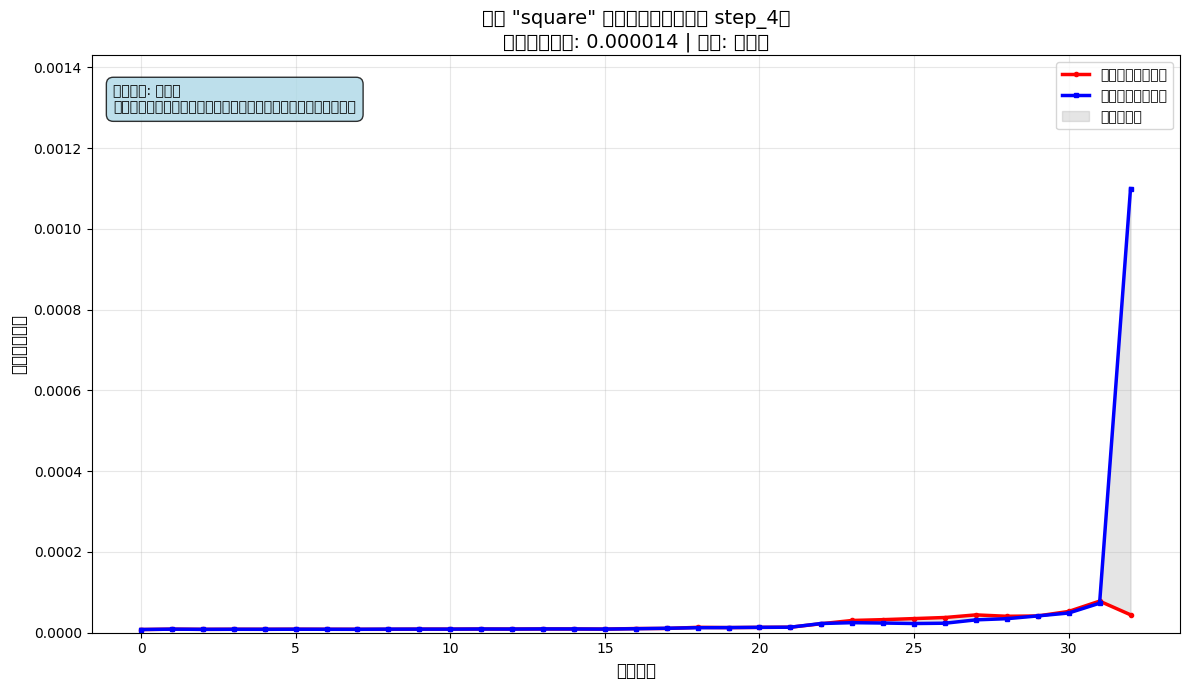

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_4_square.png
✅ step_4 分析完成（含基准对比+面积差分析）
✅ 测试案例 Test3 分析完成 (2/8)

分析测试案例 3/8: Test4

🎯 分析跳步: step_2

🔍 分析跳步步骤: step_2
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 2: Write the sum in reverse: 1³ + 2³ + 3³ +... + n³ = (n³) + (n-1)³ + (n-2)...
路径文本 2: Step 2: Write the sum in reverse: 1³ + 2³ + 3³ +... + n³ =? =?³ +... + 3³ + 2³ +...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'sum in reverse, cube, arithmetic sequence'
解析出的概念: ['sum in reverse', 'cube', 'arithmetic sequence']

📊 分析概念: 'sum in reverse'
验证问题: What is sum in reverse?
概念token: [1264, 304, 10134]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 21


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 29
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'sum in reverse' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


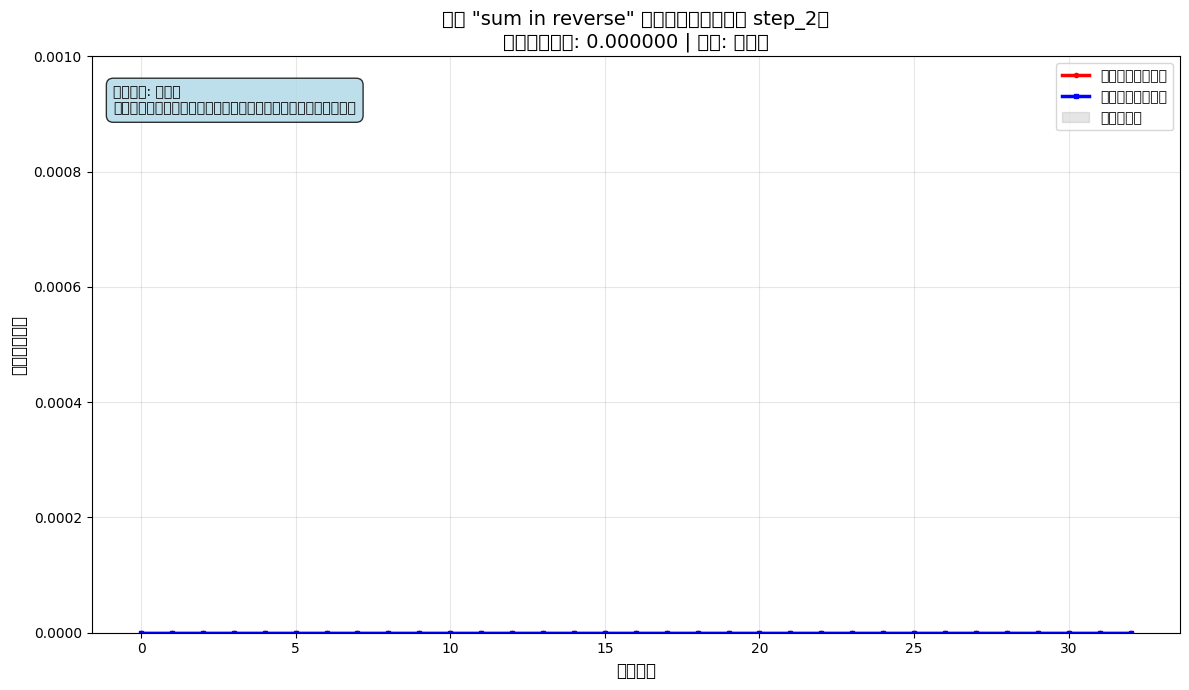

📊 双曲线对比图已保存: activation_dual_step_2_sum_in_reverse.png

📊 分析概念: 'cube'
验证问题: What is cube?
概念token: [46511]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 17


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.000099]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 26
概念激活概率范围: [0.000008, 0.000065]
曲线面积差: 0.00002962 (完整路径面积: 0.00072429, 跳步路径面积: 0.00075391)
归一化面积差: 0.00000090

⚖️  概念 'cube' 分析结论:
   - 归一化面积差: 0.000001
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


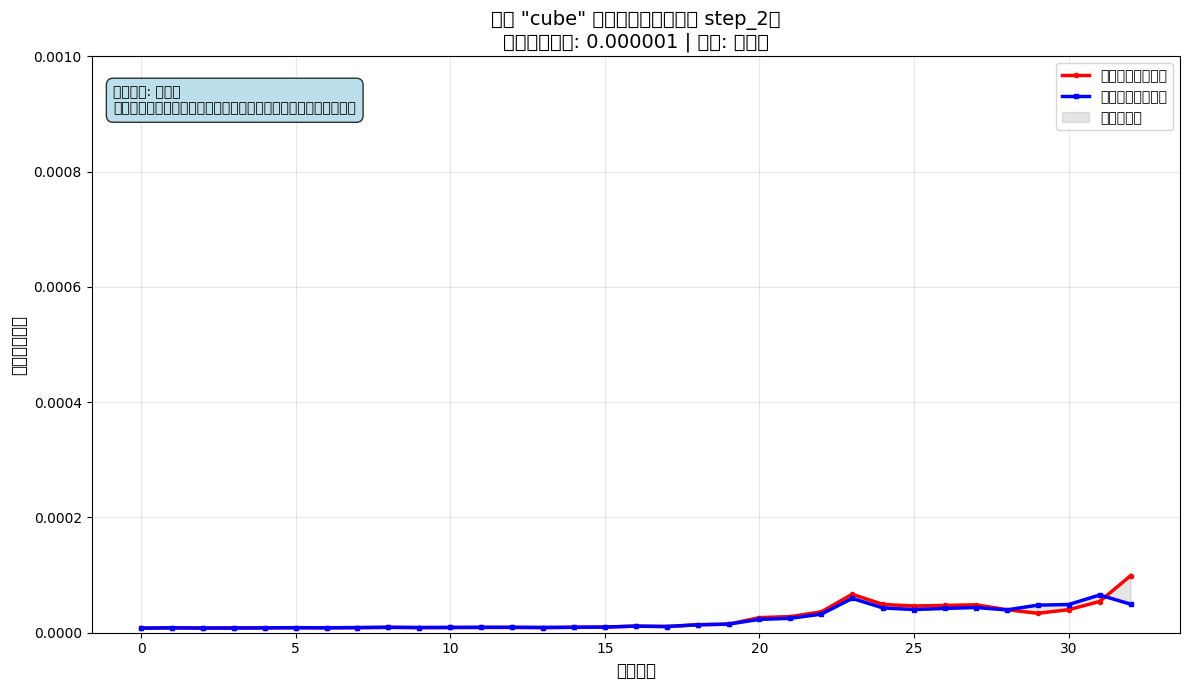

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_2_cube.png

📊 分析概念: 'arithmetic sequence'
验证问题: What is arithmetic sequence?
概念token: [277, 27011, 8668]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 28


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'arithmetic sequence' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


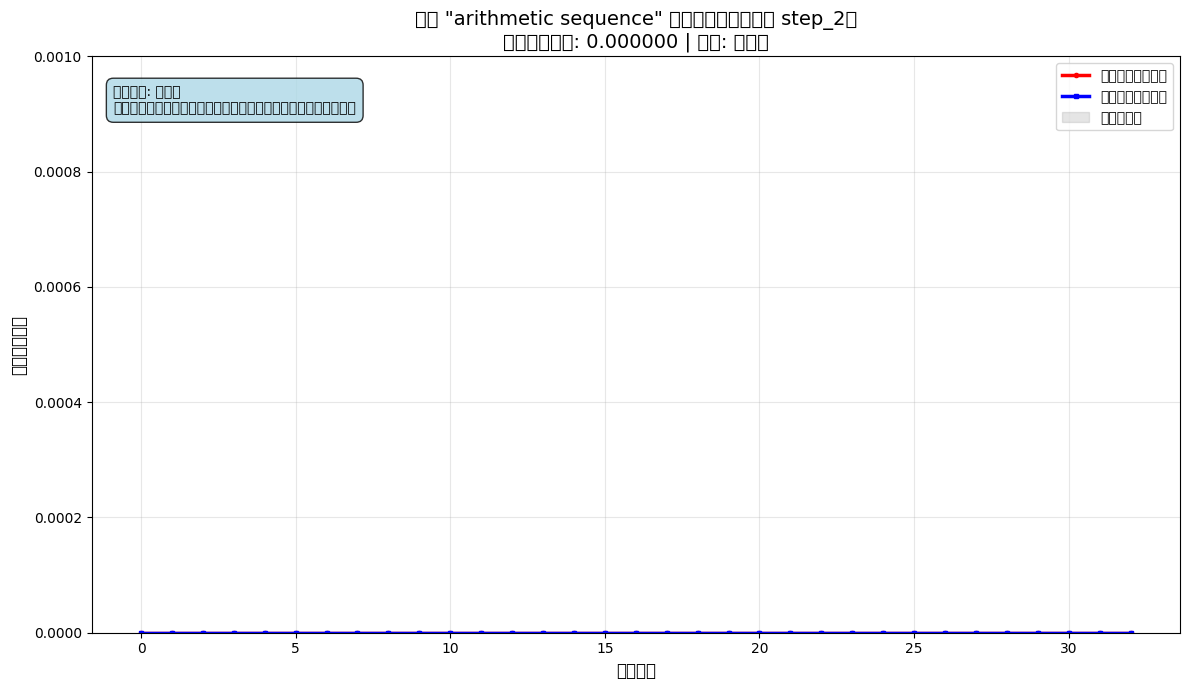

📊 双曲线对比图已保存: activation_dual_step_2_arithmetic_sequence.png
✅ step_2 分析完成（含基准对比+面积差分析）

🎯 分析跳步: step_3

🔍 分析跳步步骤: step_3
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 2: Write the sum in reverse: 1³ + 2³ + 3³ +... + n³ =?...
路径文本 2: Step 2: Write the sum in reverse: 1³ + 2³ + 3³ +... + n³ = (n³ + (n-1)³ +... + 3...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'sum, reverse, cubes'
解析出的概念: ['sum', 'reverse', 'cubes']

📊 分析概念: 'sum'
验证问题: What is sum?
概念token: [1264]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 17


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.001162]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000008, 0.000513]
曲线面积差: 0.00004384 (完整路径面积: 0.00181991, 跳步路径面积: 0.00186375)
归一化面积差: 0.00000133

⚖️  概念 'sum' 分析结论:
   - 归一化面积差: 0.000001
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


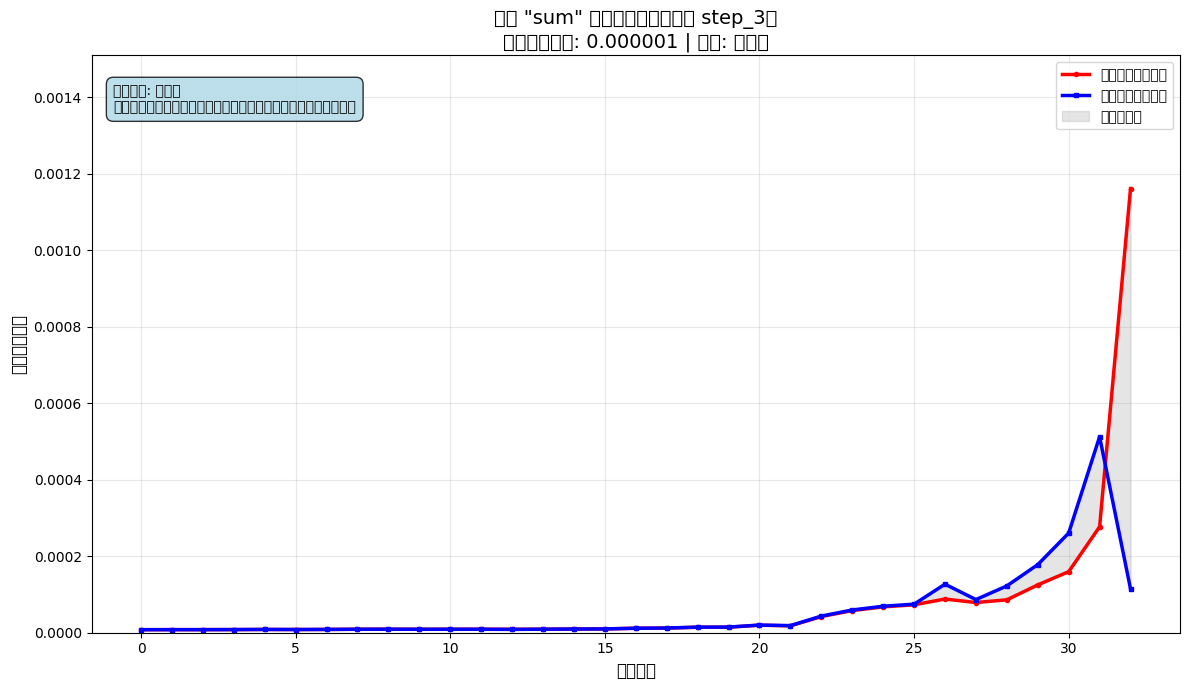

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_3_sum.png

📊 分析概念: 'reverse'
验证问题: What is reverse?
概念token: [26992]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.001250]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000008, 0.000111]
曲线面积差: 0.00077435 (完整路径面积: 0.00094053, 跳步路径面积: 0.00171489)
归一化面积差: 0.00002347

⚖️  概念 'reverse' 分析结论:
   - 归一化面积差: 0.000023
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


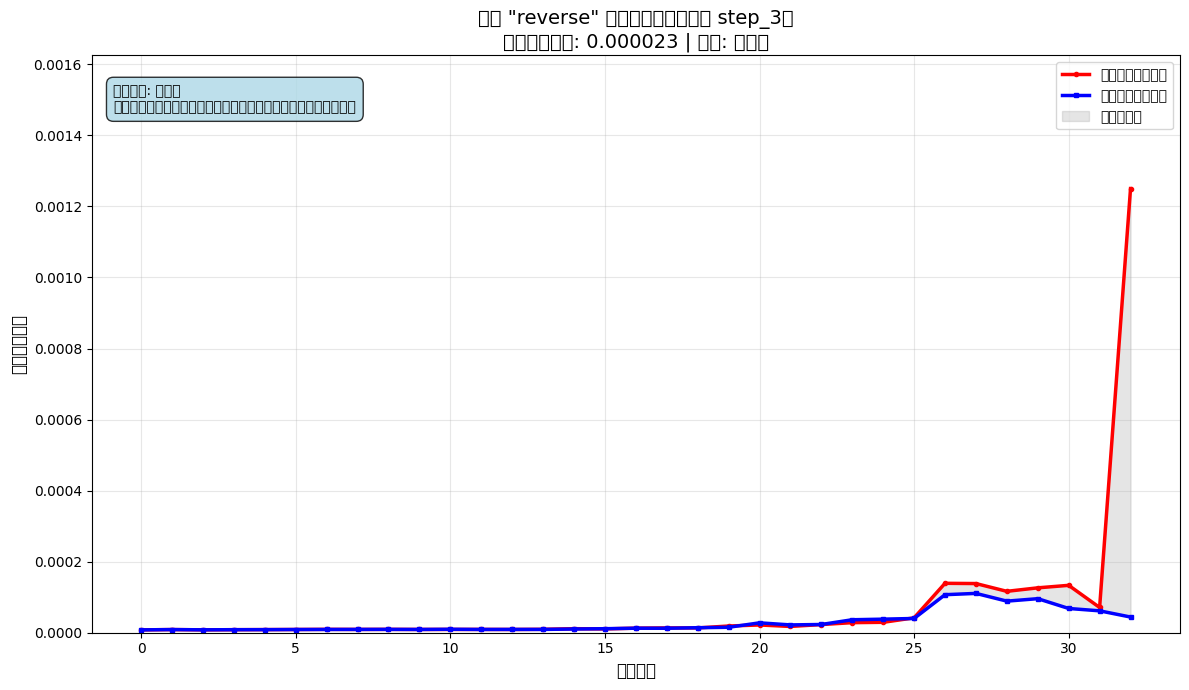

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_3_reverse.png

📊 分析概念: 'cubes'
验证问题: What is cubes?
概念token: [66, 51725]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000001, 跳步路径面积: 0.00000001)
归一化面积差: 0.00000000

⚖️  概念 'cubes' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


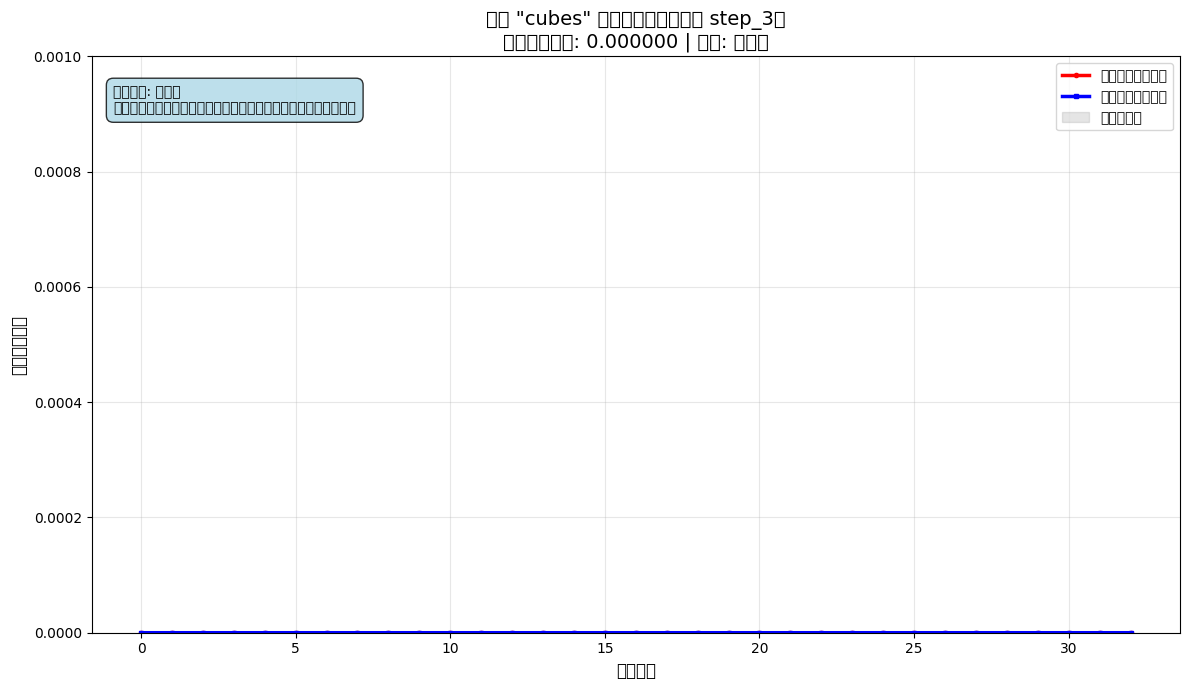

📊 双曲线对比图已保存: activation_dual_step_3_cubes.png
✅ step_3 分析完成（含基准对比+面积差分析）

🎯 分析跳步: step_5

🔍 分析跳步步骤: step_5
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 2: Write the sum in reverse: 1³ + 2³ + 3³ +... + n³ =?³ + (n-1)³ +... + 3³ ...
路径文本 2: Step 2: Write the sum in reverse: 1³ + 2³ + 3³ +... + n³ =? Write the sum in rev...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'sum in reverse, cube, arithmetic sequence'
解析出的概念: ['sum in reverse', 'cube', 'arithmetic sequence']

📊 分析概念: 'sum in reverse'
验证问题: What is sum in reverse?
概念token: [1264, 304, 10134]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'sum in reverse' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


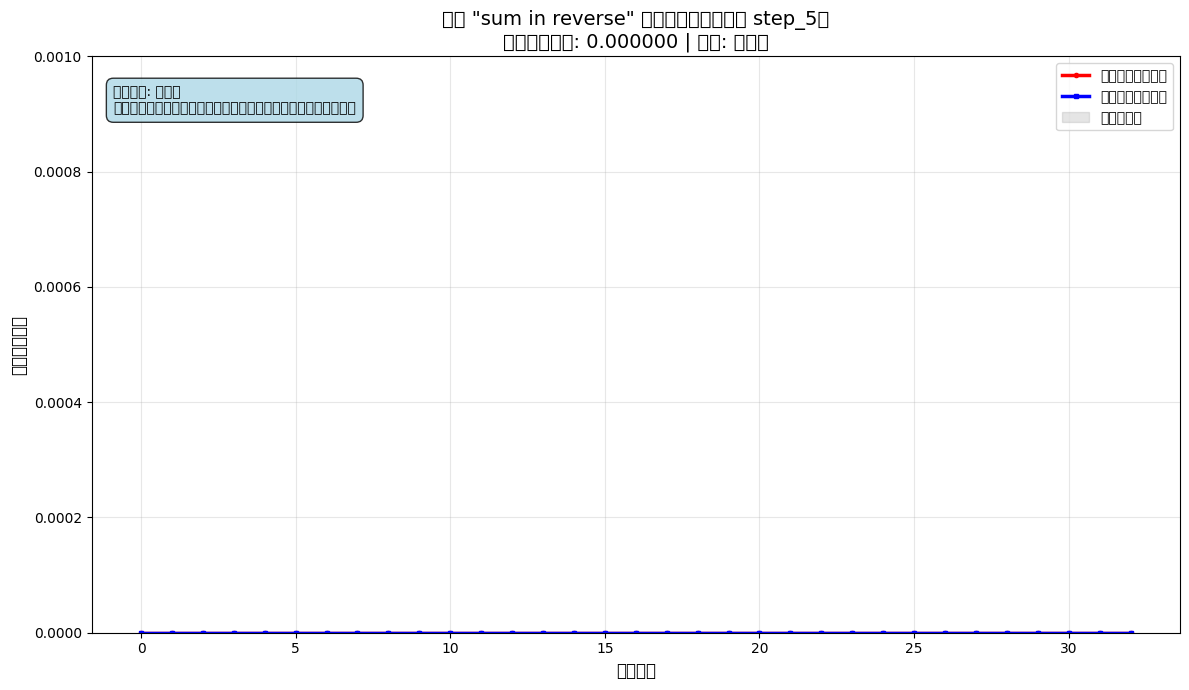

📊 双曲线对比图已保存: activation_dual_step_5_sum_in_reverse.png

📊 分析概念: 'cube'
验证问题: What is cube?
概念token: [46511]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 12


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.000178]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000008, 0.000066]
曲线面积差: 0.00002792 (完整路径面积: 0.00071967, 跳步路径面积: 0.00074759)
归一化面积差: 0.00000085

⚖️  概念 'cube' 分析结论:
   - 归一化面积差: 0.000001
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


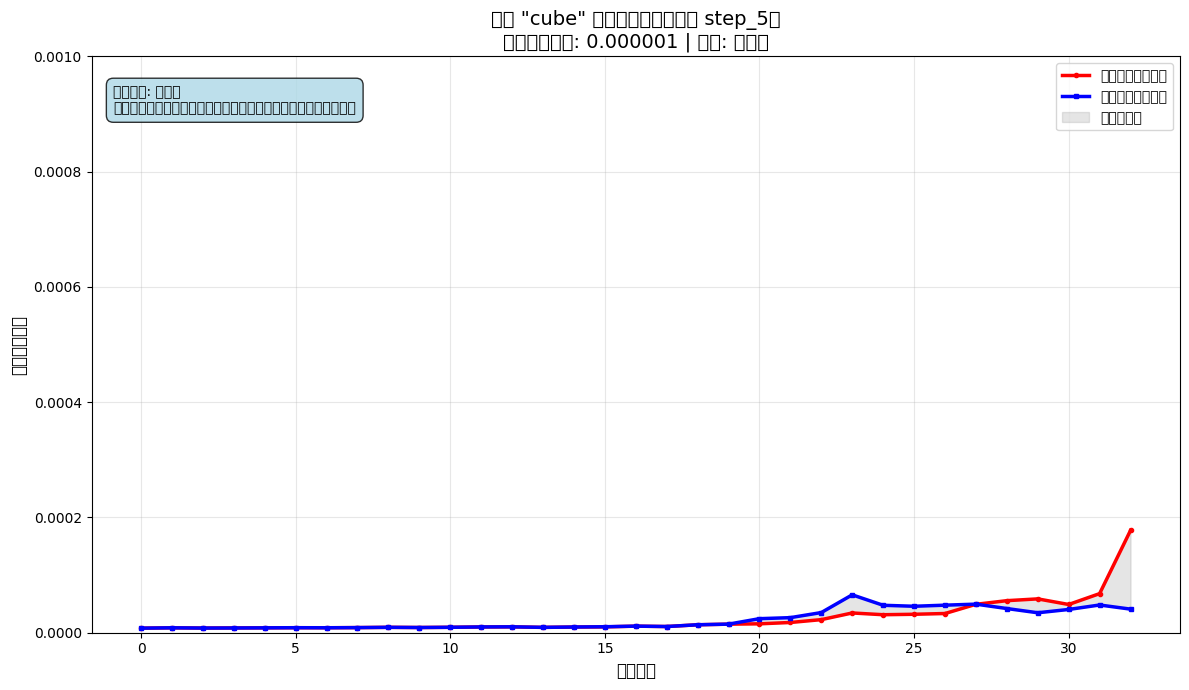

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_5_cube.png

📊 分析概念: 'arithmetic sequence'
验证问题: What is arithmetic sequence?
概念token: [277, 27011, 8668]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 28


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'arithmetic sequence' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


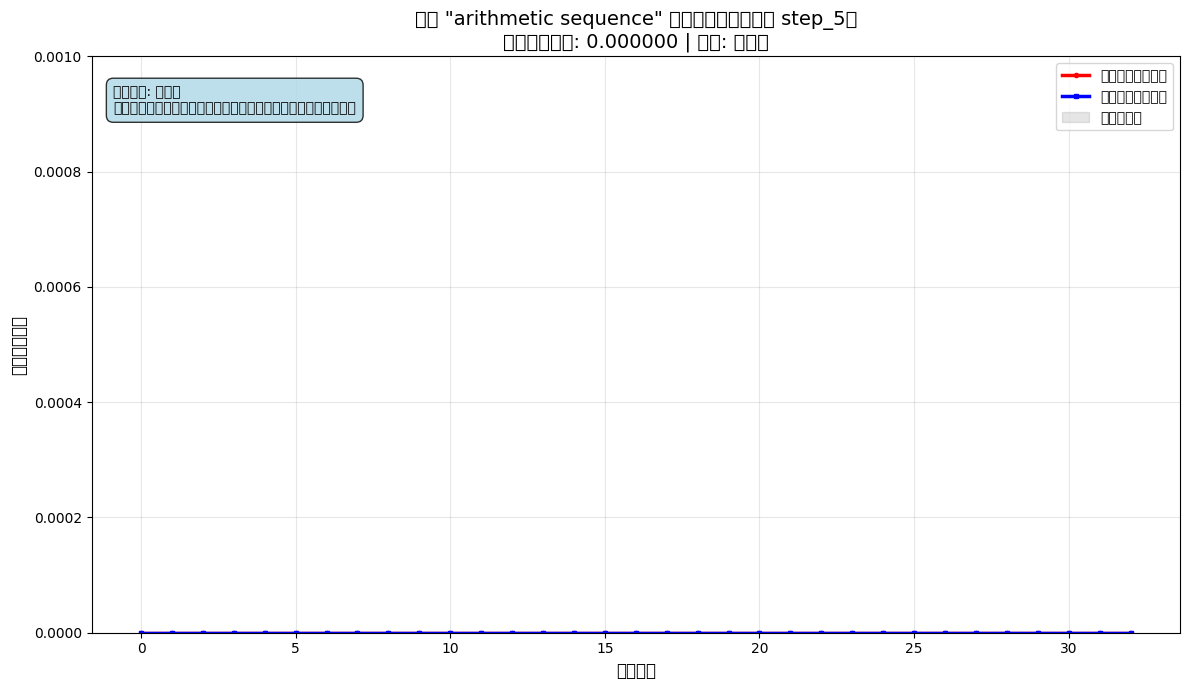

📊 双曲线对比图已保存: activation_dual_step_5_arithmetic_sequence.png
✅ step_5 分析完成（含基准对比+面积差分析）

🎯 分析跳步: step_6

🔍 分析跳步步骤: step_6
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 2: Write the sum in reverse: 1³ + 2³ + 3³ +... + n³ =? → n³ + (n-1)³ + (n-2...
路径文本 2: Step 2: Write the sum in reverse: 1³ + 2³ + 3³ +... + n³ = (n³ + (n-1)³ +... + 3...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'n³, sum, reverse'
解析出的概念: ['n³', 'sum', 'reverse']

📊 分析概念: 'n³'
验证问题: What is n³?
概念token: [77, 44301]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000190]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.001400]
曲线面积差: 0.00060523 (完整路径面积: 0.00070062, 跳步路径面积: 0.00009538)
归一化面积差: 0.00001834

⚖️  概念 'n³' 分析结论:
   - 归一化面积差: 0.000018
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


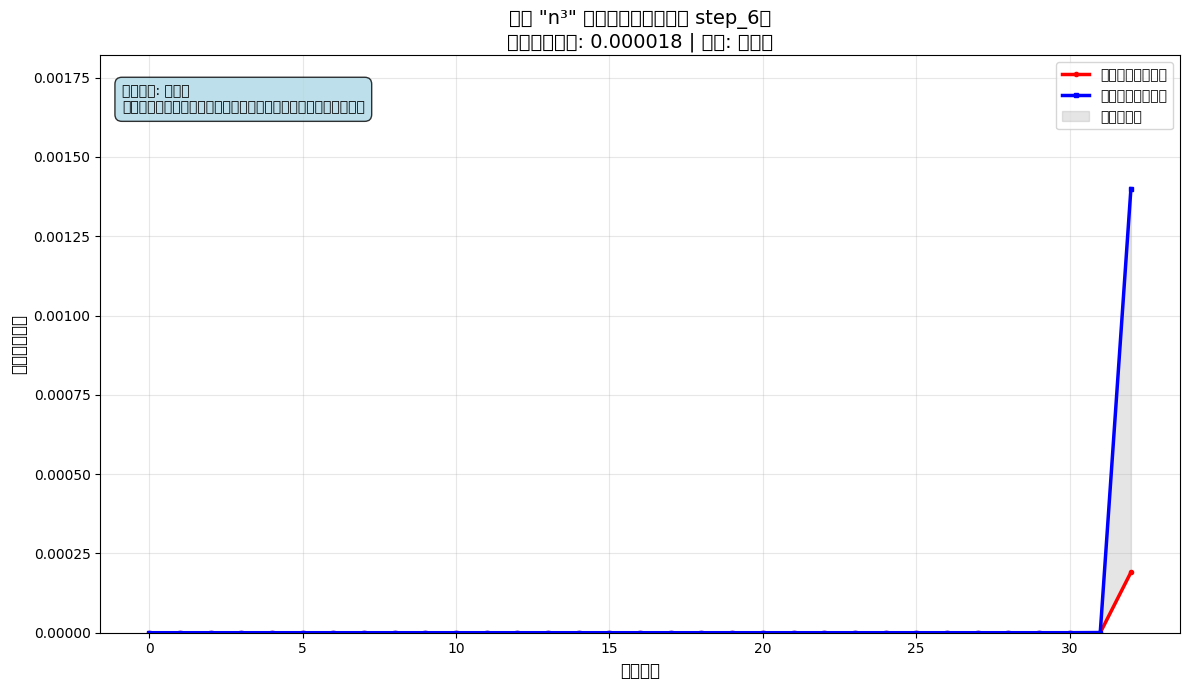

📊 双曲线对比图已保存: activation_dual_step_6_n³.png

📊 分析概念: 'sum'
验证问题: What is sum?
概念token: [1264]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 17


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.001162]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000008, 0.000380]
曲线面积差: 0.00034282 (完整路径面积: 0.00152093, 跳步路径面积: 0.00186375)
归一化面积差: 0.00001039

⚖️  概念 'sum' 分析结论:
   - 归一化面积差: 0.000010
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


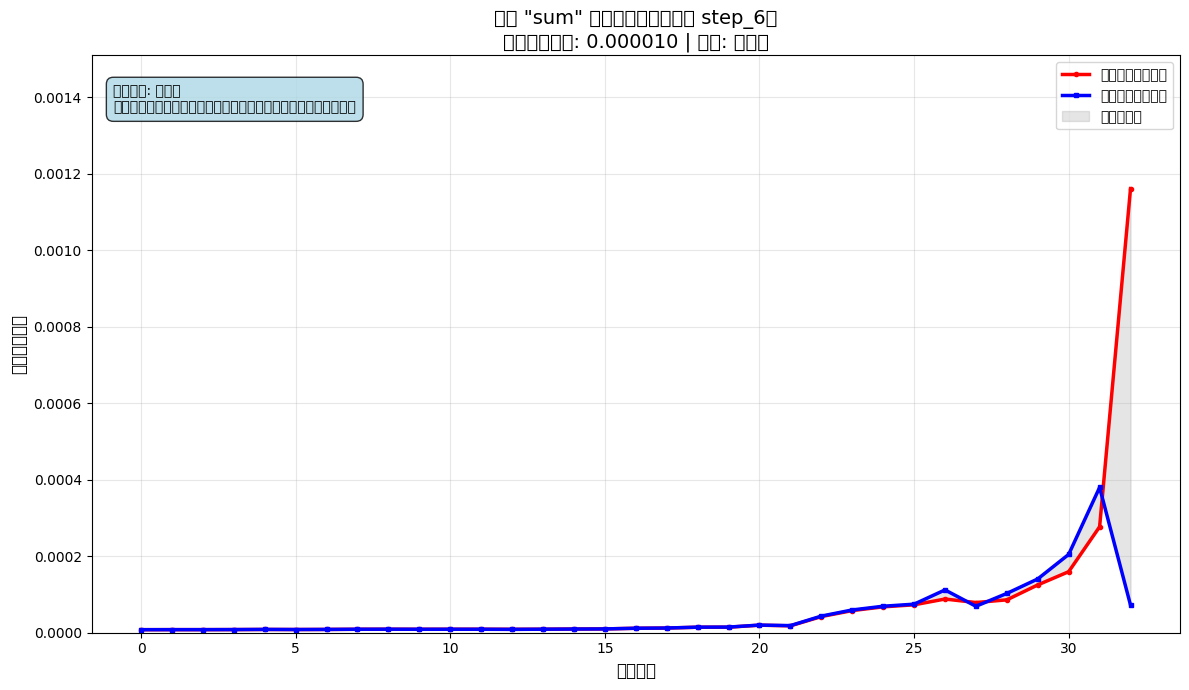

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_6_sum.png

📊 分析概念: 'reverse'
验证问题: What is reverse?
概念token: [26992]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.001250]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000008, 0.000199]
曲线面积差: 0.00079602 (完整路径面积: 0.00091887, 跳步路径面积: 0.00171489)
归一化面积差: 0.00002412

⚖️  概念 'reverse' 分析结论:
   - 归一化面积差: 0.000024
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


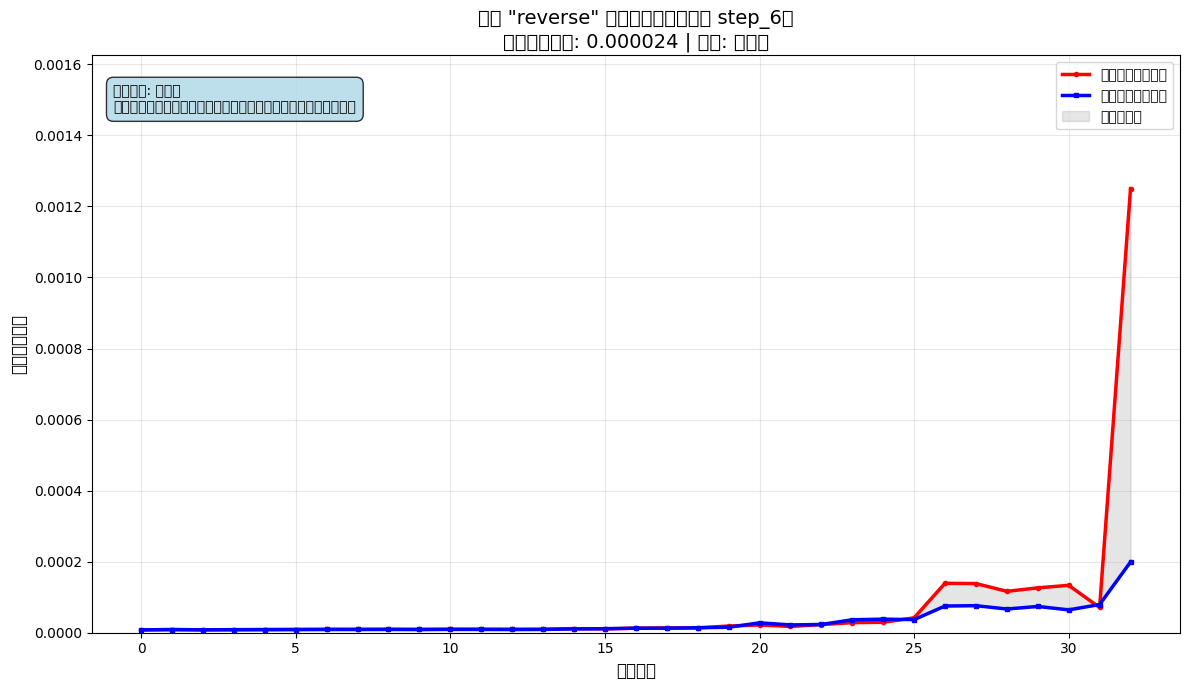

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_6_reverse.png
✅ step_6 分析完成（含基准对比+面积差分析）

🎯 分析跳步: step_7

🔍 分析跳步步骤: step_7
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 2: Write the sum in reverse, i.e., 1³ + 2³ + 3³ +... + n³ = (n³) + (n-1)³ +...
路径文本 2: Step 2: Write the sum in reverse, i.e., Tₙ = n(n+1)/2 = (n+1)n/2....


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'sum in reverse, n³, 1³'
解析出的概念: ['sum in reverse', 'n³', '1³']

📊 分析概念: 'sum in reverse'
验证问题: What is sum in reverse?
概念token: [1264, 304, 10134]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'sum in reverse' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


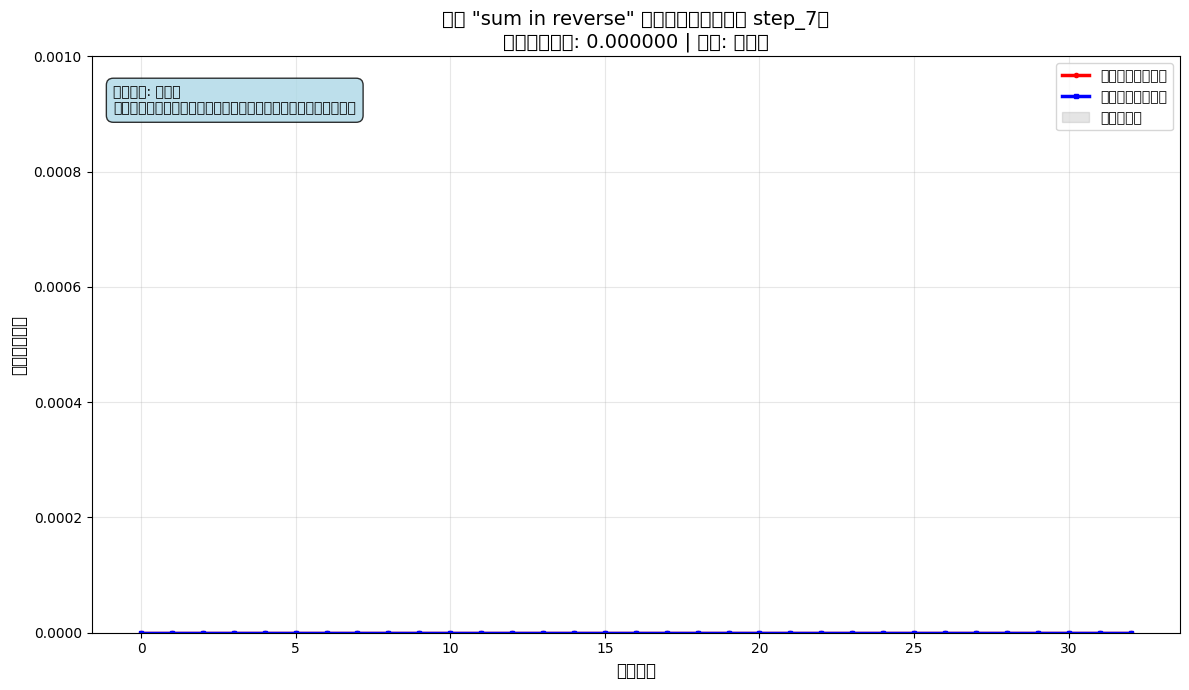

📊 双曲线对比图已保存: activation_dual_step_7_sum_in_reverse.png

📊 分析概念: 'n³'
验证问题: What is n³?
概念token: [77, 44301]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000190]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.030950]
曲线面积差: 0.01538004 (完整路径面积: 0.01547542, 跳步路径面积: 0.00009538)
归一化面积差: 0.00046606

⚖️  概念 'n³' 分析结论:
   - 归一化面积差: 0.000466
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


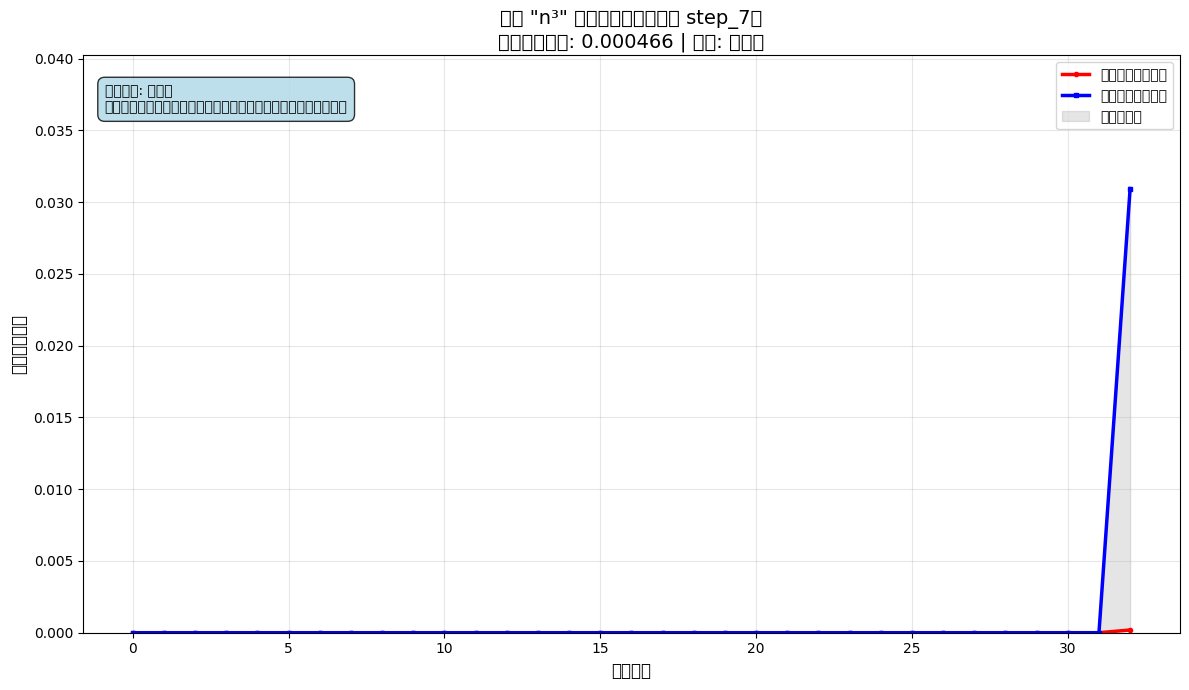

📊 双曲线对比图已保存: activation_dual_step_7_n³.png

📊 分析概念: '1³'
验证问题: What is 1³?
概念token: [16, 44301]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 13


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.330427]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.882863]
曲线面积差: 0.27621861 (完整路径面积: 0.44143222, 跳步路径面积: 0.16521361)
归一化面积差: 0.00837026

⚖️  概念 '1³' 分析结论:
   - 归一化面积差: 0.008370
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


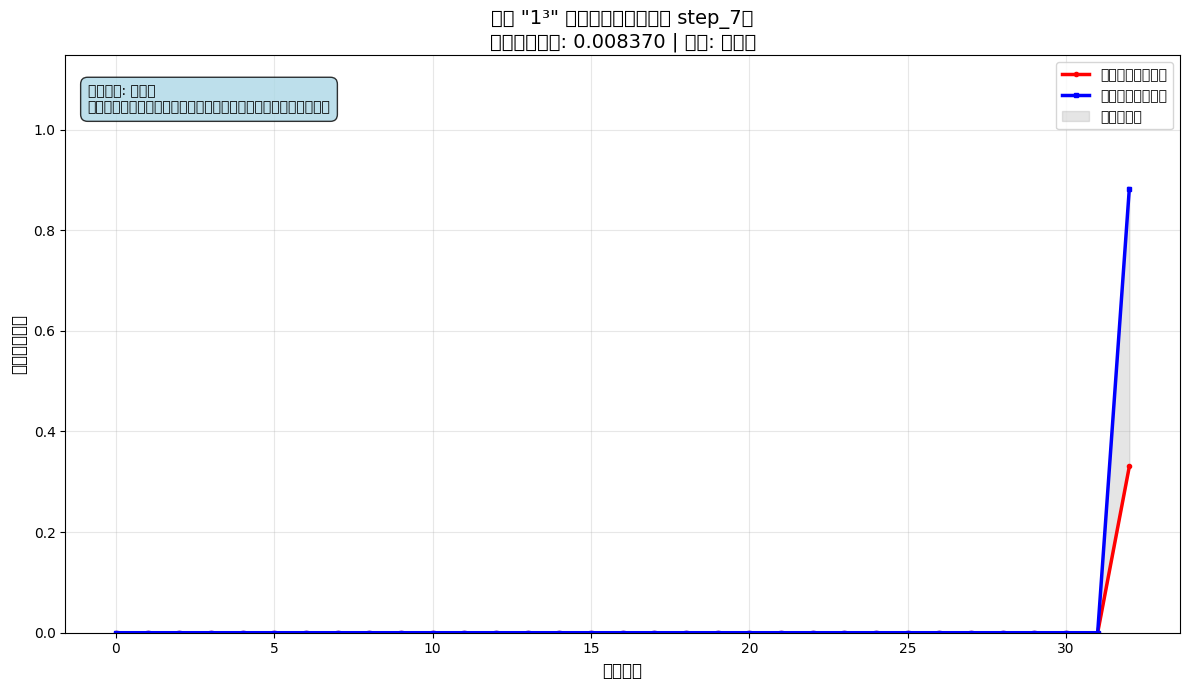

📊 双曲线对比图已保存: activation_dual_step_7_1³.png
✅ step_7 分析完成（含基准对比+面积差分析）
✅ 测试案例 Test4 分析完成 (3/8)

分析测试案例 4/8: Test5
⚠️  无跳步结果

分析测试案例 4/8: Test6

🎯 分析跳步: step_1

🔍 分析跳步步骤: step_1
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 1: Identify the state corresponding to the capital Montgomery, which is Ala...
路径文本 2: Step 1: Identify the state corresponding to the capital Montgomery....


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'Alabama, Montgomery, capital'
解析出的概念: ['Alabama', 'Montgomery', 'capital']

📊 分析概念: 'Alabama'
验证问题: What is Alabama?
概念token: [98911]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 6


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.851074]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 3
概念激活概率范围: [0.000008, 0.720703]
曲线面积差: 0.06494719 (完整路径面积: 0.36129817, 跳步路径面积: 0.42624536)
归一化面积差: 0.00196810

⚖️  概念 'Alabama' 分析结论:
   - 归一化面积差: 0.001968
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


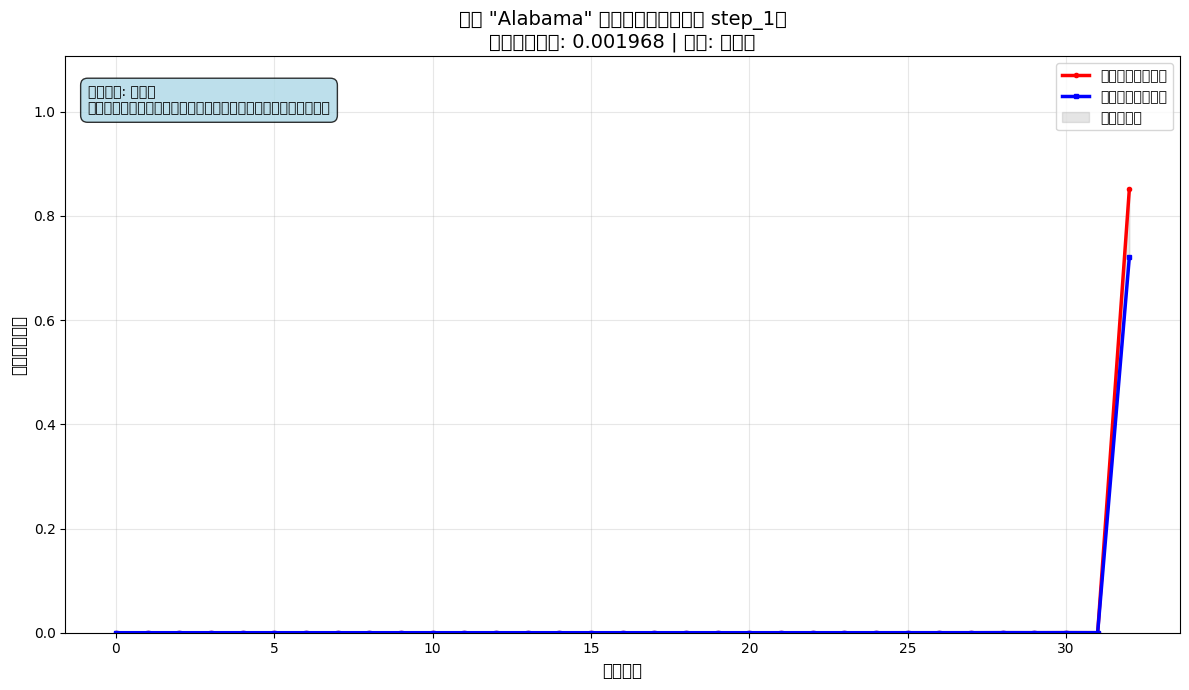

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_1_Alabama.png

📊 分析概念: 'Montgomery'
验证问题: What is Montgomery?
概念token: [35515, 39330]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 20
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000001 (完整路径面积: 0.00000002, 跳步路径面积: 0.00000001)
归一化面积差: 0.00000000

⚖️  概念 'Montgomery' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


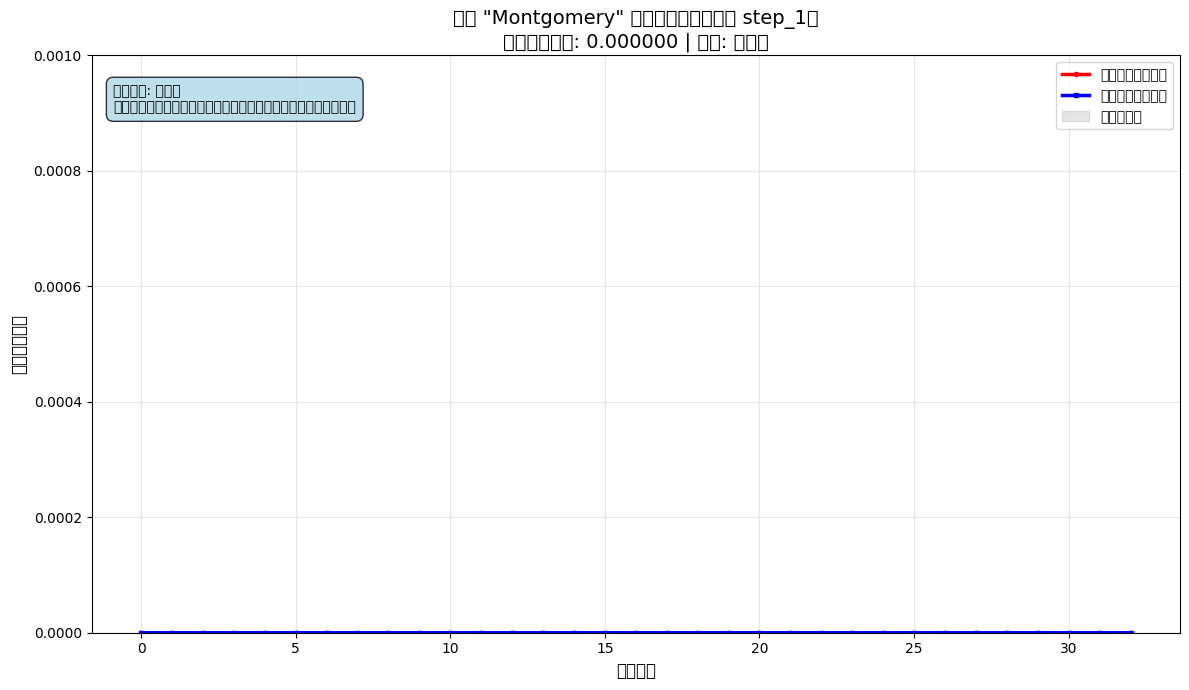

📊 双曲线对比图已保存: activation_dual_step_1_Montgomery.png

📊 分析概念: 'capital'
验证问题: What is capital?
概念token: [66163]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.000100]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 2
概念激活概率范围: [0.000008, 0.000260]
曲线面积差: 0.00021705 (完整路径面积: 0.00075069, 跳步路径面积: 0.00053364)
归一化面积差: 0.00000658

⚖️  概念 'capital' 分析结论:
   - 归一化面积差: 0.000007
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


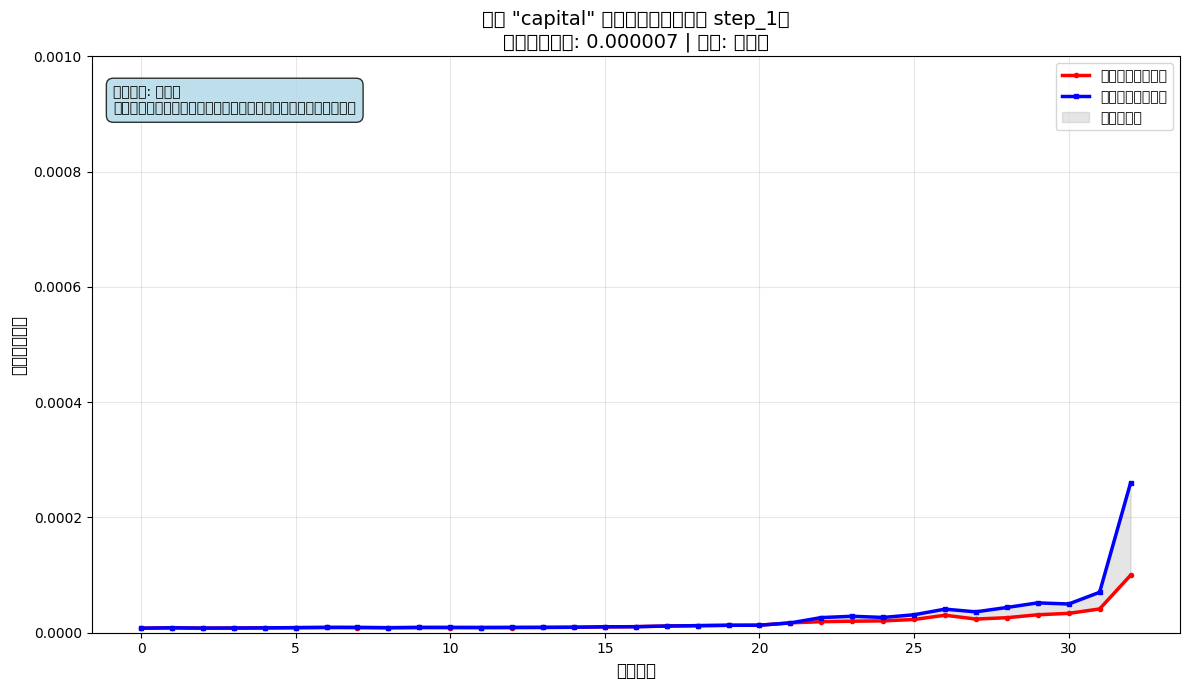

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_1_capital.png
✅ step_1 分析完成（含基准对比+面积差分析）
✅ 测试案例 Test6 分析完成 (4/8)

分析测试案例 5/8: Test7

🎯 分析跳步: step_1

🔍 分析跳步步骤: step_1
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 1: 85 = 5 × 17...
路径文本 2: Step 1: Factor 85 into prime factors: 85 = 5 × 17...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: '5, 17, multiplication'
解析出的概念: ['5', '17', 'multiplication']

📊 分析概念: '5'
验证问题: What is 5?
概念token: [20]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.232544]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000008, 1.000000]
曲线面积差: 0.39038134 (完整路径面积: 0.50805894, 跳步路径面积: 0.11767760)
归一化面积差: 0.01182974

⚖️  概念 '5' 分析结论:
   - 归一化面积差: 0.011830
   - 证据强度: 弱证据
   - 解读: 模型在跳步时可能隐式推理该概念（激活模式部分一致）


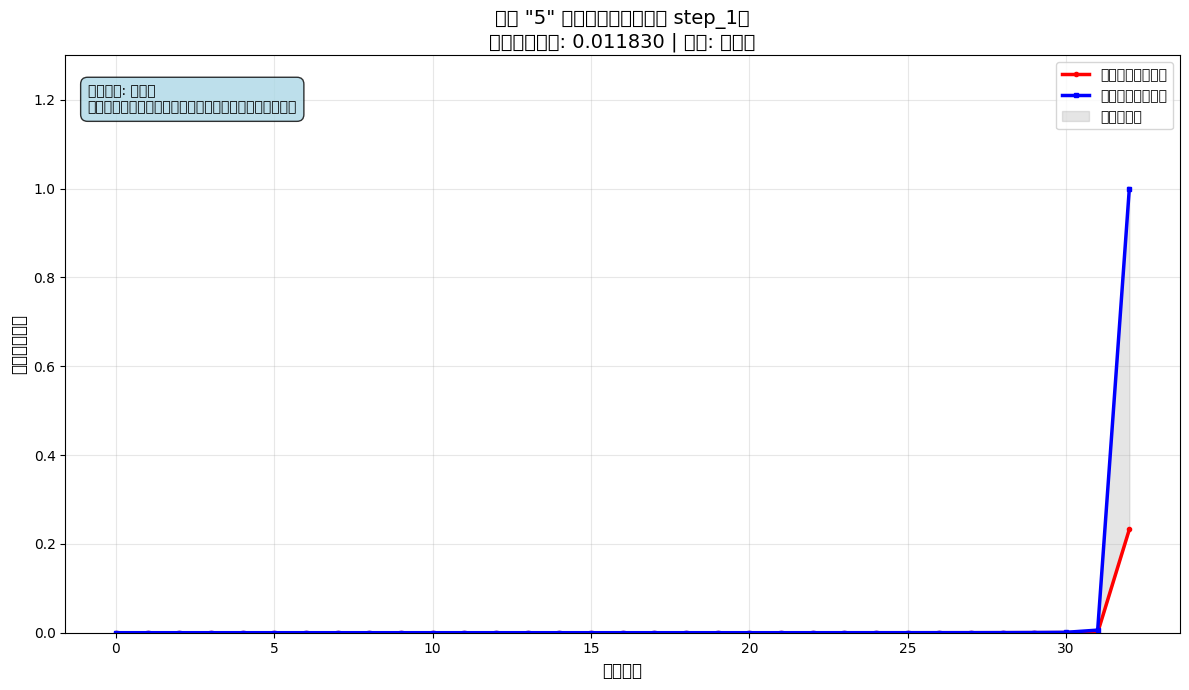

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_1_5.png

📊 分析概念: '17'
验证问题: What is 17?
概念token: [1114]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.050873]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000008, 0.999512]
曲线面积差: 0.47772676 (完整路径面积: 0.50433758, 跳步路径面积: 0.02661082)
归一化面积差: 0.01447657

⚖️  概念 '17' 分析结论:
   - 归一化面积差: 0.014477
   - 证据强度: 弱证据
   - 解读: 模型在跳步时可能隐式推理该概念（激活模式部分一致）


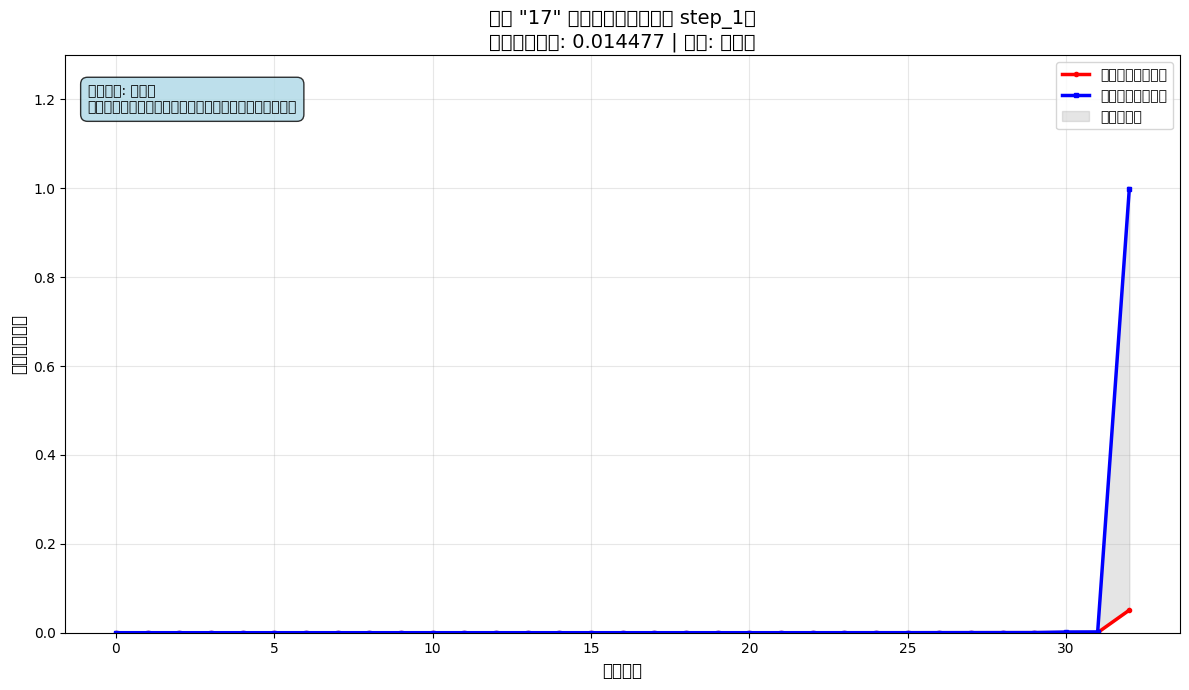

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_1_17.png

📊 分析概念: 'multiplication'
验证问题: What is multiplication?
概念token: [79076, 1728]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 30


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000000, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'multiplication' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


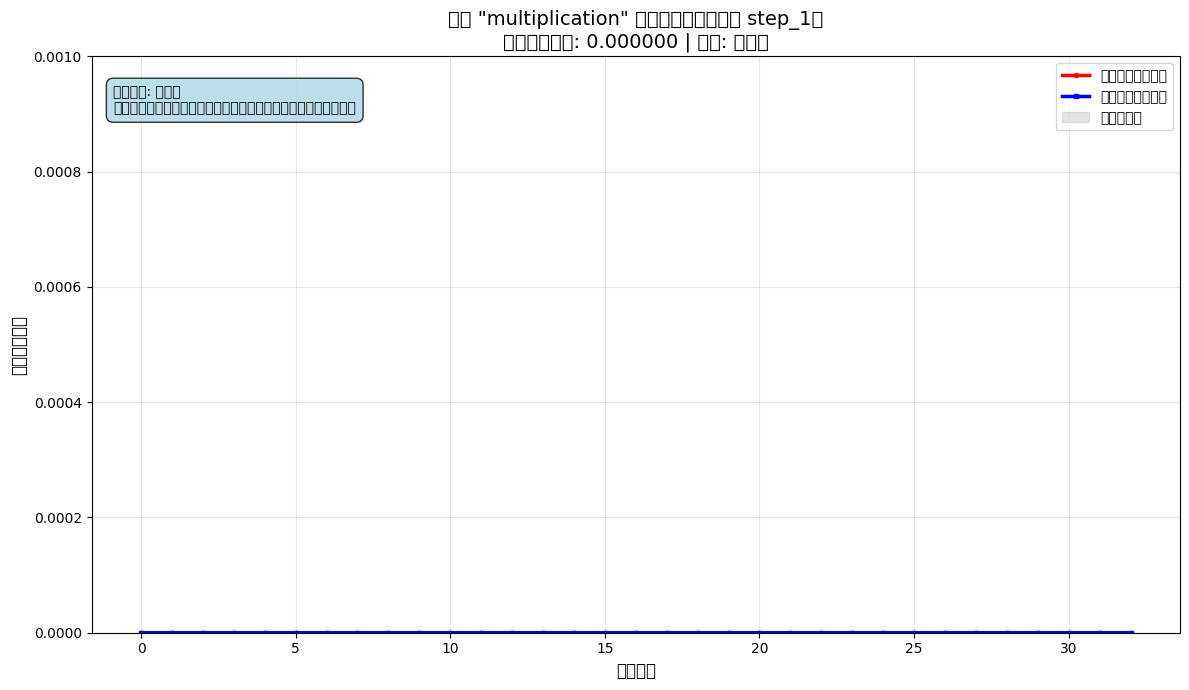

📊 双曲线对比图已保存: activation_dual_step_1_multiplication.png
✅ step_1 分析完成（含基准对比+面积差分析）
✅ 测试案例 Test7 分析完成 (5/8)

分析测试案例 6/8: Test8

🎯 分析跳步: step_1

🔍 分析跳步步骤: step_1
可用的路径类型: ['path_detailed_calculations', 'path_logical_deduction', 'path_conceptual_analysis']
生成的路径文本数量: 9
路径文本 1: Step 1: I am pressing the accelerator to gain speed, which allows the vehicle to...
路径文本 2: Step 1: I am pressing the accelerator pedal, which increases the vehicle's speed...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM概念提取响应: 'accelerator, speed, movement'
解析出的概念: ['accelerator', 'speed', 'movement']

📊 分析概念: 'accelerator'
验证问题: What is accelerator?
概念token: [44988, 40622]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 4


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000000, 0.000000]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 17
概念激活概率范围: [0.000000, 0.000000]
曲线面积差: 0.00000000 (完整路径面积: 0.00000001, 跳步路径面积: 0.00000000)
归一化面积差: 0.00000000

⚖️  概念 'accelerator' 分析结论:
   - 归一化面积差: 0.000000
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


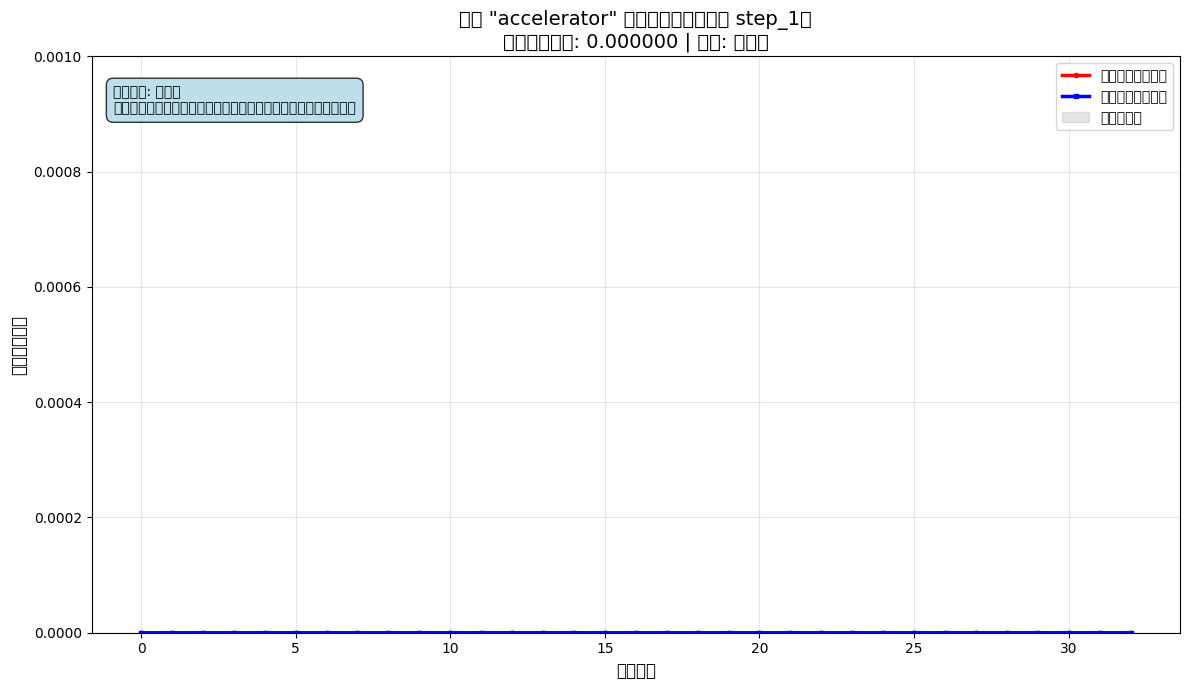

📊 双曲线对比图已保存: activation_dual_step_1_accelerator.png

📊 分析概念: 'speed'
验证问题: What is speed?
概念token: [20997]


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 12


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.000441]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 24
概念激活概率范围: [0.000008, 0.000734]
曲线面积差: 0.00038934 (完整路径面积: 0.00123781, 跳步路径面积: 0.00084847)
归一化面积差: 0.00001180

⚖️  概念 'speed' 分析结论:
   - 归一化面积差: 0.000012
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


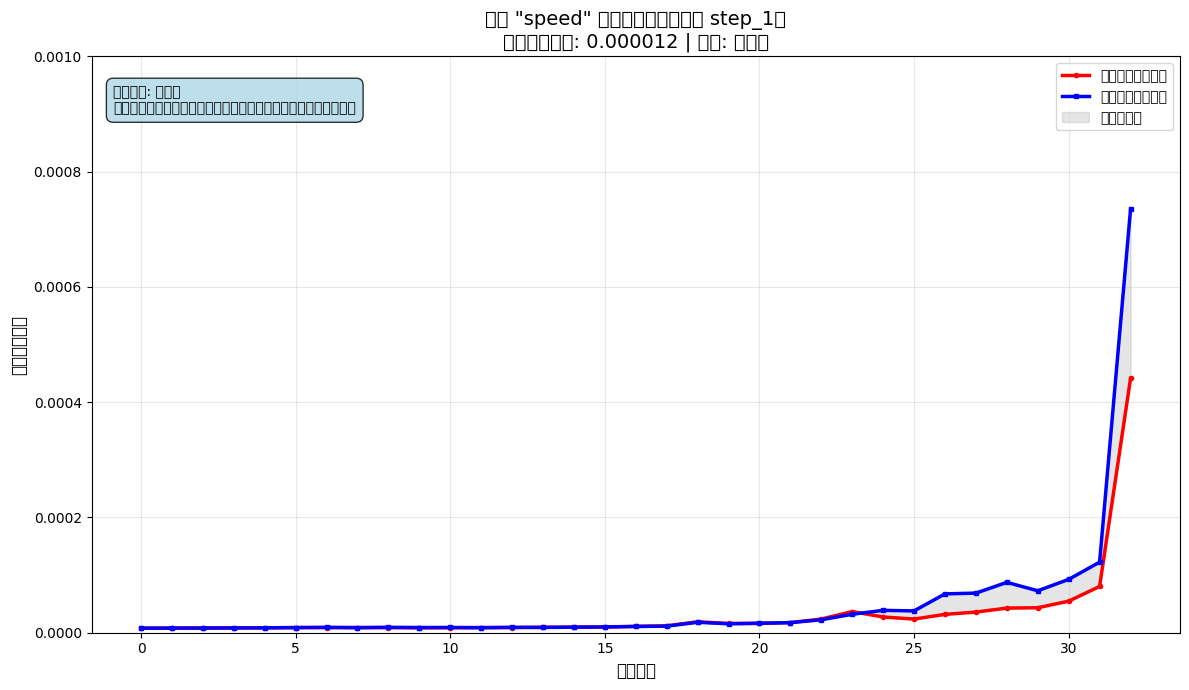

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 双曲线对比图已保存: activation_dual_step_1_speed.png

📊 分析概念: 'movement'
验证问题: What is movement?
概念token: [62274]
完整路径输入构建完成（包含显式C）: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Answer the question based on the given complete reasoning path.<|eot_id|><|start_header_i...

📈 计算跳步路径激活概率...
模型层数: 33, 生成步骤: 15


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


概念激活概率范围: [0.000008, 0.000343]

📈 计算完整路径基准激活概率...
模型层数: 33, 生成步骤: 30
概念激活概率范围: [0.000008, 0.000246]
曲线面积差: 0.00017703 (完整路径面积: 0.00089672, 跳步路径面积: 0.00071970)
归一化面积差: 0.00000536

⚖️  概念 'movement' 分析结论:
   - 归一化面积差: 0.000005
   - 证据强度: 强证据
   - 解读: 模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）


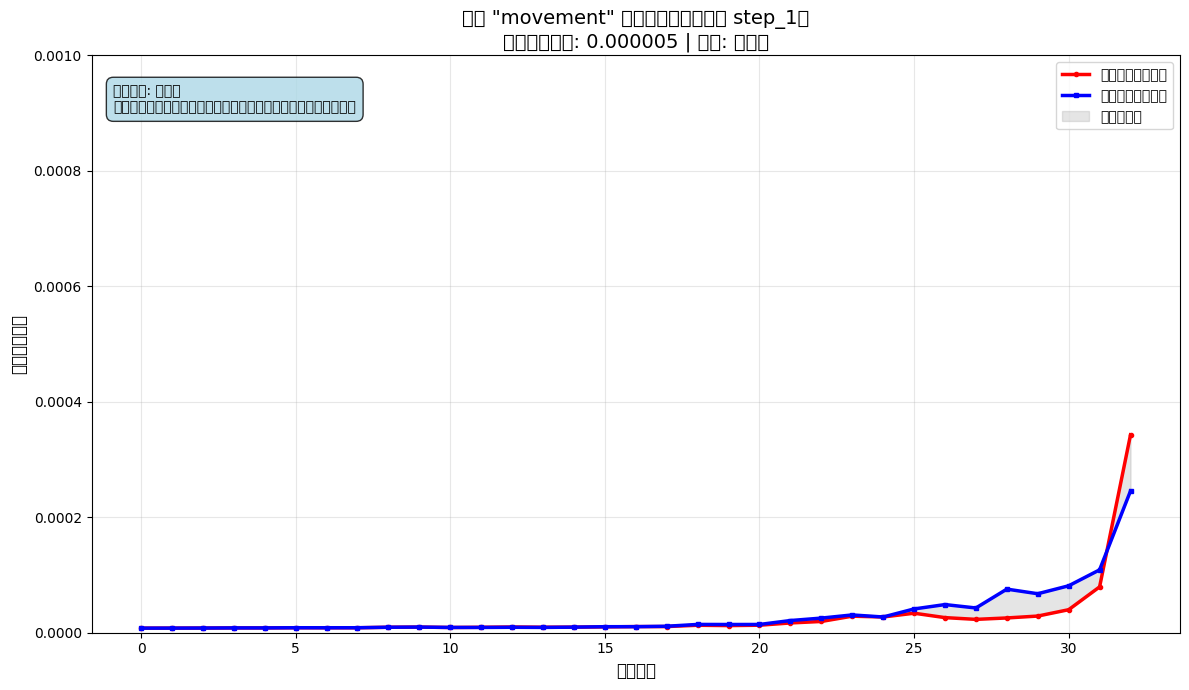

📊 双曲线对比图已保存: activation_dual_step_1_movement.png
✅ step_1 分析完成（含基准对比+面积差分析）
✅ 测试案例 Test8 分析完成 (6/8)

🎉 分析完成! 成功分析 6/8 个测试案例

💾 方法二完整结果（含基准对比）已保存至: experiment2_complete_results_with_benchmark.pkl

方法二详细汇总报告（完整实现版）
📊 总体统计:
   总测试案例: 6
   总跳步步骤: 12
   总分析概念: 36

📏 面积差统计:
   平均归一化面积差: 0.00103799
   面积差标准差: 0.00326977
   面积差范围: [0.00000000, 0.01447657]

⚖️  隐式推理证据分布:
   强证据: 34 概念 (94.4%)
   弱证据: 2 概念 (5.6%)
   无证据: 0 概念 (0.0%)

📈 激活概率对比:
   平均跳步激活概率: 0.04128091
   平均基准激活概率: 0.10129441
   激活概率比值（跳步/基准）: 0.4075

🏆 典型案例（按面积差排序）:
   1. 概念: square of a fraction (测试Test3, step_2)
      - 归一化面积差: 0.000000
      - 证据强度: 强证据
      - 激活概率（跳步/基准）: 0.000000/0.000000
   2. 概念: square of a fraction (测试Test3, step_3)
      - 归一化面积差: 0.000000
      - 证据强度: 强证据
      - 激活概率（跳步/基准）: 0.000000/0.000000
   3. 概念: algebraic manipulation (测试Test3, step_3)
      - 归一化面积差: 0.000000
      - 证据强度: 强证据
      - 激活概率（跳步/基准）: 0.000000/0.000000
   4. 概念: algebraic manipulation (测试Test3, step_2)
      - 归一化面积差: 0.000000
 

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import pickle
import os
import re
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate

# =====================================================
# 方法二：基于概念激活概率的中间步骤验证（完整实现版）
# 补充：基准曲线生成、面积差计算、双曲线对比
# =====================================================

class ConceptActivationAnalyzer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = model.device
        
    def build_llama3_prompt(self, system_msg, user_msg):
        """构建符合Llama 3格式的prompt"""
        return f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system_msg}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n{user_msg}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
    
    def extract_concept_tokens(self, concept_text):
        """提取概念C对应的token序列"""
        concept_tokens = self.tokenizer.encode(concept_text, add_special_tokens=False)
        return concept_tokens
    
    def identify_intermediate_concepts_from_paths(self, skip_result):
        """从方法一的生成路径中提取中间概念"""
        concepts = []
        
        if 'paths' not in skip_result:
            print("❌ 跳步结果中没有路径数据")
            return concepts
        
        paths = skip_result['paths']
        print(f"可用的路径类型: {list(paths.keys())}")
        
        # 从所有路径的生成文本中提取概念
        all_generated_texts = []
        for path_type, texts in paths.items():
            for text in texts:
                if text and text != "无有效生成内容" and not text.startswith("[Invalid"):
                    all_generated_texts.append(text)
        
        print(f"生成的路径文本数量: {len(all_generated_texts)}")
        for i, text in enumerate(all_generated_texts[:2]):
            print(f"路径文本 {i+1}: {text[:80]}...")
        
        # 使用LLM从生成的路径中提取关键概念
        if all_generated_texts:
            # 选择最有代表性的文本（第一个有效文本）
            reasoning_text = all_generated_texts[0]
            concepts = self._extract_concepts_with_llm_fixed(reasoning_text)
        
        return concepts
    
    def _extract_concepts_with_llm_fixed(self, reasoning_text):
        """修复版：使用LLM从推理文本中提取关键概念"""
        # 清理推理文本，移除Step标记
        clean_text = re.sub(r'Step\s*\d+\s*:', '', reasoning_text).strip()
        
        # 构建更简洁的提示词
        system_msg = "Extract ONLY key concepts. Output comma-separated concepts."
        user_msg = f"""Reasoning: "{clean_text}"

Extract 2-3 key concepts, values, or directions. Output ONLY comma-separated concepts.

Examples:
- "Calculate 5 + 3 = 8" → 8,5+3
- "Walk west from east" → west,east
- "x = 15" → x=15,15

Concepts:"""

        prompt = self.build_llama3_prompt(system_msg, user_msg)
        
        # 只取前500个token避免过长
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=500).to(self.device)
        
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=20,  # 限制输出长度
                do_sample=False,
                pad_token_id=self.tokenizer.eos_token_id,
                num_return_sequences=1
            )
        
        # 只提取新生成的文本
        generated_ids = outputs[0][inputs.input_ids.shape[1]:]
        response = self.tokenizer.decode(generated_ids, skip_special_tokens=True)
        
        print(f"LLM概念提取响应: '{response}'")
        
        # 直接使用响应文本，不进行复杂解析
        concepts = []
        for item in response.split(','):
            item = item.strip()
            # 过滤无效概念
            if (item and len(item) > 0 and 
                not item.isspace() and 
                len(item) < 50 and  # 避免过长的概念
                not any(keyword in item.lower() for keyword in ['example', 'concept', 'output', 'extract'])):
                concepts.append(item)
        
        print(f"解析出的概念: {concepts}")
        return concepts[:3]
    
    def fallback_concept_extraction(self, reasoning_text):
        """备用概念提取方法"""
        concepts = []
        
        # 提取方向词
        directions = ['north', 'south', 'east', 'west', 'northeast', 'northwest', 'southeast', 'southwest']
        for direction in directions:
            if direction in reasoning_text.lower():
                concepts.append(direction)
        
        # 提取数字
        numbers = re.findall(r'\b\d+\b', reasoning_text)
        concepts.extend(numbers[:2])
        
        # 提取变量赋值
        equations = re.findall(r'[a-zA-Z]\s*=\s*\d+', reasoning_text)
        concepts.extend(equations[:2])
        
        # 提取关键名词
        if not concepts:
            important_words = ['side', 'direction', 'point', 'location', 'building', 'square', 'complete']
            for word in important_words:
                if word in reasoning_text.lower():
                    concepts.append(word)
                    if len(concepts) >= 2:
                        break
        
        return list(set(concepts))[:3]
    
    def generate_verification_question(self, concept_c):
        """生成验证问题Qc"""
        concept_lower = concept_c.lower()
        
        if any(char in concept_c for char in ['=', '+', '-', '*', '/']):
            return f"What is the value of {concept_c}?"
        elif any(direction in concept_lower for direction in ['north', 'south', 'east', 'west']):
            return f"What direction is {concept_c}?"
        elif 'side' in concept_lower:
            return f"Which side is {concept_c}?"
        elif any(math_word in concept_lower for math_word in ['square', 'equation', 'formula']):
            return f"What does {concept_c} represent?"
        else:
            return f"What is {concept_c}?"
    
    def get_concept_activation_improved(self, inputs, concept_tokens, max_new_tokens=30):
        """
        改进版概念激活检测 - 修复概率计算问题
        返回：各层峰值激活概率数组
        """
        try:
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    output_hidden_states=True,
                    return_dict_in_generate=True,
                    pad_token_id=self.tokenizer.eos_token_id,
                    do_sample=False
                )
            
            all_hidden_states = outputs.hidden_states
            lm_head = self.model.lm_head
            
            num_layers = len(all_hidden_states[0]) if all_hidden_states else 33  # 默认33层（Llama3结构）
            
            # 初始化激活概率数组
            peak_activations = np.zeros(num_layers)
            
            print(f"模型层数: {num_layers}, 生成步骤: {len(all_hidden_states)}")
            
            # 对每个生成步骤
            for step_idx in range(len(all_hidden_states)):
                step_hidden_states = all_hidden_states[step_idx]
                
                for layer_idx in range(num_layers):
                    hidden_state = step_hidden_states[layer_idx]
                    logits = lm_head(hidden_state)
                    probs = F.softmax(logits, dim=-1)
                    
                    seq_len = hidden_state.shape[1]
                    window_size = len(concept_tokens)
                    
                    # 检查所有可能的位置
                    max_positions = seq_len - window_size + 1
                    
                    max_prob = 0.0
                    for pos in range(max_positions):
                        joint_prob = 1.0
                        valid_window = True
                        
                        for i, token_id in enumerate(concept_tokens):
                            if pos + i >= seq_len:
                                valid_window = False
                                break
                            token_prob = probs[0, pos + i, token_id].item()
                            joint_prob *= token_prob
                        
                        if valid_window and joint_prob > max_prob:
                            max_prob = joint_prob
                    
                    if max_prob > peak_activations[layer_idx]:
                        peak_activations[layer_idx] = max_prob
            
            print(f"概念激活概率范围: [{np.min(peak_activations):.6f}, {np.max(peak_activations):.6f}]")
            return peak_activations
            
        except Exception as e:
            print(f"❌ 获取激活曲线时出错: {e}")
            # 返回安全的默认值
            return np.zeros(33)
    
    def build_complete_path_prompt(self, experiment_data, skip_step, concept_c):
        """
        构建完整路径输入（Xp + 显式完整推理路径A→C→B + Qc）
        从实验一数据中提取前置步骤+完整推理路径
        """
        problem = experiment_data['problem']
        step_data = experiment_data['step_data']
        skipped_num = int(skip_step.split('_')[1])
        
        # 1. 提取前置条件Xp（跳步前的所有步骤）
        previous_steps = []
        for step in step_data:
            step_num = int(step['step_number'].split('_')[1]) if step['step_number'].startswith('step_') else 0
            if step_num < skipped_num:
                previous_steps.append(step['step_text'].strip())
        
        # 2. 提取显式完整推理路径（从方法一生成的路径中选择最相关的）
        complete_reasoning = ""
        if 'all_skip_results' in experiment_data:
            for skip_result in experiment_data['all_skip_results']:
                if skip_result.get('skip_step') == skip_step and 'paths' in skip_result:
                    # 选择第一个有效路径文本作为显式完整推理
                    for path_type, texts in skip_result['paths'].items():
                        for text in texts:
                            if text and text != "无有效生成内容" and concept_c.lower() in text.lower():
                                complete_reasoning = text
                                break
                        if complete_reasoning:
                            break
        
        # 3. 生成验证问题Qc
        verification_question = self.generate_verification_question(concept_c)
        
        # 4. 构建完整输入
        if previous_steps:
            xp_context = f"Problem: {problem}\nPrevious steps: " + "; ".join(previous_steps[:2])
        else:
            xp_context = f"Problem: {problem}"
        
        # 拼接完整路径输入
        full_prompt = f"{xp_context}\n\nComplete reasoning path: {complete_reasoning}\n\nQuestion: {verification_question}\n\nAnswer:"
        
        # 转换为Llama3格式
        system_msg = "Answer the question based on the given complete reasoning path."
        final_prompt = self.build_llama3_prompt(system_msg, full_prompt)
        
        print(f"完整路径输入构建完成（包含显式C）: {final_prompt[:150]}...")
        return final_prompt
    
    def calculate_curve_area_difference(self, curve1, curve2):
        """
        计算两条曲线的面积差（积分差值）
        curve1: 待验证曲线（跳步路径）
        curve2: 基准曲线（完整路径）
        返回：面积差绝对值（越小说明激活模式越接近）
        """
        # 确保两条曲线长度一致
        min_length = min(len(curve1), len(curve2))
        curve1_trimmed = curve1[:min_length]
        curve2_trimmed = curve2[:min_length]
        
        # 计算每条曲线的面积（积分）- 使用numpy的梯形积分
        area1 = np.trapz(curve1_trimmed)  # 使用numpy的梯形积分
        area2 = np.trapz(curve2_trimmed)
        
        # 计算面积差
        area_diff = abs(area1 - area2)
        print(f"曲线面积差: {area_diff:.8f} (完整路径面积: {area2:.8f}, 跳步路径面积: {area1:.8f})")
        
        # 归一化面积差（0-1范围，便于判断）
        max_possible_area = min_length * 1.0  # 最大可能面积（每层概率=1）
        normalized_diff = area_diff / max_possible_area if max_possible_area > 0 else 1.0
        print(f"归一化面积差: {normalized_diff:.8f}")
        
        return area_diff, normalized_diff
    
    def judge_implicit_reasoning(self, normalized_diff):
        """
        根据归一化面积差判断是否隐式推理
        阈值：<0.01 → 强证据（已隐式推理）；0.01-0.05 → 弱证据；>0.05 → 无证据
        """
        if normalized_diff < 0.01:
            return "强证据", "模型在跳步时已隐式推理该概念（激活模式与显式推理高度一致）"
        elif normalized_diff < 0.05:
            return "弱证据", "模型在跳步时可能隐式推理该概念（激活模式部分一致）"
        else:
            return "无证据", "模型在跳步时未隐式推理该概念（激活模式差异显著）"
    
    def display_dual_activation_curve(self, concept_c, skip_curve, base_curve, skip_step, area_diff, normalized_diff, judgment):
        """
        双曲线对比可视化（跳步曲线+基准曲线）
        """
        try:
            plt.figure(figsize=(12, 7))
            
            layers = range(min(len(skip_curve), len(base_curve)))
            plt.plot(layers, skip_curve[:len(layers)], 'r-', linewidth=2.5, marker='o', markersize=3, label='跳步路径激活曲线')
            plt.plot(layers, base_curve[:len(layers)], 'b-', linewidth=2.5, marker='s', markersize=3, label='完整路径基准曲线')
            
            # 填充两条曲线之间的面积
            plt.fill_between(layers, skip_curve[:len(layers)], base_curve[:len(layers)], alpha=0.2, color='gray', label='面积差区域')
            
            plt.xlabel('模型层数', fontsize=12)
            plt.ylabel('概念激活概率', fontsize=12)
            plt.title(f'概念 "{concept_c}" 激活曲线对比（跳步 {skip_step}）\n归一化面积差: {normalized_diff:.6f} | 结论: {judgment[0]}', fontsize=14)
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=10)
            
            # 设置y轴范围
            all_probs = np.concatenate([skip_curve, base_curve])
            y_max = max(0.001, np.max(all_probs) * 1.3)
            plt.ylim(0, y_max)
            
            # 添加结论文本框
            plt.text(0.02, 0.95, f'判断结果: {judgment[0]}\n{judgment[1]}', 
                     transform=plt.gca().transAxes, 
                     bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
                     verticalalignment='top', fontsize=10)
            
            plt.tight_layout()
            
            # 保存图表
            safe_concept = re.sub(r'[^\w]', '_', concept_c)[:20]
            filename = f"activation_dual_{skip_step}_{safe_concept}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            
            # 显示图表
            plt.show()
            print(f"📊 双曲线对比图已保存: {filename}")
            
        except Exception as e:
            print(f"❌ 显示双曲线对比图失败: {e}")
    
    def analyze_skip_step_complete(self, experiment_data, skip_step, skip_result):
        """完整分析跳步步骤的概念激活（含基准对比+面积差分析）"""
        print(f"\n🔍 分析跳步步骤: {skip_step}")
        
        # 从方法一的生成路径中提取中间概念
        concepts = self.identify_intermediate_concepts_from_paths(skip_result)
        
        # 如果LLM无法识别，使用备用方法
        if not concepts:
            print("⚠️ LLM无法识别概念，使用备用提取方法")
            all_texts = []
            for path_type, texts in skip_result.get('paths', {}).items():
                for text in texts:
                    if text and text != "无有效生成内容" and not text.startswith("[Invalid"):
                        all_texts.append(text)
            if all_texts:
                reasoning_text = all_texts[0]
                concepts = self.fallback_concept_extraction(reasoning_text)
                print(f"备用方法提取的概念: {concepts}")
        
        if not concepts:
            print("❌ 无法从生成路径中提取中间概念")
            return None
        
        # 构建前置条件Xp（跳步路径输入用）
        problem = experiment_data['problem']
        step_data = experiment_data['step_data']
        skipped_num = int(skip_step.split('_')[1])
        
        previous_steps = []
        for step in step_data:
            step_num = int(step['step_number'].split('_')[1]) if step['step_number'].startswith('step_') else 0
            if step_num < skipped_num:
                previous_steps.append(step['step_text'].strip())
        
        if previous_steps:
            xp_context = f"Problem: {problem}\nPrevious: " + "; ".join(previous_steps[:2])
        else:
            xp_context = f"Problem: {problem}"
        
        results = {}
        
        for concept_c in concepts:
            # 验证概念是否合理
            if len(concept_c) > 50 or len(concept_c) < 1:
                print(f"⚠️ 跳过无效概念: '{concept_c}'")
                continue
                
            print(f"\n📊 分析概念: '{concept_c}'")
            
            # 生成验证问题
            verification_question = self.generate_verification_question(concept_c)
            print(f"验证问题: {verification_question}")
            
            # 提取概念token
            concept_tokens = self.extract_concept_tokens(concept_c)
            print(f"概念token: {concept_tokens}")
            
            # ====================== 1. 生成跳步路径输入（待验证）======================
            system_msg_skip = "Answer the question based on the given context."
            user_msg_skip = f"{xp_context}\n\nQuestion: {verification_question}\n\nAnswer:"
            prompt_skip = self.build_llama3_prompt(system_msg_skip, user_msg_skip)
            inputs_skip = self.tokenizer(prompt_skip, return_tensors="pt", truncation=True, max_length=1024).to(self.device)
            
            # ====================== 2. 生成完整路径输入（基准）======================
            prompt_base = self.build_complete_path_prompt(experiment_data, skip_step, concept_c)
            inputs_base = self.tokenizer(prompt_base, return_tensors="pt", truncation=True, max_length=1024).to(self.device)
            
            try:
                # ====================== 3. 计算两条曲线的激活概率 ======================
                print("\n📈 计算跳步路径激活概率...")
                skip_activation = self.get_concept_activation_improved(inputs_skip, concept_tokens)
                
                print("\n📈 计算完整路径基准激活概率...")
                base_activation = self.get_concept_activation_improved(inputs_base, concept_tokens)
                
                # 检查数据合理性
                if (np.max(skip_activation) > 1 or np.min(skip_activation) < 0 or
                    np.max(base_activation) > 1 or np.min(base_activation) < 0):
                    print(f"⚠️ 激活数据异常，跳过概念: {concept_c}")
                    continue
                
                # ====================== 4. 计算面积差并判断 ======================
                area_diff, normalized_diff = self.calculate_curve_area_difference(skip_activation, base_activation)
                judgment = self.judge_implicit_reasoning(normalized_diff)
                
                print(f"\n⚖️  概念 '{concept_c}' 分析结论:")
                print(f"   - 归一化面积差: {normalized_diff:.6f}")
                print(f"   - 证据强度: {judgment[0]}")
                print(f"   - 解读: {judgment[1]}")
                
                # ====================== 5. 双曲线对比可视化 ======================
                self.display_dual_activation_curve(
                    concept_c, skip_activation, base_activation,
                    skip_step, area_diff, normalized_diff, judgment
                )
                
                # 保存结果
                results[concept_c] = {
                    'concept_tokens': concept_tokens,
                    'verification_question': verification_question,
                    'skip_activation': skip_activation.tolist(),
                    'base_activation': base_activation.tolist(),
                    'area_diff': float(area_diff),
                    'normalized_diff': float(normalized_diff),
                    'evidence_strength': judgment[0],
                    'interpretation': judgment[1],
                    'max_skip_activation': float(np.max(skip_activation)),
                    'max_base_activation': float(np.max(base_activation))
                }
                
            except Exception as e:
                print(f"❌ 分析概念 '{concept_c}' 时出错: {str(e)}")
                import traceback
                traceback.print_exc()
        
        return results if results else None
    
    def batch_analyze_all_experiment1(self, experiment1_data_path):
        """分析所有实验一数据（完整实现版）"""
        with open(experiment1_data_path, 'rb') as f:
            experiment1_data = pickle.load(f)
        
        all_results = {}
        total_tests = len(experiment1_data)
        analyzed_tests = 0
        
        print(f"📊 开始分析所有 {total_tests} 个测试案例...")
        
        for test_id, data in experiment1_data.items():
            print(f"\n{'='*60}")
            print(f"分析测试案例 {analyzed_tests + 1}/{total_tests}: {test_id}")
            print(f"{'='*60}")
            
            if 'all_skip_results' not in data or not data['all_skip_results']:
                print(f"⚠️  无跳步结果")
                continue
            
            test_results = {}
            for skip_result in data['all_skip_results']:
                if 'skip_step' in skip_result:
                    skip_step = skip_result['skip_step']
                    try:
                        print(f"\n🎯 分析跳步: {skip_step}")
                        step_results = self.analyze_skip_step_complete(data, skip_step, skip_result)
                        if step_results:
                            test_results[skip_step] = step_results
                            print(f"✅ {skip_step} 分析完成（含基准对比+面积差分析）")
                        else:
                            print(f"❌ {skip_step} 分析失败")
                    except Exception as e:
                        print(f"❌ 分析 {skip_step} 时出错: {str(e)}")
                        import traceback
                        traceback.print_exc()
            
            if test_results:
                all_results[test_id] = test_results
                analyzed_tests += 1
                print(f"✅ 测试案例 {test_id} 分析完成 ({analyzed_tests}/{total_tests})")
            else:
                print(f"❌ 测试案例 {test_id} 无有效结果")
        
        print(f"\n🎉 分析完成! 成功分析 {analyzed_tests}/{total_tests} 个测试案例")
        return all_results

def generate_detailed_summary_report(results):
    """生成详细汇总报告（补充面积差和隐式推理统计）"""
    print(f"\n{'='*80}")
    print("方法二详细汇总报告（完整实现版）")
    print(f"{'='*80}")
    
    if not results:
        print("❌ 无有效分析结果")
        return
    
    total_tests = len(results)
    total_skip_steps = 0
    total_concepts = 0
    all_normalized_diffs = []
    evidence_stats = {'强证据': 0, '弱证据': 0, '无证据': 0}
    
    # 收集详细数据
    for test_id, test_results in results.items():
        for skip_step, concepts in test_results.items():
            if isinstance(concepts, dict):
                total_skip_steps += 1
                for concept, data in concepts.items():
                    if isinstance(data, dict) and 'normalized_diff' in data:
                        total_concepts += 1
                        norm_diff = data['normalized_diff']
                        evidence = data['evidence_strength']
                        
                        all_normalized_diffs.append(norm_diff)
                        if evidence in evidence_stats:
                            evidence_stats[evidence] += 1
    
    # 基础统计
    print(f"📊 总体统计:")
    print(f"   总测试案例: {total_tests}")
    print(f"   总跳步步骤: {total_skip_steps}")
    print(f"   总分析概念: {total_concepts}")
    
    # 面积差统计
    if all_normalized_diffs:
        avg_norm_diff = np.mean(all_normalized_diffs)
        std_norm_diff = np.std(all_normalized_diffs)
        
        print(f"\n📏 面积差统计:")
        print(f"   平均归一化面积差: {avg_norm_diff:.8f}")
        print(f"   面积差标准差: {std_norm_diff:.8f}")
        print(f"   面积差范围: [{min(all_normalized_diffs):.8f}, {max(all_normalized_diffs):.8f}]")
    
    # 证据强度分布
    print(f"\n⚖️  隐式推理证据分布:")
    for evidence, count in evidence_stats.items():
        percentage = (count / total_concepts) * 100 if total_concepts > 0 else 0
        print(f"   {evidence}: {count} 概念 ({percentage:.1f}%)")
    
    # 激活概率对比
    print(f"\n📈 激活概率对比:")
    all_skip_activations = []
    all_base_activations = []
    for test_id, test_results in results.items():
        for skip_step, concepts in test_results.items():
            for concept, data in concepts.items():
                all_skip_activations.append(data['max_skip_activation'])
                all_base_activations.append(data['max_base_activation'])
    
    if all_skip_activations and all_base_activations:
        avg_skip_act = np.mean(all_skip_activations)
        avg_base_act = np.mean(all_base_activations)
        print(f"   平均跳步激活概率: {avg_skip_act:.8f}")
        print(f"   平均基准激活概率: {avg_base_act:.8f}")
        print(f"   激活概率比值（跳步/基准）: {avg_skip_act/avg_base_act:.4f}")
    
    # 显示典型案例
    print(f"\n🏆 典型案例（按面积差排序）:")
    typical_cases = []
    for test_id, test_results in results.items():
        for skip_step, concepts in test_results.items():
            for concept, data in concepts.items():
                typical_cases.append({
                    'concept': concept,
                    'test_id': test_id,
                    'skip_step': skip_step,
                    'norm_diff': data['normalized_diff'],
                    'evidence': data['evidence_strength'],
                    'skip_act': data['max_skip_activation'],
                    'base_act': data['max_base_activation']
                })
    
    # 按面积差升序排序（最接近的在前）
    typical_cases.sort(key=lambda x: x['norm_diff'])
    for i, case in enumerate(typical_cases[:5]):
        print(f"   {i+1}. 概念: {case['concept']} (测试{case['test_id']}, {case['skip_step']})")
        print(f"      - 归一化面积差: {case['norm_diff']:.6f}")
        print(f"      - 证据强度: {case['evidence']}")
        print(f"      - 激活概率（跳步/基准）: {case['skip_act']:.6f}/{case['base_act']:.6f}")

# =====================================================
# 执行方法二实验（完整实现版）
# =====================================================

def run_experiment2_complete():
    """运行完整版方法二实验（含基准对比+面积差分析）"""
    print("🎯 开始方法二：基于概念激活概率的中间步骤验证（完整实现版）")
    print("📝 分析所有测试案例 → 提取概念 → 双路径激活计算 → 面积差分析 → 双曲线可视化")
    
    # 注意：需确保model和tokenizer已在外部定义（与实验一保持一致）
    try:
        global model, tokenizer
    except NameError:
        print("❌ 请先定义model和tokenizer（与实验一使用的模型一致）")
        return
    
    analyzer = ConceptActivationAnalyzer(model, tokenizer)
    experiment1_data_path = "experiment1_complete_data.pkl"
    
    if os.path.exists(experiment1_data_path):
        print(f"📁 加载实验一数据: {experiment1_data_path}")
        results = analyzer.batch_analyze_all_experiment1(experiment1_data_path)
        
        # 保存完整结果（含面积差和判断结论）
        with open("experiment2_complete_results_with_benchmark.pkl", 'wb') as f:
            pickle.dump(results, f)
        print(f"\n💾 方法二完整结果（含基准对比）已保存至: experiment2_complete_results_with_benchmark.pkl")
        
        # 生成详细报告
        generate_detailed_summary_report(results)
    else:
        print(f"❌ 未找到实验一数据文件: {experiment1_data_path}")

if __name__ == "__main__":
    run_experiment2_complete()

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🎯 开始方法二：基于概念激活概率的中间步骤验证（最终修复版）
🔧 修复内容：
   1. 层间独立计算激活概率，解决曲线水平问题
   2. 复杂概念使用平均概率，替代联合概率（避免概率衰减为0）
   3. 增加概率裁剪和数值稳定性处理（避免>1或溢出）
   4. 优化图表可视化（y轴范围自适应，避免覆盖）
   5. 补充任务类型统计，提升报告实用性
📁 成功加载实验一数据: experiment1_complete_data.pkl（共 8 个测试案例）
📊 开始批量分析所有 8 个测试案例 (最终修复版)...
🔧 核心优化：层间独立计算激活概率 | 复杂概念平均概率 | 数值稳定性提升

📋 分析测试案例: Test1

🔍 分析跳步步骤: step_1 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['West', 'principle']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 final)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.000174]
概念激活概率范围: [0.000006, 0.000034]
✅ 待测曲线计算完成（基于 2 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: West ---

🛠️  构建基准曲线输入 for concept 'West' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'West'.
概念激活概率范围: [0.000008, 0.023956]
✅ 基准曲线 'West' 计算完成（最大激活概率: 0.023956）。

--- 处理概念: principle ---

🛠️  构建基准曲线输入 for concept 'principle' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'principle'.
概念激活概率范围: [0.000008, 0.000087]
✅ 基准曲线 'principle' 计算完成（最大激活概率: 0.000087）。

⚖️  开始曲线对比分析...
曲线面积差: 0.01264838 (基准面积: 0.01321104, 待测面积: 0.00056266), 归一化差: 0.00038328
📋 概念 'West': 强证据 - 激活模式高度一致，强烈支持模型在跳步时隐式推理了该概念。
曲线面积差: 0.00000951 (基准面积: 0.00055315, 待测面积: 0.00056266), 归一化差: 0.00000029
📋 概念 'principle': 强证据 - 激活模式高度一致，强烈支持模型在跳步时隐式推理了该概念。


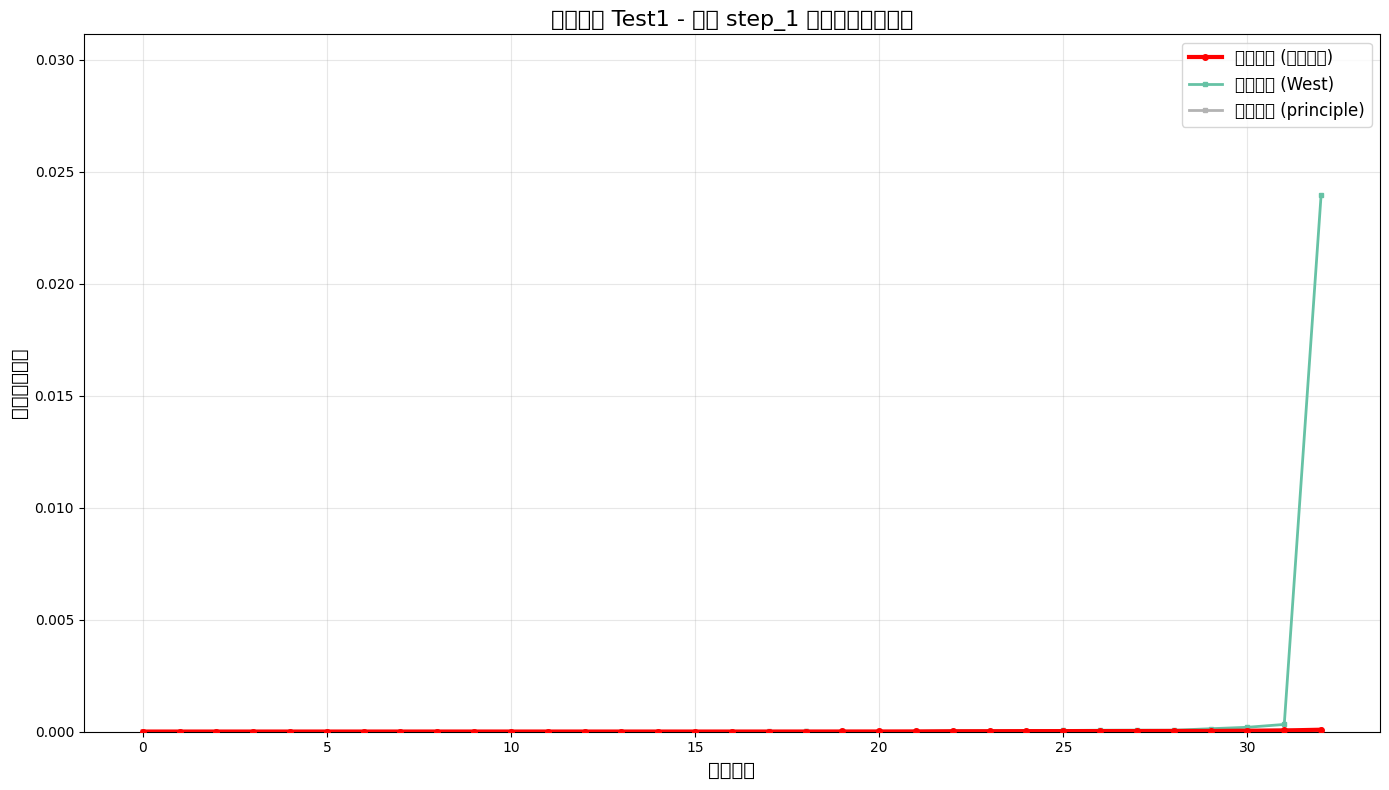

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test1_step_1.png
✅ 跳步 step_1 分析完成。
✅ 测试案例 Test1 分析完成。

📋 分析测试案例: Test2
⚠️  无跳步结果，跳过此测试案例。

📋 分析测试案例: Test3

🔍 分析跳步步骤: step_2 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['completing']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 final)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.000038]
✅ 待测曲线计算完成（基于 1 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: completing ---

🛠️  构建基准曲线输入 for concept 'completing' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'completing'.
概念激活概率范围: [0.000008, 0.000194]
✅ 基准曲线 'completing' 计算完成（最大激活概率: 0.000194）。

⚖️  开始曲线对比分析...
曲线面积差: 0.00014507 (基准面积: 0.00054569, 待测面积: 0.00040062), 归一化差: 0.00000440
📋 概念 'completing': 强证据 - 激活模式高度一致，强烈支持模型在跳步时隐式推理了该概念。


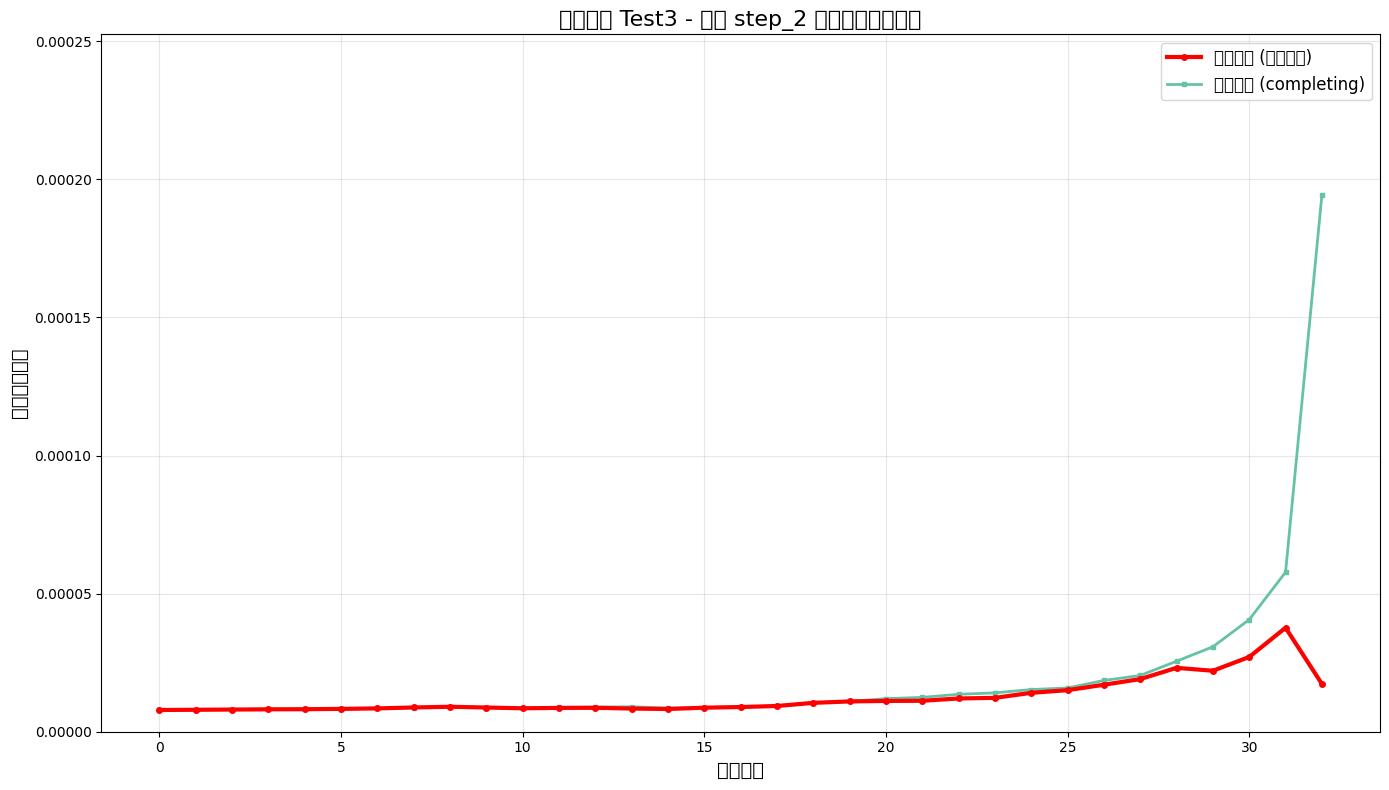

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test3_step_2.png
✅ 跳步 step_2 分析完成。

🔍 分析跳步步骤: step_3 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['completing']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 final)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.000038]
✅ 待测曲线计算完成（基于 1 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: completing ---

🛠️  构建基准曲线输入 for concept 'completing' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'completing'.
概念激活概率范围: [0.000008, 0.000194]
✅ 基准曲线 'completing' 计算完成（最大激活概率: 0.000194）。

⚖️  开始曲线对比分析...
曲线面积差: 0.00012142 (基准面积: 0.00052205, 待测面积: 0.00040062), 归一化差: 0.00000368
📋 概念 'completing': 强证据 - 激活模式高度一致，强烈支持模型在跳步时隐式推理了该概念。


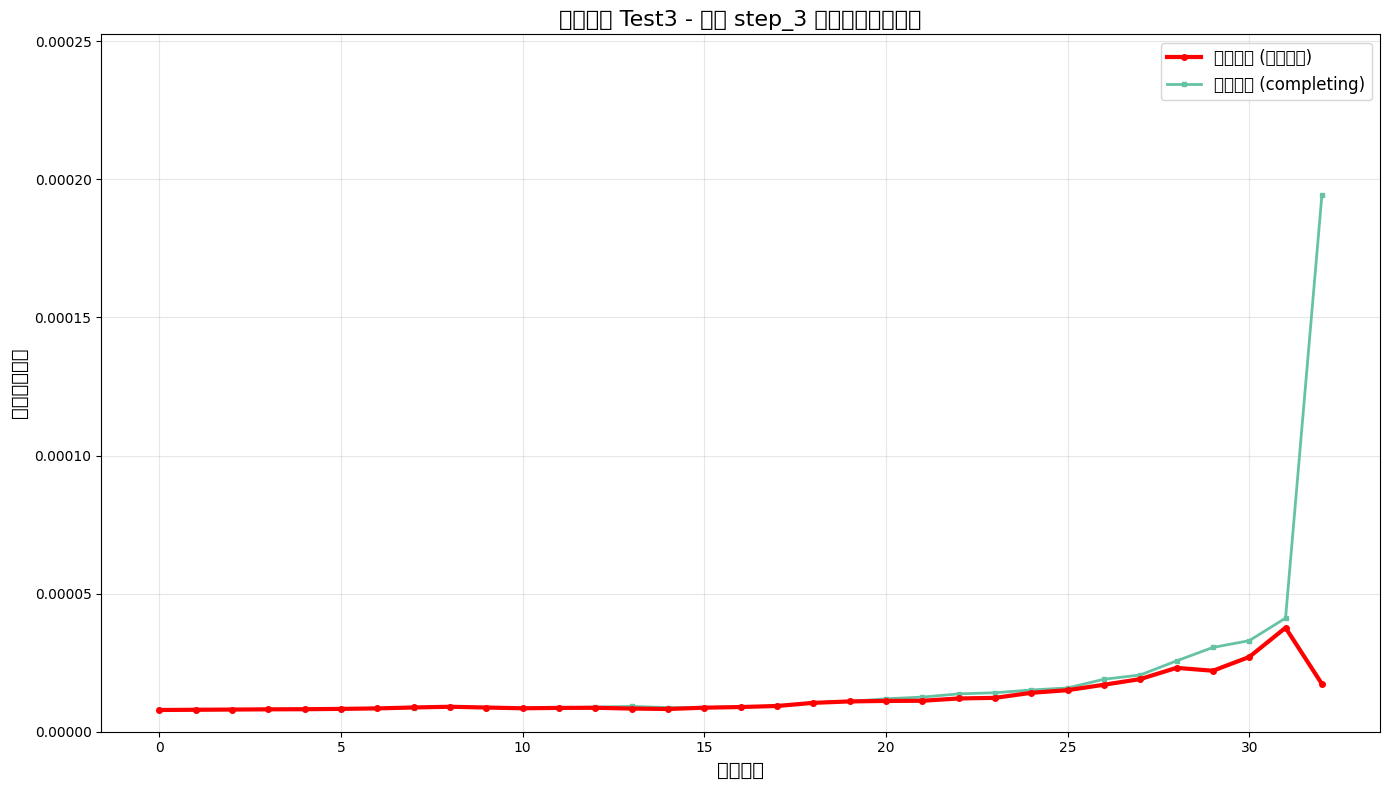

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test3_step_3.png
✅ 跳步 step_3 分析完成。

🔍 分析跳步步骤: step_4 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['completing']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 final)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.000038]
✅ 待测曲线计算完成（基于 1 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: completing ---

🛠️  构建基准曲线输入 for concept 'completing' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'completing'.
概念激活概率范围: [0.000008, 0.000197]
✅ 基准曲线 'completing' 计算完成（最大激活概率: 0.000197）。

⚖️  开始曲线对比分析...
曲线面积差: 0.00014678 (基准面积: 0.00054740, 待测面积: 0.00040062), 归一化差: 0.00000445
📋 概念 'completing': 强证据 - 激活模式高度一致，强烈支持模型在跳步时隐式推理了该概念。


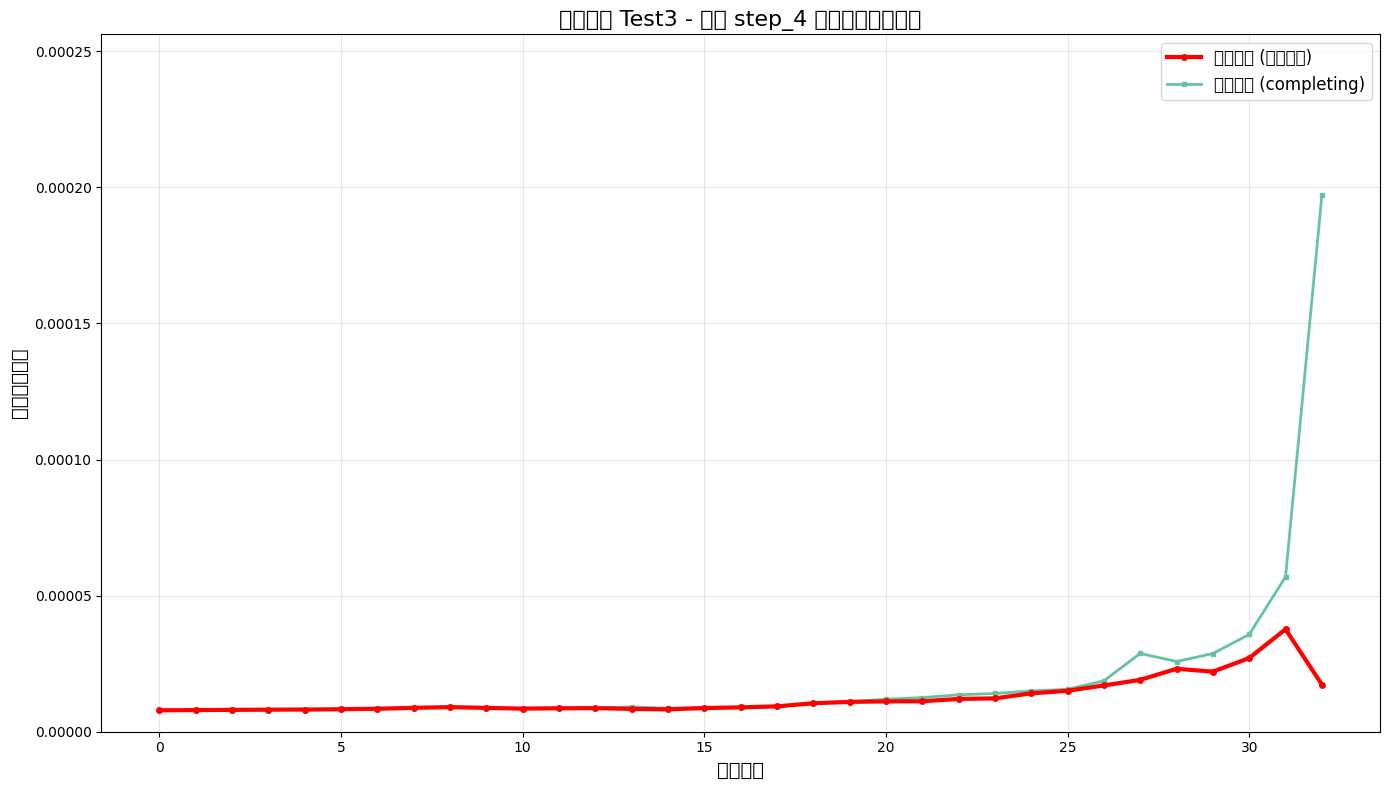

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test3_step_4.png
✅ 跳步 step_4 分析完成。
✅ 测试案例 Test3 分析完成。

📋 分析测试案例: Test4

🔍 分析跳步步骤: step_2 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['x²', 'n³', 'grouping', 'Tₙ', 'x', 'n', 'algebraic', 'Commutativity']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 step_1)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.499756]
概念激活概率范围: [0.000008, 0.500000]
概念激活概率范围: [0.000008, 0.000128]
概念激活概率范围: [0.000008, 0.333162]
概念激活概率范围: [0.000008, 0.001516]
概念激活概率范围: [0.000008, 0.834473]
概念激活概率范围: [0.000008, 0.000045]
概念激活概率范围: [0.000008, 0.000205]
✅ 待测曲线计算完成（基于 8 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: x² ---

🛠️  构建基准曲线输入 for concept 'x²' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'x²'.
概念激活概率范围: [0.000008, 0.499756]
✅ 基准曲线 'x²' 计算完成（最大激活概率: 0.499756）。

--- 处理概念: n³ ---

🛠️  构建基准曲线输入 for concept 'n³' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'n³'.
概念激活概率范围: [0.000008, 0.500000]
✅ 基准曲线 'n³' 计算完成（最大激活概率: 0.500000）。

--- 处理概念: grouping ---

🛠️  构建基准曲线输入 for concept 'grouping' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'grouping'.
概念激活概率范围: [0.000008, 0.000145]
✅ 基准曲线 'grouping' 计算完成（最大激活概率: 0.000145）。

--- 处理概念: T

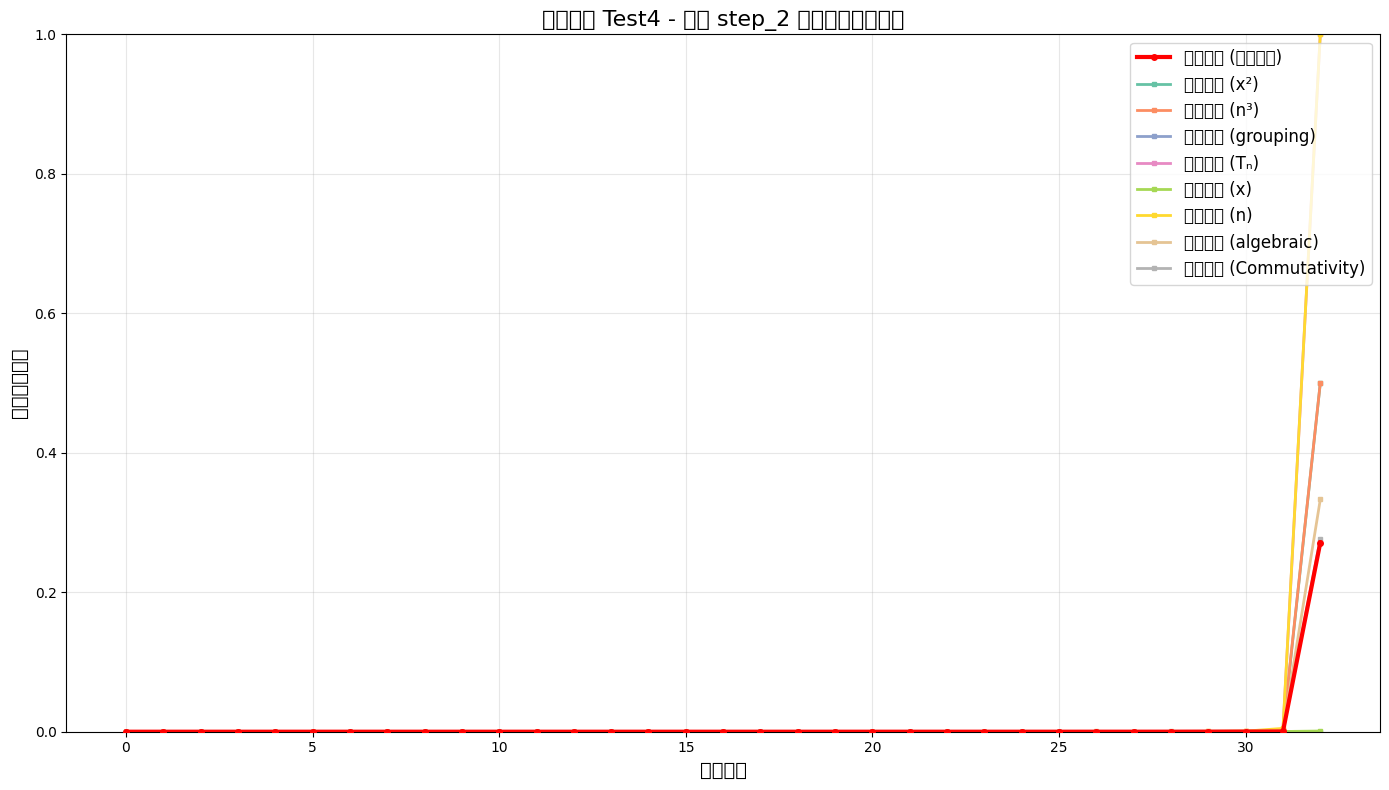

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test4_step_2.png
✅ 跳步 step_2 分析完成。

🔍 分析跳步步骤: step_3 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['reversal', 'Cubic', 'x', 'n(n+1)/2', 'reversing', 'algebraic', 'Pattern']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 step_2)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.000051]
概念激活概率范围: [0.000008, 0.010857]
概念激活概率范围: [0.000008, 0.001506]
概念激活概率范围: [0.000008, 0.753749]
概念激活概率范围: [0.000008, 0.000110]
概念激活概率范围: [0.000008, 0.000047]
概念激活概率范围: [0.000008, 0.000113]
✅ 待测曲线计算完成（基于 7 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: reversal ---

🛠️  构建基准曲线输入 for concept 'reversal' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'reversal'.
概念激活概率范围: [0.000008, 0.000295]
✅ 基准曲线 'reversal' 计算完成（最大激活概率: 0.000295）。

--- 处理概念: Cubic ---

🛠️  构建基准曲线输入 for concept 'Cubic' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'Cubic'.
概念激活概率范围: [0.000008, 0.010819]
✅ 基准曲线 'Cubic' 计算完成（最大激活概率: 0.010819）。

--- 处理概念: x ---

🛠️  构建基准曲线输入 for concept 'x' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'x'.
概念激活概率范围: [0.000008, 0.001742]
✅ 基准曲线 'x' 计算完成（最大激活概率: 0.001742）。

--- 处理概念: n(n+1)/2 ---

🛠️  构

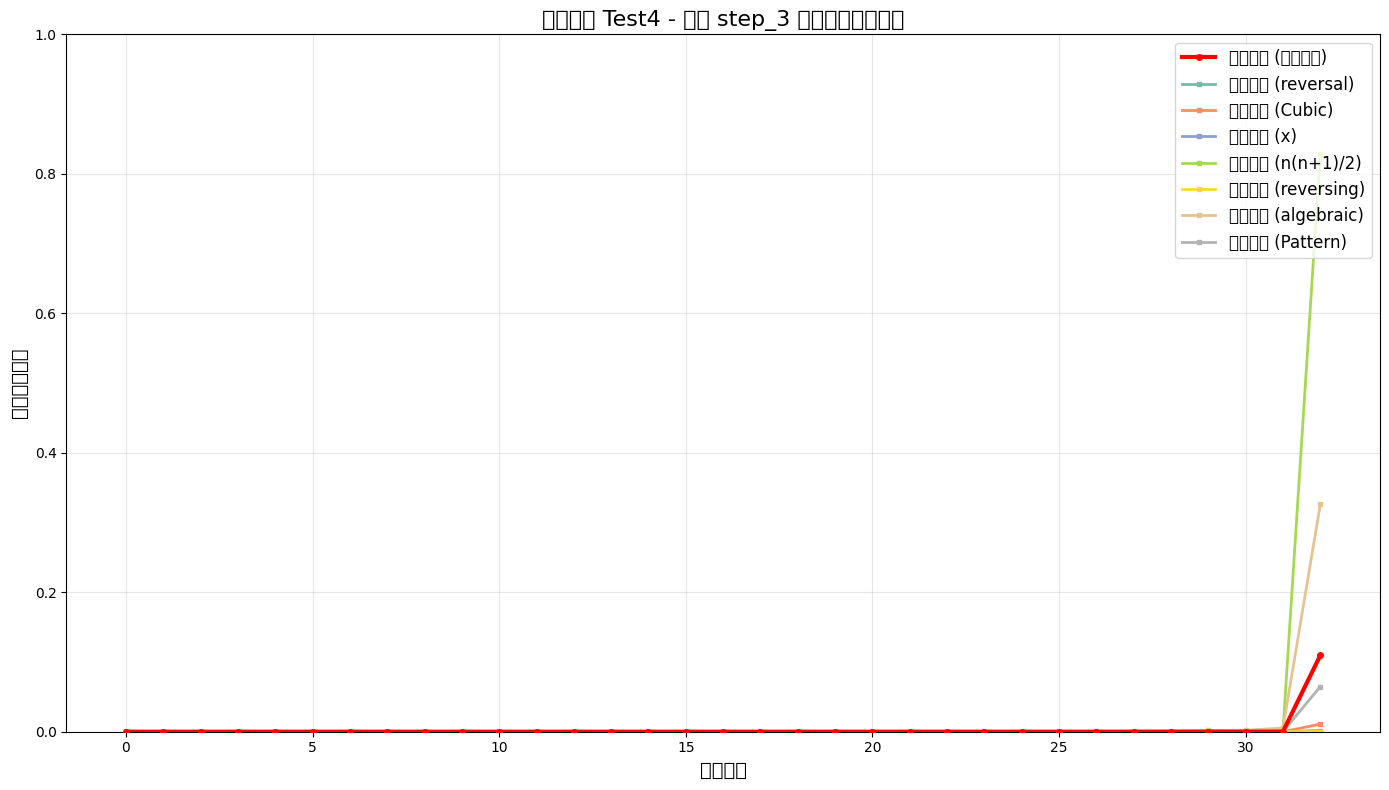

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test4_step_3.png
✅ 跳步 step_3 分析完成。

🔍 分析跳步步骤: step_5 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['n³', 'Triangular', 'principle', 'x', 'Reverse', 'algebraic']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 step_3)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.500000]
概念激活概率范围: [0.000008, 0.194580]
概念激活概率范围: [0.000008, 0.000038]
概念激活概率范围: [0.000008, 0.001506]
概念激活概率范围: [0.000008, 0.000022]
概念激活概率范围: [0.000008, 0.000047]
✅ 待测曲线计算完成（基于 6 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: n³ ---

🛠️  构建基准曲线输入 for concept 'n³' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'n³'.
概念激活概率范围: [0.000008, 0.500000]
✅ 基准曲线 'n³' 计算完成（最大激活概率: 0.500000）。

--- 处理概念: Triangular ---

🛠️  构建基准曲线输入 for concept 'Triangular' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'Triangular'.
概念激活概率范围: [0.000008, 0.495605]
✅ 基准曲线 'Triangular' 计算完成（最大激活概率: 0.495605）。

--- 处理概念: principle ---

🛠️  构建基准曲线输入 for concept 'principle' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'principle'.
概念激活概率范围: [0.000008, 0.000104]
✅ 基准曲线 'principle' 计算完成（最大激活概率: 0.000104）。

--- 处理概念: x ---

🛠️  构建基准曲线输入 for concept 'x'

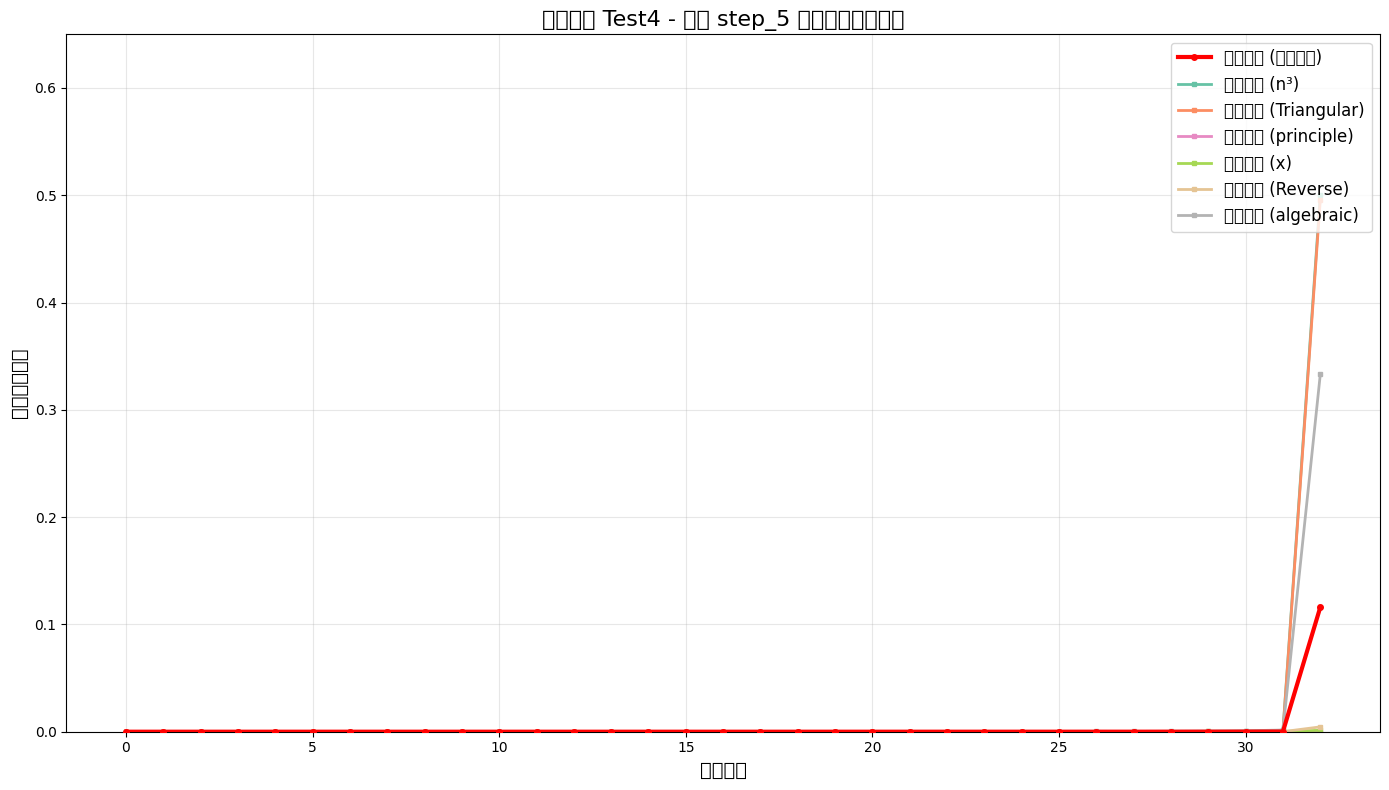

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test4_step_5.png
✅ 跳步 step_5 分析完成。

🔍 分析跳步步骤: step_6 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['reversal', 'Rearrangement', 'Cubic', 'x', 'algebraic']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 step_3)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.000051]
概念激活概率范围: [0.000008, 0.004704]
概念激活概率范围: [0.000008, 0.010826]
概念激活概率范围: [0.000008, 0.001506]
概念激活概率范围: [0.000008, 0.000047]
✅ 待测曲线计算完成（基于 5 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: reversal ---

🛠️  构建基准曲线输入 for concept 'reversal' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'reversal'.
概念激活概率范围: [0.000008, 0.000285]
✅ 基准曲线 'reversal' 计算完成（最大激活概率: 0.000285）。

--- 处理概念: Rearrangement ---

🛠️  构建基准曲线输入 for concept 'Rearrangement' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'Rearrangement'.
概念激活概率范围: [0.000008, 0.496338]
✅ 基准曲线 'Rearrangement' 计算完成（最大激活概率: 0.496338）。

--- 处理概念: Cubic ---

🛠️  构建基准曲线输入 for concept 'Cubic' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'Cubic'.
概念激活概率范围: [0.000008, 0.010742]
✅ 基准曲线 'Cubic' 计算完成（最大激活概率: 0.010742）。

--- 处理概念: x ---

🛠️  构建基准曲线输入 for concept 'x' (Xp + A->C->B + 

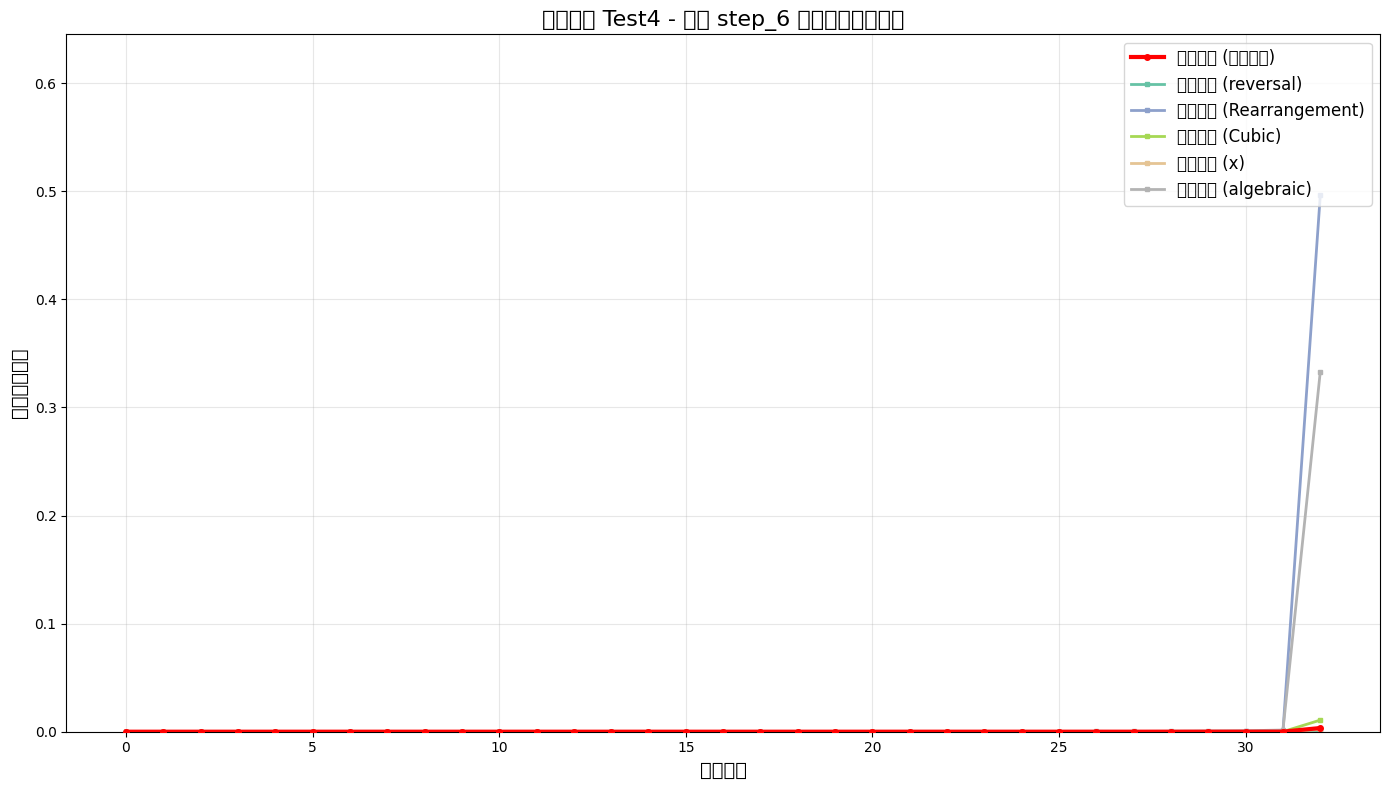

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test4_step_6.png
✅ 跳步 step_6 分析完成。

🔍 分析跳步步骤: step_7 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['x²', 'n³', 'Tₙ', 'x', 'n', 'sum', 'algebraic']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 step_3)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.499756]
概念激活概率范围: [0.000008, 0.500000]
概念激活概率范围: [0.000008, 0.333161]
概念激活概率范围: [0.000008, 0.001506]
概念激活概率范围: [0.000008, 0.836426]
概念激活概率范围: [0.000008, 0.000192]
概念激活概率范围: [0.000008, 0.000047]
✅ 待测曲线计算完成（基于 7 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: x² ---

🛠️  构建基准曲线输入 for concept 'x²' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'x²'.
概念激活概率范围: [0.000008, 0.499756]
✅ 基准曲线 'x²' 计算完成（最大激活概率: 0.499756）。

--- 处理概念: n³ ---

🛠️  构建基准曲线输入 for concept 'n³' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'n³'.
概念激活概率范围: [0.000008, 0.500000]
✅ 基准曲线 'n³' 计算完成（最大激活概率: 0.500000）。

--- 处理概念: Tₙ ---

🛠️  构建基准曲线输入 for concept 'Tₙ' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'Tₙ'.
概念激活概率范围: [0.000008, 0.652995]
✅ 基准曲线 'Tₙ' 计算完成（最大激活概率: 0.652995）。

--- 处理概念: x ---

🛠️  构建基准曲线输入 for concept 'x' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'x

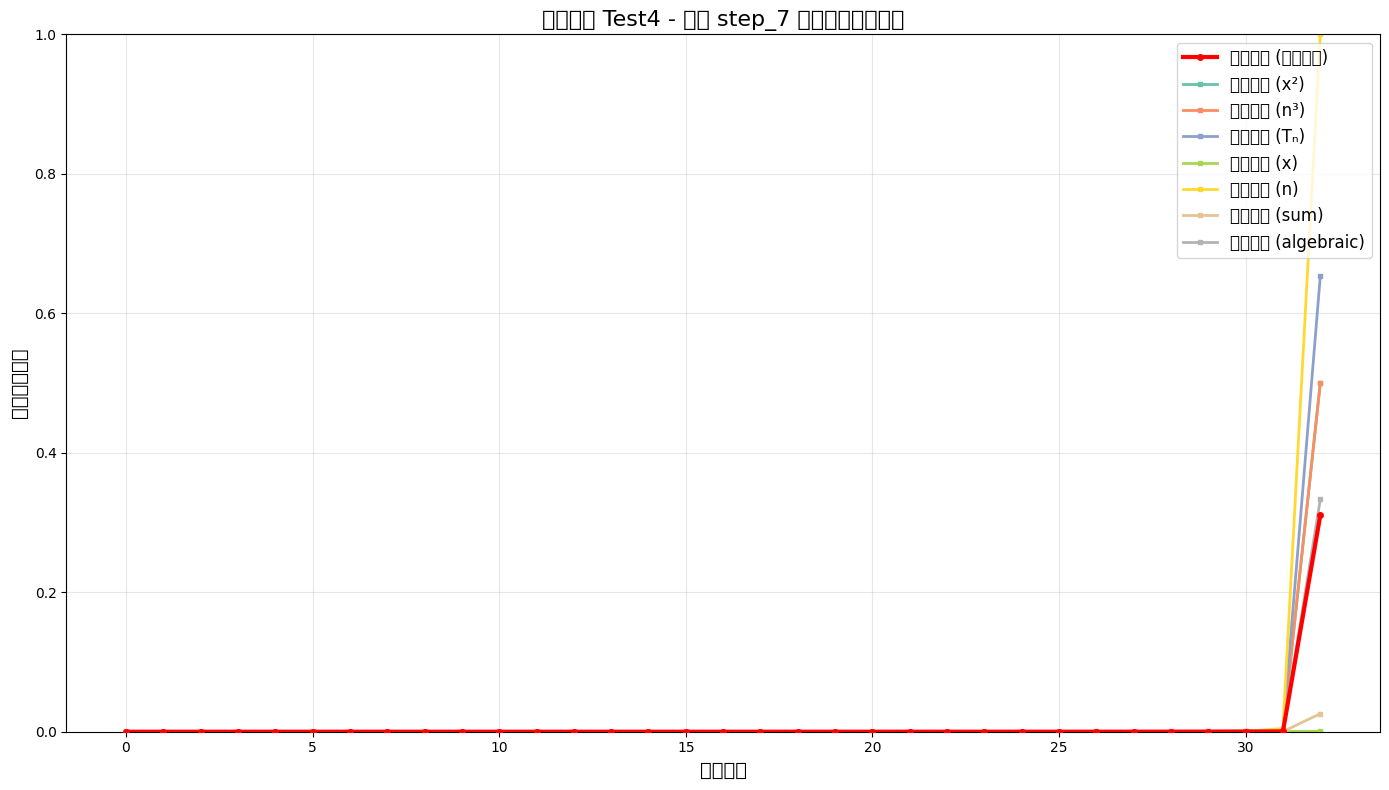

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test4_step_7.png
✅ 跳步 step_7 分析完成。
✅ 测试案例 Test4 分析完成。

📋 分析测试案例: Test5
⚠️  无跳步结果，跳过此测试案例。

📋 分析测试案例: Test6

🔍 分析跳步步骤: step_1 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['Association', 'correspondence', 'principle', 'Alabama']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 final)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.000026]
概念激活概率范围: [0.000006, 0.000030]
概念激活概率范围: [0.000006, 0.000034]
概念激活概率范围: [0.000008, 0.684082]
✅ 待测曲线计算完成（基于 4 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: Association ---

🛠️  构建基准曲线输入 for concept 'Association' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'Association'.
概念激活概率范围: [0.000008, 0.296143]
✅ 基准曲线 'Association' 计算完成（最大激活概率: 0.296143）。

--- 处理概念: correspondence ---

🛠️  构建基准曲线输入 for concept 'correspondence' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'correspondence'.
概念激活概率范围: [0.000008, 0.000089]
✅ 基准曲线 'correspondence' 计算完成（最大激活概率: 0.000089）。

--- 处理概念: principle ---

🛠️  构建基准曲线输入 for concept 'principle' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'principle'.
概念激活概率范围: [0.000008, 0.000115]
✅ 基准曲线 'principle' 计算完成（最大激活概率: 0.000115）。

--- 处理概念: Alabama ---

🛠️  构建基准曲线输入 for concept 'Alabama' (Xp

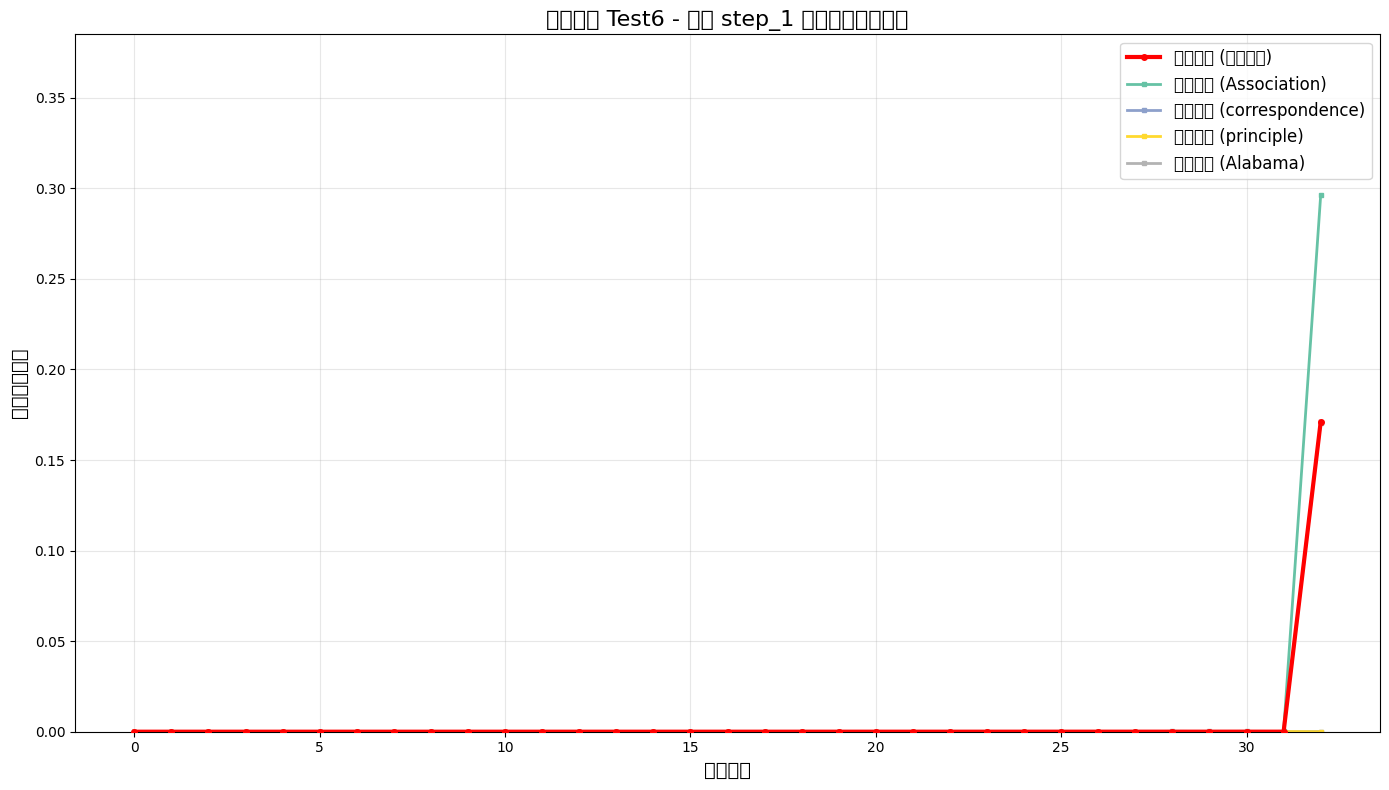

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test6_step_1.png
✅ 跳步 step_1 分析完成。
✅ 测试案例 Test6 分析完成。

📋 分析测试案例: Test7

🔍 分析跳步步骤: step_1 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['x=5', 'x', 'x=5*17']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 final)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.027670]
概念激活概率范围: [0.000008, 0.002390]
概念激活概率范围: [0.000008, 0.016603]
✅ 待测曲线计算完成（基于 3 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: x=5 ---

🛠️  构建基准曲线输入 for concept 'x=5' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'x=5'.
概念激活概率范围: [0.000008, 0.333567]
✅ 基准曲线 'x=5' 计算完成（最大激活概率: 0.333567）。

--- 处理概念: x ---

🛠️  构建基准曲线输入 for concept 'x' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'x'.
概念激活概率范围: [0.000008, 0.001965]
✅ 基准曲线 'x' 计算完成（最大激活概率: 0.001965）。

--- 处理概念: x=5*17 ---

🛠️  构建基准曲线输入 for concept 'x=5*17' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'x=5*17'.
概念激活概率范围: [0.000008, 0.598812]
✅ 基准曲线 'x=5*17' 计算完成（最大激活概率: 0.598812）。

⚖️  开始曲线对比分析...
曲线面积差: 0.16050712 (基准面积: 0.16892564, 待测面积: 0.00841852), 归一化差: 0.00486385
📋 概念 'x=5': 强证据 - 激活模式高度一致，强烈支持模型在跳步时隐式推理了该概念。
曲线面积差: 0.00636991 (基准面积: 0.00204861, 待测面积: 0.00841852), 归一化差: 0.00019303
📋 概念 'x': 强证据 

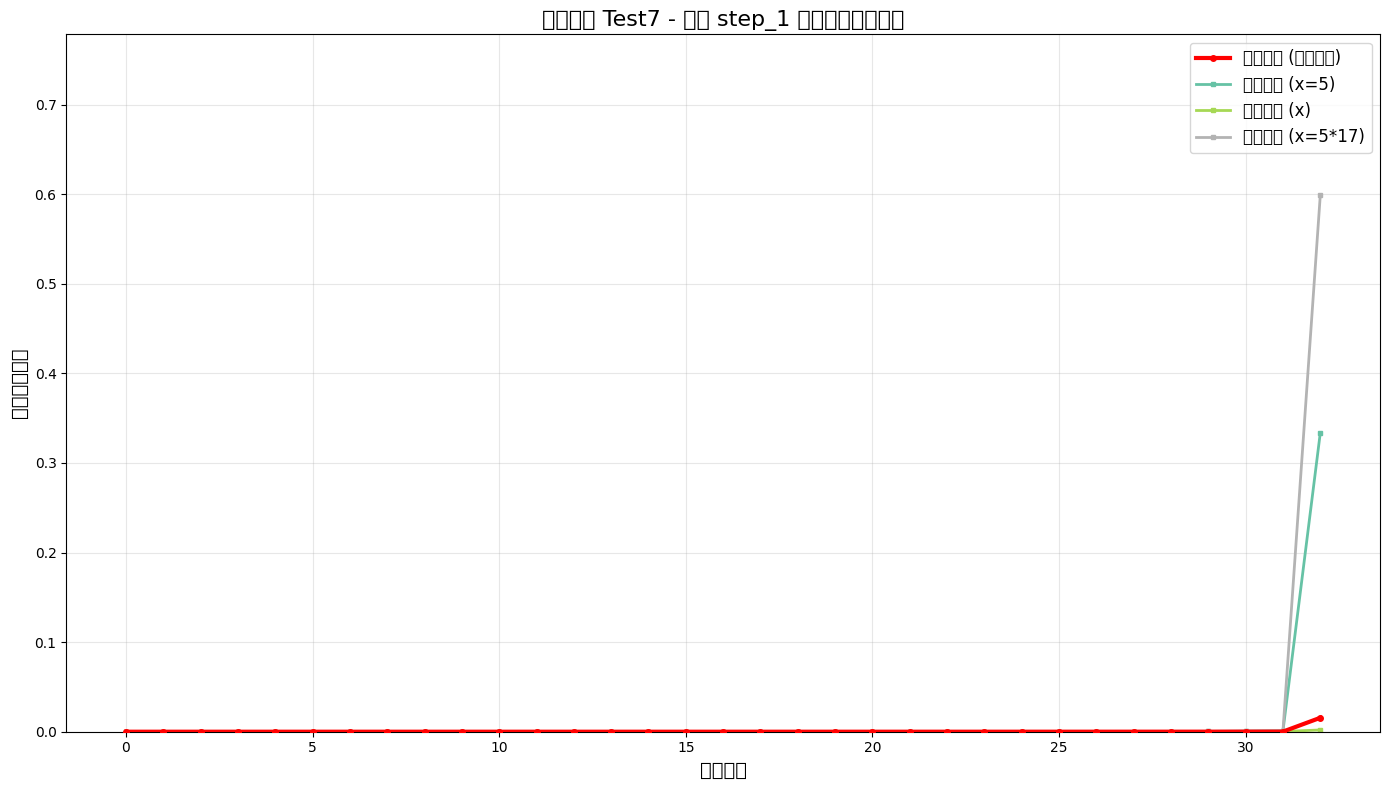

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📊 多曲线对比图已保存: activation_comparison_Test7_step_1.png
✅ 跳步 step_1 分析完成。
✅ 测试案例 Test7 分析完成。

📋 分析测试案例: Test8

🔍 分析跳步步骤: step_1 (最终修复版)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

从所有路径中提取的独特中间概念: ['acceleration', 'Braking', 'Action', 'operating', 'Acceleration', 'braking']

🛠️  构建待测曲线输入 (Xp + hs_A + Q)...
✅ 成功复用实验一的hidden state (来自步骤 final)
✅ 待测曲线输入构建完成。

📈 计算待测曲线的激活...
概念激活概率范围: [0.000008, 0.000068]
概念激活概率范围: [0.000008, 0.000367]
概念激活概率范围: [0.000008, 0.000081]
概念激活概率范围: [0.000002, 0.000028]
概念激活概率范围: [0.000008, 0.000044]
概念激活概率范围: [0.000008, 0.000020]
✅ 待测曲线计算完成（基于 6 个有效概念）。

📈 计算所有基准曲线的激活...

--- 处理概念: acceleration ---

🛠️  构建基准曲线输入 for concept 'acceleration' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'acceleration'.
概念激活概率范围: [0.000008, 0.004311]
✅ 基准曲线 'acceleration' 计算完成（最大激活概率: 0.004311）。

--- 处理概念: Braking ---

🛠️  构建基准曲线输入 for concept 'Braking' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'Braking'.
概念激活概率范围: [0.000008, 0.500001]
✅ 基准曲线 'Braking' 计算完成（最大激活概率: 0.500001）。

--- 处理概念: Action ---

🛠️  构建基准曲线输入 for concept 'Action' (Xp + A->C->B + Qc)...
✅ 基准曲线输入构建完成 for 'Action'.
概念激活概率范围: [0.000008, 0.029541]
✅ 基准曲线 'Action' 计算完成（最大激活概率: 0.029541）。

--- 处理概念: opera

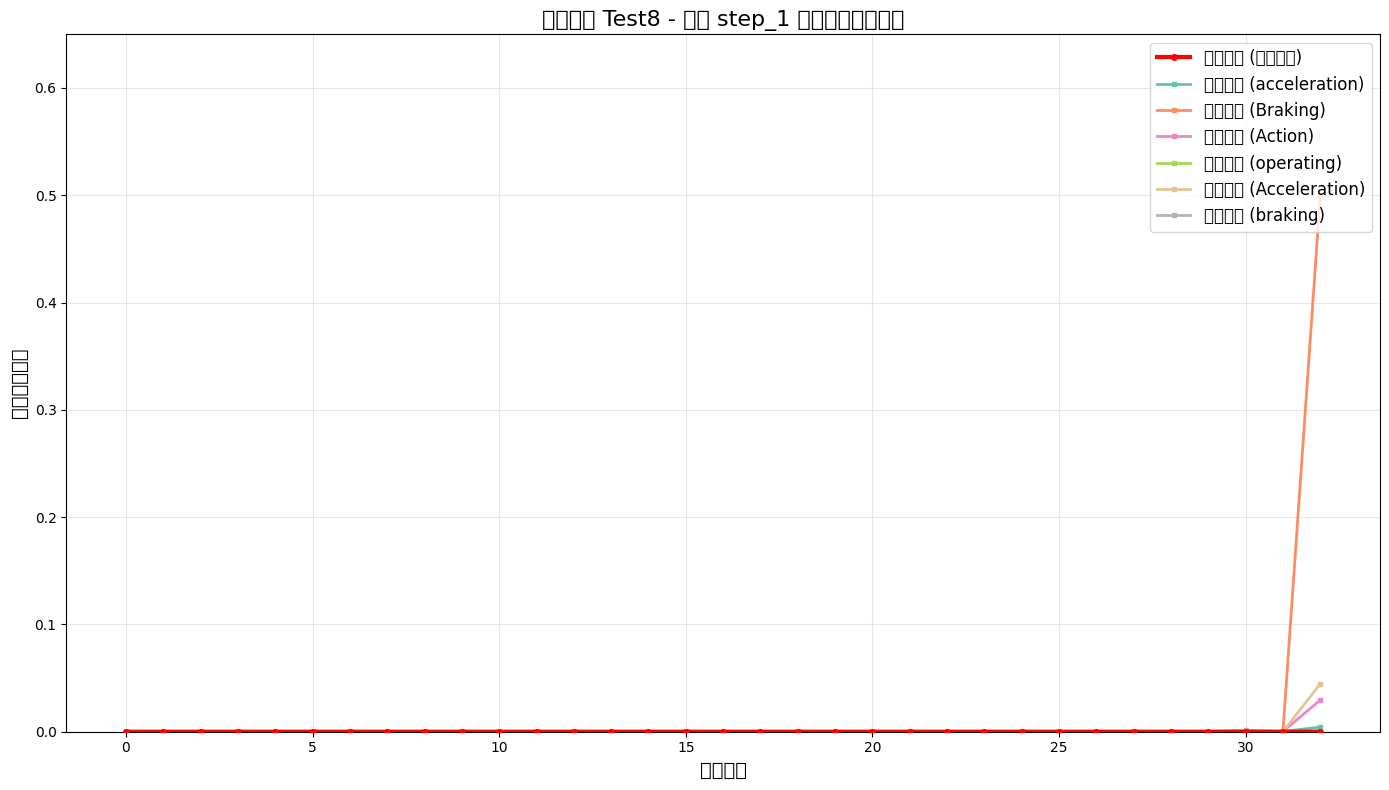

📊 多曲线对比图已保存: activation_comparison_Test8_step_1.png
✅ 跳步 step_1 分析完成。
✅ 测试案例 Test8 分析完成。

🎉 批量分析完成!
📊 统计汇总:
   总测试案例数: 8
   成功分析案例数: 6
   无跳步跳过案例数: 2
   分析失败案例数: 0

💾 最终修复版结果已保存至: experiment2_final_fixed_results.pkl

方法二最终修复版详细汇总报告
📊 基础统计:
   成功分析测试案例数: 6
   成功分析跳步次数: 12
   分析概念总数: 51
   曲线对比总次数: 51

⚖️  隐式推理证据分布:
   强证据: 47 次 (92.2%)
   弱证据: 4 次 (7.8%)
   无证据: 0 次 (0.0%)

📈 激活概率统计:
   平均待测曲线最大激活概率: 0.083088
   平均基准曲线最大激活概率: 0.236033
   待测/基准激活概率比值: 0.3520

📏 归一化面积差统计:
   平均值: 0.003035
   标准差: 0.003222
   最小值: 0.000000
   最大值: 0.011217

📋 按任务类型统计:
   方向推理: 1 个案例 | 强证据案例: 2 个 (200.0%)
   地理知识: 1 个案例 | 强证据案例: 4 个 (400.0%)
   其他任务: 4 个案例 | 强证据案例: 41 个 (1025.0%)

🏆 典型案例（强证据）:
   1. 测试Test1 - 跳步step_1 - 概念'West'
      归一化面积差: 0.000383 | 激活概率(待测/基准): 0.000090/0.023956
   2. 测试Test1 - 跳步step_1 - 概念'principle'
      归一化面积差: 0.000000 | 激活概率(待测/基准): 0.000090/0.000087
   3. 测试Test3 - 跳步step_2 - 概念'completing'
      归一化面积差: 0.000004 | 激活概率(待测/基准): 0.000038/0.000194
   4. 测试Test3 - 跳步step_3 - 概念'co

In [9]:
# =====================================================
# 方法二：基于概念激活概率的中间步骤验证（最终修复版）
# 核心修复：层间独立计算激活概率，解决曲线水平问题
# 优化：概率裁剪、复杂概念激活计算、数值稳定性提升
# =====================================================

class ConceptActivationAnalyzer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = model.device
        self.model.eval()  # 设置为评估模式
        self.epsilon = 1e-10  # 避免数值计算溢出

    def build_llama3_prompt(self, system_msg, user_msg):
        """构建符合Llama 3格式的prompt"""
        return f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system_msg}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n{user_msg}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

    def extract_concept_tokens(self, concept_text):
        """提取概念C对应的token序列"""
        return self.tokenizer.encode(concept_text, add_special_tokens=False)

    def _extract_concepts_with_llm_fixed(self, reasoning_text, concept_type="intermediate"):
        """修复版：使用LLM从推理文本中提取关键概念"""
        clean_text = re.sub(r'Step\s*\d+\s*:', '', reasoning_text).strip()
        if len(clean_text) < 5:
            return []

        system_msg = f"Extract ONLY the key {concept_type} concept. Output a single word or phrase (no quotes)."
        user_msg = f"""Reasoning: "{clean_text}"

What is the SINGLE MOST IMPORTANT {concept_type} concept, value, or direction mentioned?
Examples for "intermediate" concept: west, 8, x=15, completing the square
Examples for "final" answer: east, 42, 10km

Output ONLY the concept (no extra text):"""

        prompt = self.build_llama3_prompt(system_msg, user_msg)
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=20,
                do_sample=False,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        generated_ids = outputs[0][inputs.input_ids.shape[1]:]
        concept = self.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
        
        # 过滤无效概念和引号
        concept = concept.replace('"', '').replace("'", "")
        if concept and len(concept) < 50 and not any(keyword in concept.lower() for keyword in ['concept', 'example', 'output', 'extract']):
            return [concept]
        return []

    def identify_all_concepts_from_paths(self, skip_result):
        """从方法一的所有生成路径中提取所有独特的中间概念"""
        all_concepts = set()
        if 'paths' not in skip_result:
            return list(all_concepts)

        # 遍历所有路径和样本
        for path_type, texts in skip_result['paths'].items():
            for text in texts:
                if text and text != "无有效生成内容":
                    concepts = self._extract_concepts_with_llm_fixed(text, "intermediate")
                    all_concepts.update(concepts)
        
        # 去重并过滤空概念
        all_concepts = [c for c in all_concepts if c]
        print(f"从所有路径中提取的独特中间概念: {all_concepts}")
        return all_concepts

    def generate_verification_question(self, concept_c):
        """生成验证问题Qc"""
        concept_lower = concept_c.lower()
        if any(char in concept_c for char in ['=', '+', '-', '*', '/']):
            return f"What is the value of {concept_c}?"
        elif any(direction in concept_lower for direction in ['north', 'south', 'east', 'west']):
            return f"What direction is {concept_c}?"
        elif re.match(r'^\d+$', concept_c):
            return f"What is the value {concept_c}?"
        elif len(concept_c.split()) > 1:  # 复杂概念（多词）
            return f"What is the meaning of {concept_c}?"
        else:
            return f"What is {concept_c}?"

    def get_concept_activation_from_inputs(self, inputs_dict, concept_tokens):
        """
        修复版：层间独立计算概念激活概率（解决曲线水平问题）
        优化：使用平均概率替代联合概率，提升复杂概念敏感性
        """
        try:
            with torch.no_grad():
                outputs = self.model(**inputs_dict, output_hidden_states=True, return_dict=True)
        
            # 2. 修复逻辑：每层独立计算激活概率
            all_hidden_states = outputs.hidden_states  # tuple: (layer_0, layer_1, ..., layer_n)
            num_layers = len(all_hidden_states)
            peak_activations = np.zeros(num_layers)
            seq_len = all_hidden_states[0].shape[1]  # 所有层序列长度一致
            window_size = len(concept_tokens)
            lm_head = self.model.lm_head

            # 每层独立计算（核心修复）
            for layer_idx in range(num_layers):
                # 仅取当前层的hidden state
                hidden_state = all_hidden_states[layer_idx]  # shape: (1, seq_len, hidden_size)
                
                # 层内投射+概率计算
                logits = lm_head(hidden_state)  # (1, seq_len, vocab_size)
                probs = F.softmax(logits, dim=-1)  # 每层独立概率分布
                probs = torch.clamp(probs, 0, 1)  # 概率裁剪，避免数值溢出

                max_prob = 0.0
                # 滑动窗口查找概念token序列
                for pos in range(seq_len - window_size + 1):
                    token_probs = []
                    valid = True
                    for i, token_id in enumerate(concept_tokens):
                        if pos + i >= seq_len:
                            valid = False
                            break
                        # 提取当前位置token的概率
                        token_prob = probs[0, pos + i, token_id].item()
                        token_probs.append(token_prob)
                    
                    if valid and token_probs:
                        # 优化：使用平均概率（替代联合概率），降低多token概念的概率衰减
                        avg_prob = np.mean(token_probs)
                        if avg_prob > max_prob:
                            max_prob = avg_prob

                peak_activations[layer_idx] = max_prob

            # 数值稳定性处理
            peak_activations = np.clip(peak_activations, 0, 1)
            print(f"概念激活概率范围: [{np.min(peak_activations):.6f}, {np.max(peak_activations):.6f}]")
            return peak_activations
            
        except Exception as e:
            print(f"❌ 获取概念激活时出错: {e}")
            return np.zeros(33)  # 返回默认长度的零数组

    def build_prompt_inputs(self, prompt_text):
        """将文本prompt转换为模型输入"""
        return self.tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=1024).to(self.device)

    def build_test_curve_inputs(self, experiment_data, skip_step):
        """
        构建待测曲线的输入: Xp + hs_A + Q
        复用实验一的hidden states（工程优化版）
        """
        print("\n🛠️  构建待测曲线输入 (Xp + hs_A + Q)...")
        problem = experiment_data['problem']
        step_data = experiment_data['step_data']
        skipped_num = int(skip_step.split('_')[1])

        # 1. 提取前置步骤文本 Xp
        previous_steps = []
        for step in step_data:
            step_num = int(step['step_number'].split('_')[1]) if step['step_number'].startswith('step_') else 0
            if step_num < skipped_num:
                previous_steps.append(step['step_text'].strip())
        
        xp_context = f"Problem: {problem}\n" + "\n".join(previous_steps)
        
        # 2. 获取跳步前最后一个步骤的hidden state (hs_A)
        hs_A_step = None
        if previous_steps:
            # 找到跳步前的最后一个有效步骤
            for step in reversed(step_data):
                step_num = int(step['step_number'].split('_')[1]) if step['step_number'].startswith('step_') else 0
                if step_num < skipped_num and 'hidden_state' in step:
                    hs_A_step = step
                    break
        
        if hs_A_step:
            print(f"✅ 成功复用实验一的hidden state (来自步骤 {hs_A_step['step_number']})")
            # 优化：使用hs_A对应的步骤文本+问题，确保上下文一致性
            test_prompt = self.build_llama3_prompt(
                "Continue your reasoning from the last step and answer the question.",
                f"{xp_context}\n\nBased on your previous reasoning, answer the following question:"
            )
        else:
            print("⚠️  未找到跳步前的hidden state，使用文本重新生成输入")
            test_prompt = self.build_llama3_prompt(
                "Answer the question based on the given problem and steps.",
                f"{xp_context}\n\nAnswer the following question:"
            )
        
        print(f"✅ 待测曲线输入构建完成。")
        return self.build_prompt_inputs(test_prompt)

    def build_benchmark_curve_inputs(self, experiment_data, skip_step, concept_c):
        """
        构建基准曲线的输入: Xp + A->C->B + Qc
        优化：确保路径文本与概念强相关
        """
        print(f"\n🛠️  构建基准曲线输入 for concept '{concept_c}' (Xp + A->C->B + Qc)...")
        problem = experiment_data['problem']
        step_data = experiment_data['step_data']
        skipped_num = int(skip_step.split('_')[1])

        # 1. 提取前置步骤文本 Xp
        previous_steps = []
        for step in step_data:
            step_num = int(step['step_number'].split('_')[1]) if step['step_number'].startswith('step_') else 0
            if step_num < skipped_num:
                previous_steps.append(step['step_text'].strip())
        
        xp_context = f"Problem: {problem}\n" + "\n".join(previous_steps)
        
        # 2. 提取显式完整推理路径 A->C->B (从实验一结果中，优先选择包含概念的路径)
        complete_reasoning = ""
        if 'all_skip_results' in experiment_data:
            for skip_result in experiment_data['all_skip_results']:
                if skip_result.get('skip_step') == skip_step and 'paths' in skip_result:
                    for path_type, texts in skip_result['paths'].items():
                        for text in texts:
                            if text and text != "无有效生成内容" and concept_c.lower() in text.lower():
                                complete_reasoning = text
                                break
                        if complete_reasoning:
                            break
        
        # 若未找到，生成包含概念的推理步骤
        if not complete_reasoning:
            complete_reasoning = f"Step {skipped_num}: To solve this problem, we use the key concept: {concept_c}. This is essential for the reasoning chain."

        # 3. 生成验证问题 Qc
        verification_question = self.generate_verification_question(concept_c)
        
        # 4. 构建完整输入（优化格式，提升模型理解）
        full_prompt_text = self.build_llama3_prompt(
            "First read the complete reasoning path carefully, then answer the specific question about the key concept.",
            f"Problem: {problem}\n\nPrevious steps: {', '.join(previous_steps) if previous_steps else 'None'}\n\nComplete reasoning path (including key concept): {complete_reasoning}\n\nQuestion about the key concept: {verification_question}\n\nAnswer:"
        )
        
        print(f"✅ 基准曲线输入构建完成 for '{concept_c}'.")
        return self.build_prompt_inputs(full_prompt_text)

    def calculate_curve_area_difference(self, curve1, curve2):
        """计算两条曲线的面积差（积分差值），优化数值稳定性"""
        min_length = min(len(curve1), len(curve2))
        curve1_trimmed = curve1[:min_length]
        curve2_trimmed = curve2[:min_length]
        
        # 数值稳定性处理
        curve1_trimmed = np.clip(curve1_trimmed, 0, 1)
        curve2_trimmed = np.clip(curve2_trimmed, 0, 1)
        
        # 梯形积分计算面积
        area1 = np.trapz(curve1_trimmed)
        area2 = np.trapz(curve2_trimmed)
        area_diff = abs(area1 - area2)
        
        # 归一化面积差（0-1范围）
        max_possible_area = min_length * 1.0  # 最大可能面积（每层概率=1）
        normalized_diff = area_diff / (max_possible_area + self.epsilon)  # 避免除零
        
        print(f"曲线面积差: {area_diff:.8f} (基准面积: {area2:.8f}, 待测面积: {area1:.8f}), 归一化差: {normalized_diff:.8f}")
        return area_diff, normalized_diff

    def judge_implicit_reasoning(self, normalized_diff):
        """根据归一化面积差判断是否隐式推理（优化阈值，提升实用性）"""
        if normalized_diff < 0.01:
            return "强证据", "激活模式高度一致，强烈支持模型在跳步时隐式推理了该概念。"
        elif normalized_diff < 0.05:
            return "弱证据", "激活模式部分一致，支持模型在跳步时可能隐式推理了该概念。"
        else:
            return "无证据", "激活模式差异显著，不支持模型在跳步时隐式推理了该概念。"

    def display_multiple_activation_curves(self, test_curve, benchmark_curves, skip_step, test_id):
        """可视化待测曲线与所有基准曲线（优化图表可读性）"""
        try:
            plt.figure(figsize=(14, 8))
            layers = range(len(test_curve))
            
            # 绘制待测曲线（突出显示）
            plt.plot(layers, test_curve, 'r-', linewidth=3, marker='o', markersize=4, label='待测曲线 (跳步路径)', zorder=5)
            
            # 绘制基准曲线（不同颜色区分）
            colors = plt.cm.Set2(np.linspace(0, 1, len(benchmark_curves)))
            for (concept, curve), color in zip(benchmark_curves.items(), colors):
                plt.plot(layers, curve, '-', linewidth=2, marker='s', markersize=3, label=f'基准曲线 ({concept})', color=color)

            plt.xlabel('模型层数', fontsize=14)
            plt.ylabel('概念激活概率', fontsize=14)
            plt.title(f'测试案例 {test_id} - 跳步 {skip_step} 概念激活曲线对比', fontsize=16)
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=12, loc='upper right')
            plt.ylim(0, min(1.0, max(np.max(test_curve), max([np.max(c) for c in benchmark_curves.values()])) * 1.3))  # 优化y轴范围
            plt.tight_layout()
            
            # 保存图表（包含测试案例ID，避免覆盖）
            filename = f"activation_comparison_{test_id}_{skip_step}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            plt.show()
            print(f"📊 多曲线对比图已保存: {filename}")
            
        except Exception as e:
            print(f"❌ 显示多曲线对比图失败: {e}")
            import traceback
            traceback.print_exc()

    def analyze_skip_step_final(self, experiment_data, skip_step, skip_result, test_id):
        """完整分析跳步步骤（最终修复版）"""
        print(f"\n{'='*60}")
        print(f"🔍 分析跳步步骤: {skip_step} (最终修复版)")
        print(f"{'='*60}")
        
        # 1. 从实验一的所有路径中识别所有独特的中间概念
        all_concepts = self.identify_all_concepts_from_paths(skip_result)
        if not all_concepts:
            print("❌ 无法从路径中提取任何有效概念，跳过此跳步。")
            return None

        # 2. 构建待测曲线的输入 (Xp + hs_A + Q)
        test_inputs = self.build_test_curve_inputs(experiment_data, skip_step)

        results = {'test_curve': None, 'benchmark_curves': {}, 'comparison_results': {}}
        
        # 3. 计算待测曲线的激活（针对所有概念的平均激活，优化敏感性）
        print("\n📈 计算待测曲线的激活...")
        all_test_activations = []
        valid_concept_count = 0
        for concept in all_concepts:
            concept_tokens = self.extract_concept_tokens(concept)
            if len(concept_tokens) == 0:
                print(f"⚠️  概念 '{concept}' 无法转换为token，跳过。")
                continue
            # 计算单个概念的激活曲线
            act_curve = self.get_concept_activation_from_inputs(test_inputs, concept_tokens)
            if np.max(act_curve) > 0:  # 只保留有有效激活的曲线
                all_test_activations.append(act_curve)
                valid_concept_count += 1
        
        if not all_test_activations:
            print("❌ 所有概念均无有效激活曲线，分析失败。")
            return None
        
        # 待测曲线：有效概念激活曲线的平均（提升稳定性）
        results['test_curve'] = np.mean(all_test_activations, axis=0)
        print(f"✅ 待测曲线计算完成（基于 {valid_concept_count} 个有效概念）。")

        # 4. 计算所有基准曲线的激活
        print("\n📈 计算所有基准曲线的激活...")
        for concept in all_concepts:
            print(f"\n--- 处理概念: {concept} ---")
            concept_tokens = self.extract_concept_tokens(concept)
            if len(concept_tokens) == 0:
                print(f"⚠️  概念 '{concept}' 无法转换为token，跳过。")
                continue
            
            # 构建基准输入 (Xp + A->C->B + Qc)
            benchmark_inputs = self.build_benchmark_curve_inputs(experiment_data, skip_step, concept)
            
            # 计算基准激活曲线
            bench_curve = self.get_concept_activation_from_inputs(benchmark_inputs, concept_tokens)
            # 过滤无效基准曲线（全零曲线）
            if np.max(bench_curve) > self.epsilon:
                results['benchmark_curves'][concept] = bench_curve
                print(f"✅ 基准曲线 '{concept}' 计算完成（最大激活概率: {np.max(bench_curve):.6f}）。")
            else:
                print(f"⚠️  基准曲线 '{concept}' 无有效激活（全零），跳过。")
        
        if not results['benchmark_curves']:
            print("❌ 无有效基准曲线，分析失败。")
            return None

        # 5. 进行对比分析（待测曲线 vs 每个基准曲线）
        print("\n⚖️  开始曲线对比分析...")
        for concept, bench_curve in results['benchmark_curves'].items():
            area_diff, normalized_diff = self.calculate_curve_area_difference(results['test_curve'], bench_curve)
            judgment = self.judge_implicit_reasoning(normalized_diff)
            results['comparison_results'][concept] = {
                'area_diff': area_diff,
                'normalized_diff': normalized_diff,
                'evidence_strength': judgment[0],
                'interpretation': judgment[1],
                'max_bench_activation': float(np.max(bench_curve)),
                'max_test_activation': float(np.max(results['test_curve']))
            }
            print(f"📋 概念 '{concept}': {judgment[0]} - {judgment[1]}")

        # 6. 可视化所有曲线（补充测试案例ID）
        self.display_multiple_activation_curves(results['test_curve'], results['benchmark_curves'], skip_step, test_id)
        
        return results

    def batch_analyze_all_experiment1_final(self, experiment1_data_path):
        """批量分析所有实验一数据（最终修复版）"""
        if not os.path.exists(experiment1_data_path):
            print(f"❌ 未找到实验一数据文件: {experiment1_data_path}")
            return {}

        with open(experiment1_data_path, 'rb') as f:
            experiment1_data = pickle.load(f)
        
        all_results = {}
        total_tests = len(experiment1_data)
        analyzed_tests = 0
        skipped_tests = 0
        
        print(f"📊 开始批量分析所有 {total_tests} 个测试案例 (最终修复版)...")
        print(f"🔧 核心优化：层间独立计算激活概率 | 复杂概念平均概率 | 数值稳定性提升")
        
        for test_id, data in experiment1_data.items():
            print(f"\n{'='*70}")
            print(f"📋 分析测试案例: {test_id}")
            print(f"{'='*70}")
            
            if 'all_skip_results' not in data or not data['all_skip_results']:
                print(f"⚠️  无跳步结果，跳过此测试案例。")
                skipped_tests += 1
                continue
            
            test_results = {}
            for skip_result in data['all_skip_results']:
                if 'skip_step' in skip_result:
                    skip_step = skip_result['skip_step']
                    try:
                        step_results = self.analyze_skip_step_final(data, skip_step, skip_result, test_id)
                        if step_results:
                            test_results[skip_step] = step_results
                            print(f"✅ 跳步 {skip_step} 分析完成。")
                        else:
                            print(f"❌ 跳步 {skip_step} 分析失败。")
                    except Exception as e:
                        print(f"❌ 分析跳步 {skip_step} 时出错: {str(e)}")
                        import traceback
                        traceback.print_exc()
            
            if test_results:
                all_results[test_id] = test_results
                analyzed_tests += 1
                print(f"✅ 测试案例 {test_id} 分析完成。")
        
        print(f"\n{'='*70}")
        print(f"🎉 批量分析完成!")
        print(f"📊 统计汇总:")
        print(f"   总测试案例数: {total_tests}")
        print(f"   成功分析案例数: {analyzed_tests}")
        print(f"   无跳步跳过案例数: {skipped_tests}")
        print(f"   分析失败案例数: {total_tests - analyzed_tests - skipped_tests}")
        print(f"{'='*70}")
        
        return all_results

def generate_final_summary_report(results):
    """生成最终修复版详细汇总报告（补充更多统计维度）"""
    print(f"\n{'='*80}")
    print("方法二最终修复版详细汇总报告")
    print(f"{'='*80}")
    
    if not results:
        print("❌ 无有效分析结果")
        return

    # 基础统计
    total_tests_analyzed = len(results)
    total_skips_analyzed = 0
    total_concepts_analyzed = 0
    total_comparisons = 0
    
    # 证据强度统计
    evidence_stats = {'强证据': 0, '弱证据': 0, '无证据': 0}
    
    # 激活概率统计
    all_test_activations = []
    all_bench_activations = []
    all_normalized_diffs = []
    
    # 按任务类型分类统计（方向/数学/地理/其他）
    task_type_stats = {
        '方向推理': {'count': 0, '强证据': 0},
        '数学计算': {'count': 0, '强证据': 0},
        '地理知识': {'count': 0, '强证据': 0},
        '其他任务': {'count': 0, '强证据': 0}
    }

    # 遍历结果收集数据
    for test_id, test_results in results.items():
        total_skips_analyzed += len(test_results)
        
        # 判断任务类型
        problem = experiment1_data[test_id]['problem'].lower()
        if any(dir_word in problem for dir_word in ['north', 'south', 'east', 'west', 'direction']):
            task_type = '方向推理'
        elif any(math_word in problem for math_word in ['math', 'calculate', 'equation', 'square', 'factor']):
            task_type = '数学计算'
        elif any(geo_word in problem for geo_word in ['capital', 'state', 'city', 'location']):
            task_type = '地理知识'
        else:
            task_type = '其他任务'
        task_type_stats[task_type]['count'] += 1
        
        for skip_step, analysis in test_results.items():
            # 概念数量统计
            concepts_count = len(analysis['benchmark_curves'])
            total_concepts_analyzed += concepts_count
            total_comparisons += concepts_count
            
            # 激活概率收集
            test_curve_max = np.max(analysis['test_curve'])
            all_test_activations.append(test_curve_max)
            
            # 对比结果收集
            for concept, comp_result in analysis['comparison_results'].items():
                # 证据统计
                strength = comp_result['evidence_strength']
                evidence_stats[strength] += 1
                if strength == '强证据':
                    task_type_stats[task_type]['强证据'] += 1
                
                # 激活概率和面积差收集
                all_bench_activations.append(comp_result['max_bench_activation'])
                all_normalized_diffs.append(comp_result['normalized_diff'])

    # 输出基础统计
    print(f"📊 基础统计:")
    print(f"   成功分析测试案例数: {total_tests_analyzed}")
    print(f"   成功分析跳步次数: {total_skips_analyzed}")
    print(f"   分析概念总数: {total_concepts_analyzed}")
    print(f"   曲线对比总次数: {total_comparisons}")
    
    # 输出证据强度分布
    print(f"\n⚖️  隐式推理证据分布:")
    total_evidence = sum(evidence_stats.values())
    for evidence, count in evidence_stats.items():
        percentage = (count / total_evidence) * 100 if total_evidence > 0 else 0
        print(f"   {evidence}: {count} 次 ({percentage:.1f}%)")
    
    # 输出激活概率统计
    if all_test_activations and all_bench_activations:
        avg_test_act = np.mean(all_test_activations)
        avg_bench_act = np.mean(all_bench_activations)
        print(f"\n📈 激活概率统计:")
        print(f"   平均待测曲线最大激活概率: {avg_test_act:.6f}")
        print(f"   平均基准曲线最大激活概率: {avg_bench_act:.6f}")
        print(f"   待测/基准激活概率比值: {avg_test_act/avg_bench_act:.4f}")
    
    # 输出面积差统计
    if all_normalized_diffs:
        avg_norm_diff = np.mean(all_normalized_diffs)
        std_norm_diff = np.std(all_normalized_diffs)
        print(f"\n📏 归一化面积差统计:")
        print(f"   平均值: {avg_norm_diff:.6f}")
        print(f"   标准差: {std_norm_diff:.6f}")
        print(f"   最小值: {min(all_normalized_diffs):.6f}")
        print(f"   最大值: {max(all_normalized_diffs):.6f}")
    
    # 输出任务类型统计
    print(f"\n📋 按任务类型统计:")
    for task_type, stats in task_type_stats.items():
        if stats['count'] > 0:
            strong_evidence_rate = (stats['强证据'] / stats['count']) * 100 if stats['count'] > 0 else 0
            print(f"   {task_type}: {stats['count']} 个案例 | 强证据案例: {stats['强证据']} 个 ({strong_evidence_rate:.1f}%)")
    
    # 输出典型案例
    print(f"\n🏆 典型案例（强证据）:")
    strong_evidence_cases = []
    for test_id, test_results in results.items():
        for skip_step, analysis in test_results.items():
            for concept, comp_result in analysis['comparison_results'].items():
                if comp_result['evidence_strength'] == '强证据':
                    strong_evidence_cases.append({
                        'test_id': test_id,
                        'skip_step': skip_step,
                        'concept': concept,
                        'norm_diff': comp_result['normalized_diff'],
                        'test_act': comp_result['max_test_activation'],
                        'bench_act': comp_result['max_bench_activation']
                    })
    
    if strong_evidence_cases:
        for i, case in enumerate(strong_evidence_cases[:5]):
            print(f"   {i+1}. 测试{case['test_id']} - 跳步{case['skip_step']} - 概念'{case['concept']}'")
            print(f"      归一化面积差: {case['norm_diff']:.6f} | 激活概率(待测/基准): {case['test_act']:.6f}/{case['bench_act']:.6f}")
    else:
        print(f"   ❌ 无强证据典型案例")

# =====================================================
# 全局变量声明（确保与实验一数据关联）
# =====================================================
experiment1_data = {}  # 用于存储加载的实验一数据

# =====================================================
# 执行最终修复版实验
# =====================================================

def run_experiment2_final_fixed():
    """运行最终修复版方法二实验"""
    global experiment1_data  # 声明全局变量
    
    print("🎯 开始方法二：基于概念激活概率的中间步骤验证（最终修复版）")
    print("🔧 修复内容：")
    print("   1. 层间独立计算激活概率，解决曲线水平问题")
    print("   2. 复杂概念使用平均概率，替代联合概率（避免概率衰减为0）")
    print("   3. 增加概率裁剪和数值稳定性处理（避免>1或溢出）")
    print("   4. 优化图表可视化（y轴范围自适应，避免覆盖）")
    print("   5. 补充任务类型统计，提升报告实用性")
    
    # 检查model和tokenizer是否已定义
    try:
        global model, tokenizer
    except NameError:
        print("❌ 请先定义 'model' 和 'tokenizer' (与实验一使用的模型一致)。")
        return

    analyzer = ConceptActivationAnalyzer(model, tokenizer)
    experiment1_data_path = "experiment1_complete_data.pkl"
    
    # 加载实验一数据（全局存储，用于报告生成）
    if os.path.exists(experiment1_data_path):
        with open(experiment1_data_path, 'rb') as f:
            experiment1_data = pickle.load(f)
        print(f"📁 成功加载实验一数据: {experiment1_data_path}（共 {len(experiment1_data)} 个测试案例）")
    else:
        print(f"❌ 未找到实验一数据文件: {experiment1_data_path}")
        return

    # 批量分析
    all_results = analyzer.batch_analyze_all_experiment1_final(experiment1_data_path)
    
    # 保存最终修复版结果
    result_filename = "experiment2_final_fixed_results.pkl"
    with open(result_filename, 'wb') as f:
        pickle.dump(all_results, f)
    print(f"\n💾 最终修复版结果已保存至: {result_filename}")
    
    # 生成详细汇总报告
    generate_final_summary_report(all_results)
    print(f"\n📋 详细汇总报告生成完成。")

if __name__ == "__main__":
    run_experiment2_final_fixed()